# Project Phase 1 - Getting Familiar with The General's data

############################################################################################################################

## Section 1 - Import the libraries

### Description
In this section, the libraries needed to run the code are imported. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import calendar 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression
from IPython.display import display

plt.style.use('ggplot')
%matplotlib inline

### Summary

Each of these libraries was added throughout the building of the notebook, and they imported without problem when running the full notebook. 

############################################################################################################################

## Section 2 - Import the data

### Description
- This section imports the data from csv files into data frames. 

In [3]:
df_claimMaster  = pd.read_csv('data/ClaimMaster.csv', index_col=None, header=0)
df_claimTrans = pd.read_csv('data/ClaimTransactions.csv',index_col=None, header=0)
df_policyContact = pd.read_csv('data/PolicyContact.csv', index_col=None, header=0)
#issues with datatype id used low_memory = False to do more thorough approach
df_masterQuote = pd.read_csv('data/MasterQuote.csv', index_col=None, header=0,low_memory=False) 
df_quoteContact = pd.read_csv('data/QuoteContact.csv', index_col=None, header=0)
#df_demoInfo = pd.read_csv('data/ap_demo.csv', index_col=0, header=0)
df_abilitechInfo = pd.read_csv('data/AP03.csv', index_col=None, header=0)


### Summary
- The df_masterQuote file required me to add low_memory = False in order to run without warning. 
- The remainder of the files imported with no issues. 
- The df_demoInfo was the only file I chose to import with an index column. 

############################################################################################################################

## Section 3 - Cleanse the Data

###  Cleaning Up the imported dataframes to prepare for Section 4: Merging the Data

This section was created after completing section 4 and realizing that there were errors in the original data. This section will be used to clean up the DataFrames throughout the remainder of section 3. And the issues will be documented here. 


#### 3.1 : df_claimMaster
    - Dropped duplicate values keeping the first instances
    - PolicyStateCode has ~121 values that are null. Fixed by looking at the values for PolicyStateDescription and identifying their value as 'Unverified Claims', changed each of the nulls to 'UC' value. 
    - TermEffectiveDate has incorrect values that are in the future. This caused the DaysToClaim columns to be negative. It appeared that all incorrect values were '2078-12-31', and I am making the assumption that it is actually '2018-12-31' 

#### 3.2 : df_claimTrans
    - Dropped duplicate values keeping the first instance

#### 3.3 : df_policyContact
    - Dropped duplicate values keeping the first instance

#### 3.4 : df_masterQuote
    - Filled in all null values in PolicyNumber with "NoPolicy"
    
#### 3.5 df_quoteContact
    - Dropped duplicate values keeping the first instance 

#### 3.6 df_demoInfo

#### 3.7 df_abilitechInfo
    - Dropped zipcode columns because they would interfere in the other columns

###  Cleaning up df_claimMaster 

##### Drop duplicate values from df_claimMaster

In [4]:
# Drop Duplicates from df_claimMaster
df_claimMaster.drop_duplicates(subset='ClaimNumber', keep='first', inplace = True)

##### Replacing Policy State Code null values with values

In [5]:
# First I am going to look into why there are 121 less values in PolicyStateCode. 
policyStateCode_nulls = df_claimMaster[df_claimMaster['PolicyStateCode'].isnull()]
# There is a column in the original df_claimMaster dataframe that includes PolicyStateDescription, that may have the values
policyStateCode_nulls = policyStateCode_nulls[['PolicyStateCode','PolicyStateDescription']]
# It appears that all the values are from Unverified Claims
print(policyStateCode_nulls['PolicyStateDescription'].value_counts())

# Setting custom PolicyStateCode 'UC' for unverified claims to add to the column to make it not null
df_claimMaster.loc[df_claimMaster.index, 'PolicyStateCode'] = df_claimMaster.loc[df_claimMaster.index, 'PolicyStateCode'].fillna('UC')
# Resetting df_claimMaster as a DataFrame
df_claimMaster = pd.DataFrame(df_claimMaster)

PolicyStateDescription
Unverified Claims    121
Name: count, dtype: int64


##### Addressing an Issue with TermEffectiveDates

In [6]:
# Convert the date columns to datetime
df_claimMaster['DateOfLoss'] = pd.to_datetime(df_claimMaster['DateOfLoss'])
df_claimMaster['TermEffectiveDate'] = pd.to_datetime(df_claimMaster['TermEffectiveDate'])
df_masterQuote['TermEffectiveDate'] = pd.to_datetime(df_masterQuote['TermEffectiveDate'])

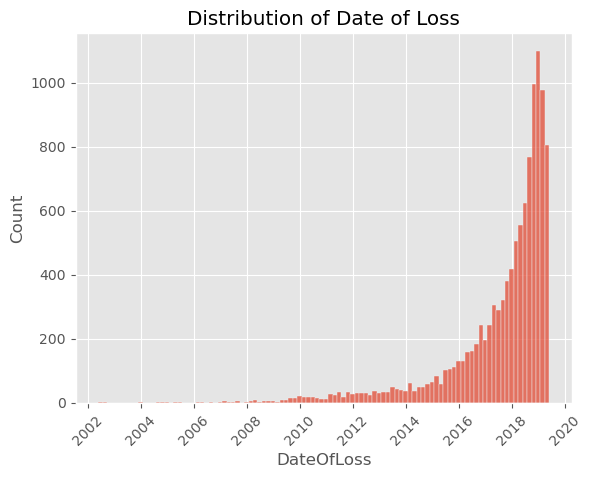

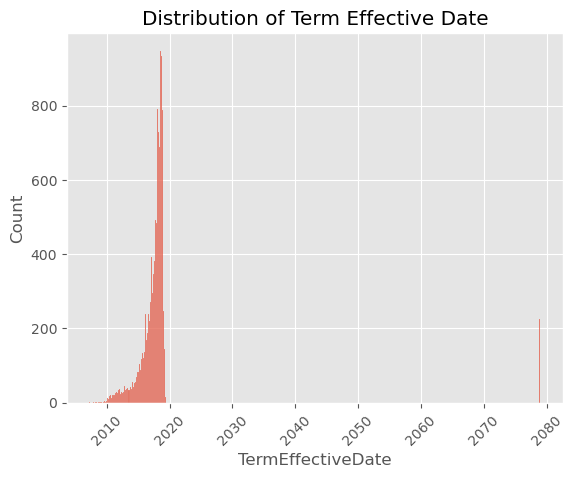

In [6]:
sns.histplot(data=df_claimMaster, x='DateOfLoss')
plt.title('Distribution of Date of Loss')
plt.xticks(rotation=45)
plt.show()

sns.histplot(data=df_claimMaster, x='TermEffectiveDate')
plt.title('Distribution of Term Effective Date')
plt.xticks(rotation=45)
plt.show()

##### There appears to be a major outlier caused by an error in the Term Effective Date column. 

In [7]:
# Determine the min and max values for each column and determine if they make sense
min_value_dateLoss = df_claimMaster['DateOfLoss'].min()
max_value_dateLoss = df_claimMaster['DateOfLoss'].max()
min_value_termDate = df_claimMaster['TermEffectiveDate'].min()
max_value_termDate = df_claimMaster['TermEffectiveDate'].max()

print("Earliest DateOfLoss:", min_value_dateLoss)
print("Earliest TermEffectiveDate:", min_value_termDate)
print('')
print("Latest DateOfLoss':", max_value_dateLoss)
print("Latest TermEffectiveDate':", max_value_termDate)

Earliest DateOfLoss: 2002-05-28 01:20:00
Earliest TermEffectiveDate: 2007-03-28 00:00:00

Latest DateOfLoss': 2019-05-31 00:00:00
Latest TermEffectiveDate': 2078-12-31 00:00:00


##### This confirms that there are policies that have TermEffectiveDates in 2078 (after present) and DateOfLosses prior to the minimum TermEffectiveDate

In [8]:
# Identify where there are claims that are on policies that are in the future
mask = df_claimMaster['TermEffectiveDate'].dt.year > 2024

incorrect_date_indices = df_claimMaster.index[mask]
#print("Indices of rows with incorrect dates:", incorrect_date_indices.tolist())
df_incorrect_dates = df_claimMaster[mask]
df_incorrect_dates.head()

#Unique values of df_incorrect_dates
print(df_incorrect_dates['TermEffectiveDate'].value_counts())


TermEffectiveDate
2078-12-31    225
Name: count, dtype: int64


##### There are 225 values with the date '2078-12-31'

In [9]:
#This shows that all outlier rows have the effective term date of 12/31/2078. 
# After trying to change them all to 2018, it still returned negative values in the DaysToClaim field. 
# After trying to pull the information from df_masterQuote, which shares policyNumber and TermEffectiveDate columns, it was still dirty. 
# Determined the best course of action would be to remove those features from the df_claimMaster dataframe alltogether. 
# I then compared the min max values of DateOfLoss and TermEffectiveDate

mask = df_claimMaster['TermEffectiveDate'] == pd.Timestamp('2078-12-31')
df_claimMaster = df_claimMaster[~mask]

# Determine the min and max values for each column and determine if they make sense after removing outliers. 
min_value_dateLoss = df_claimMaster['DateOfLoss'].min()
max_value_dateLoss = df_claimMaster['DateOfLoss'].max()
min_value_termDate = df_claimMaster['TermEffectiveDate'].min()
max_value_termDate = df_claimMaster['TermEffectiveDate'].max()

print("Earliest DateOfLoss:", min_value_dateLoss)
print("Earliest TermEffectiveDate:", min_value_termDate)
print('')
print("Latest DateOfLoss':", max_value_dateLoss)
print("Latest TermEffectiveDate':", max_value_termDate)


Earliest DateOfLoss: 2007-12-06 14:00:00
Earliest TermEffectiveDate: 2007-03-28 00:00:00

Latest DateOfLoss': 2019-05-31 00:00:00
Latest TermEffectiveDate': 2019-05-24 00:00:00


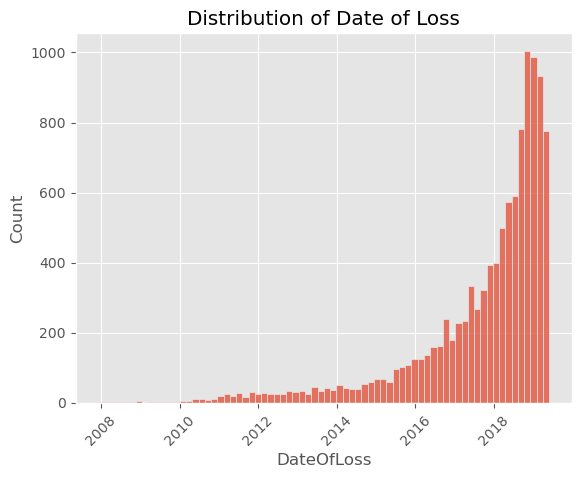

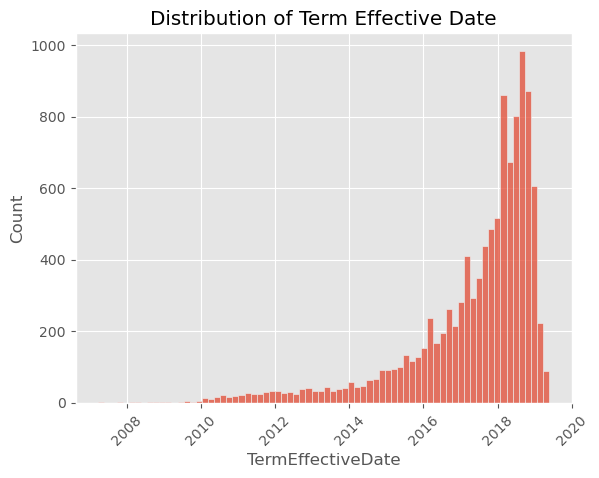

In [10]:
sns.histplot(data=df_claimMaster, x='DateOfLoss')
plt.title('Distribution of Date of Loss')
plt.xticks(rotation=45)
plt.show()

sns.histplot(data=df_claimMaster, x='TermEffectiveDate')
plt.title('Distribution of Term Effective Date')
plt.xticks(rotation=45)
plt.show()

#### The df_claimMaster dataset looks much better now. 

### Cleaning df_claimTrans

In [11]:
df_claimTrans_columns = df_claimTrans.columns.values
df_claimTrans_columns

array(['ClaimNumber', 'ExposureKey', 'MBasicPaidLoss', 'MBasicReserves',
       'MLossAdjustmentExpense', 'MLossExposureClosedTotal',
       'MLossExposureClosedWithoutPay', 'MLossExposureClosedWithPay',
       'MLossExposureOpen', 'MPaidLoss', 'MReserves', 'MSalvageRecovery',
       'MSubrogationRecovery', 'Right_ClaimID', 'ClaimantNumber',
       'Right_CompanyNumber', 'CoverageCode',
       'Right_CoverageEffectiveDate', 'Right_DateOfLoss',
       'Right_DriverNumber', 'Right_LossState',
       'Right_LossStateDescription', 'MonetaryCategory',
       'Right_NotificationDate', 'PolicyNumber', 'Right_PolicyStateCode',
       'Right_PolicyStateDescription', 'ReserveID',
       'ReserveSequenceNumber', 'TransactionCode',
       'TransactionCodeAction', 'TransactionDate', 'TransactionDateMonth',
       'Right_VehicleID', 'Right_CLM_TRN_TYPE_L2',
       'ClaimTransactionRowNumber'], dtype=object)

In [12]:
df_claimTrans.sample(10)

ClaimNumber          ExposureKey  MBasicPaidLoss  MBasicReserves  \
182109  PA0002385777  RNT5041921553329658             0.0            0.00   
90256   PA0002259819   PD5028350552176544             0.0            0.00   
209557  PA0002404246   PD5043912053497012             0.0         2000.00   
56317   PA0002203624   PD5022387451671942             0.0            0.00   
227630  PA0002407555  CMP5044276253526464             0.0            0.00   
5269    PA0002337743  COL5036648952892259             0.0        -2405.85   
71984   PA0002401296   BI5043596053469595             0.0         1500.00   
165202  PA0002415637  COL5045231253601899             0.0          146.12   
3127    PA0002031039   PD5003639950228970          2157.0            0.00   
157468  PA0002194257   PD5021389351588694             0.0         -434.29   

        MLossAdjustmentExpense  MLossExposureClosedTotal  \
182109                     0.0                         0   
90256                      0.0                         0   
209557                     0.0                         0   
56317                      0.0                         0   
227630                     0.0                         0   
5269                       0.0                         0   
71984                      0.0                        -1   
165202                     0.0                         0   
3127                       0.0                         0   
157468                     0.0                         1   

        MLossExposureClosedWithoutPay  MLossExposureClosedWithPay  \
182109                              0                           0   
90256                               0                           0   
209557                              0                           0   
56317                               0                           0   
227630                              0                           0   
5269                                0                           0   
71984                              -1                           0   
165202                              0                           0   
3127                                0                           0   
157468                              0                           1   

        MLossExposureOpen  MPaidLoss  ...  Right_PolicyStateDescription  \
182109                  0        0.0  ...                     Minnesota   
90256                   0        0.0  ...                      Delaware   
209557                  1        0.0  ...                  North Dakota   
56317                   0        0.0  ...                       Alabama   
227630                  0        0.0  ...                South Carolina   
5269                    0        0.0  ...                      Colorado   
71984                   0        0.0  ...                       Georgia   
165202                  0        0.0  ...                          Ohio   
3127                    0     2157.0  ...                      Colorado   
157468                  0        0.0  ...                          Ohio   

        ReserveID  ReserveSequenceNumber  TransactionCode  \
182109   51011139             9950553622               NT   
90256    50669907               51575303               NT   
209557   51065502               52594956               RE   
56317    50623058               51454902               NT   
227630   51069846               52605933               NT   
5269     50880786               52194116               RE   
71984    51055458               53266709               RE   
165202   51108296               52708275               RE   
3127     50068317               50183203               PL   
157468   50496882               51159290               RE   

        TransactionCodeAction      TransactionDate TransactionDateMonth  \
182109                  CLOSE  2018-11-14 00:00:00  2018-11-01 00:00:00   
90256                 RESERVE  2017-10-16 00:00:00  2017-10-01 00:00:00   
209557           

##### Drop duplicate values from df_claimTrans

In [13]:
# Drop Duplicates from df_claimTrans
df_claimTrans.drop_duplicates(subset='ClaimTransactionRowNumber', keep='first',inplace=True)

### Cleaning df_policyContact


##### Drop Duplicates from df_policyContact

In [14]:
df_policyContact = df_policyContact.sort_values(by=['Right_PolicyNumber', 'DriverNumber'])
df_policyContact = df_policyContact.drop_duplicates(subset=['Right_PolicyNumber'], keep='first')

### Cleaning df_masterQuote

##### Fill all null values in PolicyNumber with "NoPolicy"

In [15]:
df_masterQuote['PolicyNumber'].fillna('NoPolicy', inplace=True)


### Cleaning df_quoteContact

##### Drop duplicates from df_quoteContact that appear due to multiple drivers appearing on a quote

In [16]:
df_quoteContact = df_quoteContact.sort_values(by=['Right_QuoteNumber', 'DriverNumber'])
df_quoteContact = df_quoteContact.drop_duplicates(subset=['Right_QuoteNumber'], keep='first')

### Cleaning df_demoInfo

In [17]:
df_demoInfo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84082 entries, 0 to 84081
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   APID                            84082 non-null  object
 1   Income_Dollars                  84082 non-null  int64 
 2   Age                             84082 non-null  int64 
 3   Adults_in_Household             84082 non-null  int64 
 4   Househoold_Size                 84082 non-null  int64 
 5   Discretionary_Spending_Dollars  84082 non-null  int64 
 6   Homeowner                       84082 non-null  int64 
 7   Married                         84082 non-null  int64 
 8   Predict_4                       84082 non-null  int64 
 9   Age_Cat                         84082 non-null  object
 10  Income_Cat                      84082 non-null  object
 11  Household_Cat                   84082 non-null  object
dtypes: int64(8), object(4)
memory usage: 8.3+ MB


In [18]:
df_demoInfo.sample()

APID  Income_Dollars  Age  Adults_in_Household  \
54030  04ZJUS01RNST2PYD           20000   62                    1   

       Househoold_Size  Discretionary_Spending_Dollars  Homeowner  Married  \
54030                2                            3852          0        0   

       Predict_4     Age_Cat  Income_Cat Household_Cat  
54030          3  Above Mean  Low Income             2

In [19]:
df_demoInfo = df_demoInfo.sort_values(by=['APID'])
df_demoInfo = df_demoInfo.drop_duplicates(subset=['APID'], keep='first')

In [20]:
# Class the columns with string values to integers
df_demoInfo['Age_Cat'] = df_demoInfo['Age_Cat'].map({'Above Mean': 1, 'Below Mean': 0})
df_demoInfo['Income_Cat'] = df_demoInfo['Income_Cat'].map({'Low Income': 0, 'High Income': 1})
df_demoInfo['Household_Cat'] = df_demoInfo['Household_Cat'].map({'1': 1, '2': 2,'3':3, '4':4, '5 or more':5})

In [21]:
df_demoInfo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84082 entries, 84081 to 0
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   APID                            84082 non-null  object
 1   Income_Dollars                  84082 non-null  int64 
 2   Age                             84082 non-null  int64 
 3   Adults_in_Household             84082 non-null  int64 
 4   Househoold_Size                 84082 non-null  int64 
 5   Discretionary_Spending_Dollars  84082 non-null  int64 
 6   Homeowner                       84082 non-null  int64 
 7   Married                         84082 non-null  int64 
 8   Predict_4                       84082 non-null  int64 
 9   Age_Cat                         84082 non-null  int64 
 10  Income_Cat                      84082 non-null  int64 
 11  Household_Cat                   84082 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 8.3+ MB


#### Turns out I did not need to clean the data as far as I can tell. 

### Cleaning df_abilitechInfo

In [22]:
df_abilitechInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96501 entries, 0 to 96500
Columns: 243 entries, AbilitecContactID to AP004163_Own_a_PlayStation_V2_rank_base_20_RBGM4824
dtypes: float64(233), int64(9), object(1)
memory usage: 178.9+ MB


In [23]:
df_abilitechInfo.sample()

AbilitecContactID  ACX_ZIPCODE  ACX_ZIP4  \
16061  04ZJUS02XXT9S90Q        32218    2009.0   

       AP003732_Influenced_to_Purchase_Athletic_Shoe_Store_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4869  \
16061                                               14.0                                                          

       AP003733_Influenced_to_Purchase_Discount_Mass_Merchant_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4870  \
16061                                               12.0                                                             

       AP003734_Influenced_to_Purchase_Department_Store_Footwear_Due_to_Advertising_V2_rank_base_20_rbgm4871  \
16061                                                 19                                                       

       AP003739_Influenced_to_Purchase_Apparel_Specialty_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4876  \
16061                                               17.0                                                        

       AP003746_Influenced_to_Purchase_Athletic_Shoe_Store_Footwear_Due_to_Price_Special_Offer_V2_rank_base_20_RBGM4885  \
16061                                               17.0                                                                  

       AP003782_Influenced_to_Purchase_Athletic_Shoe_Store_Footwear_Due_to_Technology_V2_rank_base_20_RBGM4925  \
16061                                               19.0                                                         

       AP003797_Influenced_to_Purchase_Athletic_Shoe_Store_Footwear_Due_to_a_Specific_Shoe_Model_V2_rank_base_20_RBGM4941  \
16061                                               19.0                                                                    

       ...  \
16061  ...   

       AP004154_Out_of_Home_Consumption_at_Popeyes_V2_rank_base_20_RBGM4001  \
16061                                               17.0                      

       AP004155_Out_of_Home_Consumption_at_TGI_Fridays_V2_rank_base_20_RBGM4008  \
16061                                               14.0                          

       AP004156_Out_of_Home_Consumption_at_Taco_Bell_V2_rank_base_20_RBGM4007  \
16061                                               12.0                        

       AP004157_Out_of_Home_Consumption_at_Dunkin_Donuts_V2_rank_base_20_RBGM3988  \
16061                                               19.0                            

       AP004158_Out_of_Home_Consumption_at_Pizza_Hut_V2_rank_base_20_RBGM4000  \
16061                                                8.0                        

       AP004159_Out_of_Home_Consumption_at_KFC_V2_rank_base_20_RBGM3992  \
16061                                                8.0                  

       AP004160_Out_of_Home_Consumption_at_Arbys_V2_rank_base_20_RBGM3978  \
16061                                                1.0                    

       AP004161_Own_a_Blu_Ray_Player_V2_rank_base_20_RBGM4822  \
16061                                               19.0        

       AP004162_Own_a_Xbox_V2_rank_base_20_RBGM4823  \
16061                                          10.0   

       AP004163_Own_a_PlayStation_V2_rank_base_20_RBGM4824  
16061                                                7.0    

[1 rows x 243 columns]

In [24]:
df_abilitechInfo = df_abilitechInfo.sort_values(by=['AbilitecContactID'])
df_abilitechInfo = df_abilitechInfo.drop_duplicates(subset=['AbilitecContactID'], keep='first')
df_abilitechInfo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96501 entries, 96500 to 0
Columns: 243 entries, AbilitecContactID to AP004163_Own_a_PlayStation_V2_rank_base_20_RBGM4824
dtypes: float64(233), int64(9), object(1)
memory usage: 179.6+ MB


In [25]:
df_AP3_columns = df_abilitechInfo.columns.values
df_abilitechInfo[df_AP3_columns] = df_abilitechInfo[df_AP3_columns].fillna(0)

#### Drop data info that does not work well in a model

In [26]:
# Drop non modelled columns 
df_abilitechInfo = df_abilitechInfo.drop(['ACX_ZIPCODE', 'ACX_ZIP4'], axis=1)

## Section 3 Summary

- In this section, I cleaned all of the imported datasets to prepare them for merging into our six required DataFrames. 
- Discovering an outlier and correcting it, and filling null values was mostly what I did. 
- It is possible that I should have placed my code that converts my columns from categorical to numerical data here. 

############################################################################################################################
## Section 4 - Merge the data

### Description
#### In this section, six DataFrames are built in preparation of Section 5: Exploratory analysis. 
    - df_ClaimMasterTrans (Combination of df_claimMaster and df_claimTrans)
    - df_PolicyContact (Combination of df_policyContact and df_claimMaster)
    - df_MasterQuote (Combination of df_masterQuote and df_quoteContact)
    - df_TheGeneral (Combination of df_ClaimMasterTrans and df_PolicyContact)
    - df_Demo (Demographic information with APID as AbilitechID)
    - df_Abilitech (Modelling information showing grades of how AbilitechContactID activity relates to the data)

## Creating ClaimMasterTrans

##### Sum up the total paidlosses by ClaimNumber in df_claimTrans, and then rename them to ClaimTransPaidLoss

In [27]:
# Sum df_claimtrans
paid_loss_summary = df_claimTrans.groupby('ClaimNumber')['MPaidLoss'].sum().reset_index()
paid_loss_summary.rename(columns={'MPaidLoss': 'ClaimTransPaidLoss'}, inplace=True)

##### Count the number of transactions per claim in df_claimTrans and then save them as ClaimTransCount

In [28]:
# Count transactions per claim in df_claimtrans
claimtranscount = df_claimTrans.groupby('ClaimNumber').size().reset_index(name='ClaimTransCount')

In [29]:
# Merge the sum of paidlosses into claimMaster
df_claimMaster = pd.merge(df_claimMaster, paid_loss_summary, on='ClaimNumber', how='left')

In [30]:
# Merge the count of transactions into claimNumber
df_claimMaster = pd.merge(df_claimMaster, claimtranscount, on='ClaimNumber', how='left')

In [31]:
# Create DaysToClaim to show number of days between the day they made a claim and the day the policy started

df_claimMaster['DaysToClaim'] = (df_claimMaster['DateOfLoss'] - df_claimMaster['TermEffectiveDate']).dt.days.astype(float)

# Create DaysToClaim_h to show the number of hours between the day they made the claim and the day the policy started
df_claimMaster['DaysToClaim_h'] = ((df_claimMaster['DateOfLoss'] - df_claimMaster['TermEffectiveDate']).dt.total_seconds() / 3600).astype('int64')

In [32]:
#Fill in NaN values with 0 for new column
df_claimMaster['ClaimTransPaidLoss'].fillna(0, inplace=True)
df_claimMaster['ClaimTransCount'].fillna(0, inplace=True)

In [33]:
df_ClaimMasterTrans = df_claimMaster[['ClaimNumber', 'AtFaultDescription', 'ClaimStatus','ClaimType','DateOfLoss','DriverID','LossState','PolicyNumber','PolicyStateCode','SubrogrationFlag','TermEffectiveDate','VehicleID','ClaimTransPaidLoss','ClaimTransCount','DaysToClaim','DaysToClaim_h']]

In [34]:
# View the newly created df_ClaimMasterTrans dataframe
df_ClaimMasterTrans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844 entries, 0 to 10843
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ClaimNumber         10844 non-null  object        
 1   AtFaultDescription  10844 non-null  object        
 2   ClaimStatus         10844 non-null  object        
 3   ClaimType           10844 non-null  object        
 4   DateOfLoss          10844 non-null  datetime64[ns]
 5   DriverID            10844 non-null  int64         
 6   LossState           10844 non-null  object        
 7   PolicyNumber        10844 non-null  object        
 8   PolicyStateCode     10844 non-null  object        
 9   SubrogrationFlag    10844 non-null  object        
 10  TermEffectiveDate   10844 non-null  datetime64[ns]
 11  VehicleID           10844 non-null  int64         
 12  ClaimTransPaidLoss  10844 non-null  float64       
 13  ClaimTransCount     10844 non-null  float64   

## Creating df_PolicyContact
### This dataframe contains the contact information for each policy, including AbilitecID, HouseholdID, AddressID

##### View the raw data imported into the perpatory df_policyContact dataframe

In [35]:
df_policyContact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36368 entries, 29922 to 39053
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   AbilitecContactID        36368 non-null  object
 1   Right_PolicyNumber       36368 non-null  object
 2   DriverNumber             36368 non-null  int64 
 3   Right_AbilitecContactID  36368 non-null  object
 4   AbilitecHouseholdID      36368 non-null  object
 5   AbilitecAddressID        36368 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.9+ MB


In [36]:
df_policyContact.head()

AbilitecContactID Right_PolicyNumber  DriverNumber  \
29922  04ZJUS01XEYDG9QF       Q080MDA2MDUz             1   
24421  04ZJUS01QW3YR5MP       Q080MDA2NDE5             1   
5481   04ZJUS0143LMD00Z       Q080MDA2ODM3             1   
71472  04ZJUS117G4VY1QT       Q080MDA3Nzky             1   
56271  04ZJUS02NNX4E5CQ       Q080MDA5OTky             1   

      Right_AbilitecContactID AbilitecHouseholdID AbilitecAddressID  
29922        04ZJUS01XEYDG9QF    04ZJUS0356VDYBTY  04ZJUS0356VDYBTY  
24421        04ZJUS01QW3YR5MP    04ZJUS03B7YGD1HL  04ZJUS03XEVQDN5Q  
5481         04ZJUS0143LMD00Z    04ZJUS03QVT5HVY8  04ZJUS03QVT5HVY8  
71472        04ZJUS117G4VY1QT    04ZJUS034E00L23R  04ZJUS034E00L23R  
56271        04ZJUS02NNX4E5CQ    04ZJUS03135C7LL6  04ZJUS03135C7LL6

##### Create the df_PolicyContact DataFrame and Add Policy Number, DriverNumber, AbilitecContactID, AbilitecHouseholdID 

In [37]:
# Build the first four columns of df_PolicyContact
df_PolicyContact = df_policyContact[['Right_PolicyNumber','DriverNumber','Right_AbilitecContactID','AbilitecHouseholdID']]

In [38]:
# Rename columns as they appear in other dataframes
df_PolicyContact = df_PolicyContact.rename(columns={'Right_PolicyNumber': 'PolicyNumber','Right_AbilitecContactID':'AbilitecContactID'})

##### Add DriverCount to df_PolicyContact 

In [39]:
# Create the DriverCount that shows the number of drivers on the policy 
df_PolicyContact['DriverCount'] = df_PolicyContact.groupby('PolicyNumber')['DriverNumber'].transform('nunique').astype('int64')


##### Add ClaimCount to df_PolicyContact

In [40]:
claim_count_policy = df_claimMaster.groupby('PolicyNumber').size().reset_index(name='ClaimCount')

In [41]:
df_PolicyContact = pd.merge(df_PolicyContact, claim_count_policy, on='PolicyNumber', how='left')

##### Add TotalPaid to df_PolicyContact

In [42]:
sum_paid = df_claimMaster.groupby('PolicyNumber')['ClaimTransPaidLoss'].sum().reset_index()
sum_paid.rename(columns={'ClaimTransPaidLoss': 'TotalPaid'}, inplace=True)

In [43]:
df_PolicyContact = pd.merge(df_PolicyContact, sum_paid, on='PolicyNumber', how='left')

In [44]:
df_PolicyContact['ClaimCount'].fillna(0, inplace=True)
df_PolicyContact['TotalPaid'].fillna(0,inplace=True)

##### View the df_PolicyContact DataFrame that will be used later and verify that there are not major issues with typos and miscalculations. 

In [45]:
df_PolicyContact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36368 entries, 0 to 36367
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PolicyNumber         36368 non-null  object 
 1   DriverNumber         36368 non-null  int64  
 2   AbilitecContactID    36368 non-null  object 
 3   AbilitecHouseholdID  36368 non-null  object 
 4   DriverCount          36368 non-null  int64  
 5   ClaimCount           36368 non-null  float64
 6   TotalPaid            36368 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.9+ MB


In [46]:
df_PolicyContact.sample(10)

PolicyNumber  DriverNumber AbilitecContactID AbilitecHouseholdID  \
26651  UE43Nzg4MzE5             1  04ZJUS01PL9T232Q    04ZJUS03M4TGD71S   
24843  Tlk0MjM4MTA5             1  04ZJUS11TSVW51NE    04ZJUS030YDJ3DL7   
24175  TkgzMzUyNjk1             1  04ZJUS01LCWGY2PD    04ZJUS03B6B59GJK   
9421   Rkw0MDI5MTA1             1  04ZJUS01721JVPWV    04ZJUS03TTVGYKTB   
3879   Q0EzODA3MjEx             1  04ZJUS01VSX4KM7X    04ZJUS0335JWR7KN   
28838  UEEyMjkzNzM4             1  04ZJUS02RKT50V50    04ZJUS038TGBRJ2N   
5984   QVIyMzk0NTI5             1  04ZJUS01C8STEEK5    04ZJUS03G20H3NJS   
23146  TkMzOTUwODY5             1  04ZJUS01RKBVKQER    04ZJUS03MJBPKQL6   
16972  T0gyNDc1NDU1             1  04ZJUS01ZF80CDZV    04ZJUS03QXNC8LYN   
24427  TlY3NzIxNTI5             1  04ZJUS022QKL4F3E    04ZJUS03G20KJZ5C   

       DriverCount  ClaimCount  TotalPaid  
26651            1         0.0       0.00  
24843            1         0.0       0.00  
24175            1         2.0    9715.98  
9421             1         0.0       0.00  
3879             1         1.0       0.00  
28838            1         0.0       0.00  
5984             1         0.0       0.00  
23146            1         0.0       0.00  
16972            1         2.0   16923.23  
24427            1         0.0       0.00

##### View a distribution of DriverCount, ClaimCount, and TotalPaid to see if there are any outliers caused by errors

In [47]:
unique_values_DriverCount = df_PolicyContact['DriverCount'].unique()
unique_values_DriverCount

array([1], dtype=int64)

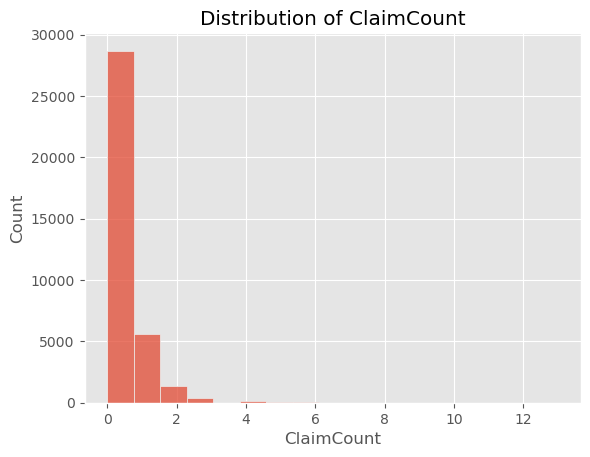

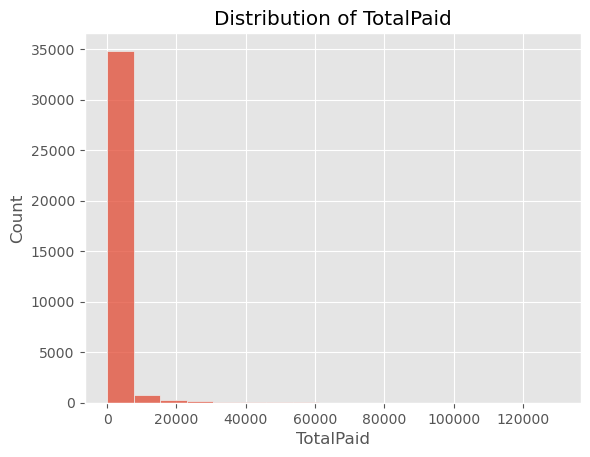

In [48]:
sns.histplot(data=df_PolicyContact, x='ClaimCount')
plt.title('Distribution of ClaimCount')
plt.show()

sns.histplot(data=df_PolicyContact, x='TotalPaid')
plt.title('Distribution of TotalPaid')
plt.show()

In [49]:
# Determine the min and max values for each column and determine if they make sense
min_value_claimCount =  df_PolicyContact['ClaimCount'].min()
max_value_claimCount = df_PolicyContact['ClaimCount'].max()
min_value_TotalPaid = df_PolicyContact['TotalPaid'].min()
max_value_TotalPaid = df_PolicyContact['TotalPaid'].max()

print("Minimum ClaimCount:", min_value_claimCount)
print("Maximum ClaimCount':", max_value_claimCount)

print("Minimum TotalPaid:", min_value_TotalPaid)
print("Maximum TotalPaid':", max_value_TotalPaid)

# Look into the legitamacy of these large values causing the heavy right skewing of the data 
paidMask = df_PolicyContact['TotalPaid'] > 100000
df_PolicyContact[paidMask]


Minimum ClaimCount: 0.0
Maximum ClaimCount': 13.0
Minimum TotalPaid: 0.0
Maximum TotalPaid': 130141.29999999999


PolicyNumber  DriverNumber AbilitecContactID AbilitecHouseholdID  \
1494   Q08zNjMyMTcy             1  04ZJUS012K0VH2J5    04ZJUS038XBBT8P5   
5384   QUwzMTQwNDY5             1  04ZJUS01XW9VHEF2    04ZJUS03LCS0CDEC   
6751   QVoxODUwMTMw             1  04ZJUS01BV7TLNL6    04ZJUS038SD2RP8L   
10537  RkwyNTY3MzQ5             1  04ZJUS02DYTT01KR    04ZJUS03PZHKZPHD   
25398  U0MyNDcwMzQ1             1  04ZJUS01NHK94KEX    04ZJUS13W9Y3E5CS   
29411  UkkyNzMyMTkx             1  04ZJUS01ERFP4GJE    04ZJUS13JF1EYYKK   
32434  VE4yNzQ5MDAx             1  04ZJUS02DD6EWGJL    04ZJUS036CX4W296   
35648  VkEzMTgwNzgw             1  04ZJUS02EZD0MD68    04ZJUS03GKGDGL1K   

       DriverCount  ClaimCount  TotalPaid  
1494             1         1.0  105000.00  
5384             1         2.0  107995.69  
6751             1         4.0  130141.30  
10537            1         4.0  111458.12  
25398            1         5.0  113125.77  
29411            1         8.0  121736.22  
32434            1         2.0  113840.05  
35648            1        13.0  119806.34

## Creating df_MasterQuote

##### View the raw data imported into the df_masterQuote dataframe

In [50]:
df_masterQuote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61109 entries, 0 to 61108
Columns: 132 entries, QuoteNumber to VehiclesWithFullCoverage
dtypes: datetime64[ns](1), float64(14), int64(42), object(75)
memory usage: 61.5+ MB


In [51]:
df_masterQuote.head()

QuoteNumber   QuoteID  MQuotedDownPayment  MQuotedPremium  \
0  MzM0MDA0OTE=  33053336               99.62          1011.0   
1  MzM0MDQxNzU=  33057259                0.00             0.0   
2  MzM0MTc2MTk=  33071581              156.70          1017.0   
3  MzM0MTc2MTk=  33071581              156.70          1017.0   
4  MzM0MTk3MjQ=  33073786              273.92          2974.0   

   MQuotedTotalPayment  MQuotesAll  MQuotesMobileBound  \
0               1136.0           1                   0   
1                  0.0           1                   0   
2               1160.0           1                   1   
3               1160.0           1                   1   
4               3054.0           1                   0   

   MQuotesMobileInitiated  MSalesPremium  MSales  ...  SourceOfSale  \
0                       0         1011.0       1  ...        2000OR   
1                       1            0.0       0  ...        2000IL   
2                       1         1017.0       1  ...        2000NV   
3                       1         1017.0       1  ...        2000NV   
4                       0         2974.0       1  ...        3000RI   

   SourceOfSaleDescription  SourceOfSaleGroup TermEffectiveDate  \
0        OR Internet Sales      Online Retail        2016-01-02   
1        IL Internet Sales      Online Retail        2016-01-03   
2        NV Internet Sales      Online Retail        2016-01-04   
3        NV Internet Sales      Online Retail        2016-01-04   
4          RI Retail Sales      Direct Retail        2016-01-26   

    TermExpirationDate  Territory  TransferNormIndicator  VehiclesActive  \
0  2017-01-02 00:00:00         42                      Y               1   
1  2017-01-03 00:00:00          0                      Y               0   
2  2017-01-04 00:00:00         53                      N               1   
3  2017-01-04 00:00:00         53                      N               1   
4  2017-01-26 00:00:00          6                      N               2   

  VehiclesWithBI VehiclesWithFullCoverage  
0              1                        0  
1              0                        0  
2              1                        0  
3              1                        0  
4              2                        2  

[5 rows x 132 columns]

##### Create the df_MasterQuote DataFrame and Add columns in prepatory df_masterQuote that were deemed needed

In [52]:
# Pull over columns from csv file 
df_MasterQuote = df_masterQuote[['QuoteNumber','MQuotedTotalPayment','BiFcCoverageInd','CoverageTypeDescription','DriversActive','GaragingState','NamedInsuredMaritalStatus','PolicyNumber','PolicyStateCode','PolicyTerm','QuoteInitiatedTime','TermEffectiveDate','TermExpirationDate']]

##### Add DriverNumber, Right_AbilitecContactID, AbilitecHouseholdID to df_MasterQuote from df_quoteContact 


In [53]:
df_MasterQuote = pd.merge(df_MasterQuote,
                          df_quoteContact[['Right_QuoteNumber','DriverNumber','Right_AbilitecContactID','AbilitecHouseholdID']],
                          left_on = 'QuoteNumber',
                          right_on = 'Right_QuoteNumber',
                          how='left')

##### Rename AbilitecContactID correctly and drop Right_QuoteNumber used for merge

In [54]:
df_MasterQuote.rename(columns={'Right_AbilitecContactID': 'AbilitecContactID'}, inplace=True)
df_MasterQuote = df_MasterQuote.drop([ 'Right_QuoteNumber'], axis=1)

##### Add a count of Drivers in new column DriverCount to df_MasterQuote

In [55]:
driver_counts = df_quoteContact.groupby('Right_QuoteNumber')['DriverNumber'].nunique().reset_index(name='DriverCount')

df_MasterQuote = pd.merge(df_MasterQuote,
                         driver_counts,
                         left_on='QuoteNumber',
                         right_on = 'Right_QuoteNumber',
                         how='left')
df_MasterQuote = df_MasterQuote.drop([ 'Right_QuoteNumber'], axis=1)

In [56]:
df_MasterQuote['TermExpirationDate'] = pd.to_datetime(df_MasterQuote['TermExpirationDate'])

In [57]:
# Dataframe of policy vs no policy
def gotPolicy(PolicyNumber):
    if PolicyNumber == 'NoPolicy':
            return 0
    else:
        return 1

In [58]:
df_MasterQuote.loc[:,'GotPolicy'] = df_MasterQuote['PolicyNumber'].apply(gotPolicy)

In [59]:
df_MasterQuote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61109 entries, 0 to 61108
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   QuoteNumber                61109 non-null  object        
 1   MQuotedTotalPayment        61109 non-null  float64       
 2   BiFcCoverageInd            61109 non-null  object        
 3   CoverageTypeDescription    61109 non-null  object        
 4   DriversActive              61109 non-null  int64         
 5   GaragingState              61109 non-null  object        
 6   NamedInsuredMaritalStatus  61109 non-null  object        
 7   PolicyNumber               61109 non-null  object        
 8   PolicyStateCode            61109 non-null  object        
 9   PolicyTerm                 61109 non-null  int64         
 10  QuoteInitiatedTime         61109 non-null  object        
 11  TermEffectiveDate          61109 non-null  datetime64[ns]
 12  Term

##  Creating df_TheGeneral

In [60]:
df_TheGeneral = pd.merge(df_PolicyContact, df_ClaimMasterTrans,on='PolicyNumber',how='left')

In [61]:
# fill in null values
df_TheGeneral[['ClaimNumber','AtFaultDescription','ClaimStatus','ClaimType','LossState','SubrogrationFlag']] = df_TheGeneral[['ClaimNumber','AtFaultDescription','ClaimStatus','ClaimType','LossState','SubrogrationFlag']].fillna('Unknown')
df_TheGeneral[['DriverID','VehicleID']] = df_TheGeneral[['DriverID', 'VehicleID']].fillna('0').astype('int64')
df_TheGeneral[['PolicyStateCode']] = df_TheGeneral[['PolicyStateCode']].fillna('UC')
df_TheGeneral[['ClaimTransPaidLoss','ClaimTransCount','DaysToClaim','DaysToClaim_h']] = df_TheGeneral[['ClaimTransPaidLoss','ClaimTransCount','DaysToClaim','DaysToClaim_h']].fillna(0).astype('float')

In [62]:
df_TheGeneral.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39531 entries, 0 to 39530
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   PolicyNumber         39531 non-null  object        
 1   DriverNumber         39531 non-null  int64         
 2   AbilitecContactID    39531 non-null  object        
 3   AbilitecHouseholdID  39531 non-null  object        
 4   DriverCount          39531 non-null  int64         
 5   ClaimCount           39531 non-null  float64       
 6   TotalPaid            39531 non-null  float64       
 7   ClaimNumber          39531 non-null  object        
 8   AtFaultDescription   39531 non-null  object        
 9   ClaimStatus          39531 non-null  object        
 10  ClaimType            39531 non-null  object        
 11  DateOfLoss           10844 non-null  datetime64[ns]
 12  DriverID             39531 non-null  int64         
 13  LossState            39531 non-

## Section 4 Summary

- In this section, all of the original data sources were combined to produce four new dataframes. 
    - df_ClaimMasterTrans
        - Shows all the claim transactions and their relavant detail
    - df_PolicyContact
        - Shows the contactID, householdID, count of claims filed, and total amount paid out to them. 
    - df_MasterQuote
        - Shows all quotes and their relavant contactID, householdID, and PolicyNumber (if they got a Policy). 
    - df_TheGeneral
        - Shows policies, and the associated claims for each policy. 
        
 - Issues that were addressed. 
     - Some of the combined DataFrames had mismatched sizes, and therefore all of the null values had to be set to values such as 'Unknown'. 
     - Some models contained typos and outliers as a result of dirty data. That information had to be uncovered and removed. 
     - It was very cool to work with pandas in a way that mirrors sql joins. It is incredible to think of the data science that can be done with this tool. 

############################################################################################################################
############################################################################################################################

## Section 5 - Explore the data

############################################################################################################################
############################################################################################################################


### Description 
- In this code, I am going to attempt to uncover useful information from the data. 
- I will first look at some basic figures and visualization comparisons of the data, and then I will run predictive models using the datasets to see if there are any useful relationships between the columns in the AP03 dataset, which consists mostly of consumer behavior, and the activity of the AbiltechContact as our customer. 


##  Analyzing Claim Behavior

#### In this section, I'm looking into data related to filing a claim with our company. 

### What is the average quoted price of a policy? 

In [63]:
avg_policy_quote = df_MasterQuote.groupby('GotPolicy')['MQuotedTotalPayment'].mean().reset_index(name='AvgPolicyTotal')

In [64]:
upby('GotPolicy')['MQuotedTotalPayment'].mean().reset_index(name='AvgPolicyTotal')
avg_policy_quote = avg_policy_quote.loc[avg_poliavg_policy_quote = avg_policy_quote.loc[avg_policy_quote['GotPolicy'] == 1, 'AvgPolicyTotal'].iloc[0]

In [65]:
print(f"The average quoted payment on an accepted policy is ${avg_policy_quote:.2f}.")

The average quoted payment on an accepted policy is $1720.02.


### What is the average cost of a policy for The General? 

In [66]:
AvgCostPerPolicy = df_TheGeneral.groupby('PolicyNumber')['ClaimTransPaidLoss'].sum().reset_index(name='AvgTotalPolicy')
print(f"The average cost of a given policy due to claims is ${AvgCostPerPolicy['AvgTotalPolicy'].mean():.2f}.")

The average cost of a given policy due to claims is $1138.04.


### The potential profit of each policy is... 

In [67]:
print(f"The quoted payment price minus the average cost of policy is ${avg_policy_quote - AvgCostPerPolicy['AvgTotalPolicy'].mean():.2f}.")

The quoted payment price minus the average cost of policy is $581.98.


### How many policies are currently active? 

In [68]:
total_policies = len(df_PolicyContact)

In [69]:
print(f"There are {total_policies} policies in the PolicyContact list.")
print(f"If the float value above is correct, the policies above should provide overall float of ${total_policies * (avg_policy_quote - AvgCostPerPolicy['AvgTotalPolicy'].mean()):.2f}")

There are 36368 policies in the PolicyContact list.
If the float value above is correct, the policies above should provide overall float of $21165355.85


### $21,165,355.85 is the number we want to grow as a result of our work

### What % of AbilitechContactId's have filed zero claims? 

In [70]:
percent_zero_claims = (df_PolicyContact['ClaimCount'] == 0).mean() * 100
print(f"The percentage of policies that have zero claims is {percent_zero_claims:.2f}%")

The percentage of policies that have zero claims is 78.88%


This is a useful benchmark. The higher this percentage, the better our bottom line. Finding factors that maximize keeping claims at zero would be great.

### What is the average number of claims per policy? 

In [71]:
AvgClaimPerPolicy = df_TheGeneral.groupby('PolicyNumber')['ClaimCount'].sum().reset_index(name='AvgClaims')
print(f"The average claim that a given policy has is {AvgClaimPerPolicy['AvgClaims'].mean():.2f} claims.")

The average claim that a given policy has is 0.58 claims.


This value is useful because it can give us an idea if we are seeing an overall rise in claims over time. 

### What is the average number of claims per Abilitech Contacts and Households? 

In [72]:
AvgClaimPerContact = df_PolicyContact.groupby('AbilitecContactID')['ClaimCount'].sum().reset_index(name='AvgClaims')
AvgClaimPerHousehold = df_PolicyContact.groupby('AbilitecHouseholdID')['ClaimCount'].sum().reset_index(name='AvgClaims')

print(f"The average claim that a Contact has is {AvgClaimPerContact['AvgClaims'].mean():.2f} claims.")
print(f"The average claim that a Household has is {AvgClaimPerHousehold['AvgClaims'].mean():.2f} claims.")

The average claim that a Contact has is 0.42 claims.
The average claim that a Household has is 0.38 claims.


The average individual has less than the average policy, which makes sense. 
The Average household also has less than the average contact, because there can be multiple people in a household. 

### What is the Average total paid per Contact and Household?

In [73]:
AvgPaidPerContact = df_PolicyContact.groupby('AbilitecContactID')['TotalPaid'].sum().reset_index(name='Total_Paid')
AvgPaidPerHousehold = df_PolicyContact.groupby('AbilitecHouseholdID')['TotalPaid'].sum().reset_index(name='Total_Paid')

print(f"The average total paid to a Contact is ${AvgPaidPerContact['Total_Paid'].mean():.2f}.")
print(f"The average total paid to a Household is ${AvgPaidPerHousehold['Total_Paid'].mean():.2f}.")

The average total paid to a Contact is $1613.39.
The average total paid to a Household is $1436.60.


These numbers are good to know becuase they can be identified as key performance indicators of our business. 

### Given that a policy files claims, what is the average number of claims per policy? 


In [74]:
claims_per_policy_with_claims = df_ClaimMasterTrans.groupby('PolicyNumber')['ClaimNumber'].count().astype('float')
claims_per_policy_with_claims = claims_per_policy_with_claims.mean()
print(f"The average number of claims per policy that has filed 1 claim is {claims_per_policy_with_claims:.2f}")

The average number of claims per policy that has filed 1 claim is 1.41


Knowing how many claims can be expected from those who file claims allows our business to get a sense of how many mulitple claim customers we are holding policies for. We could possibly use this value to gauage whether to trigger a premium increase. 

### Given that a policy filed a claim, what is the average loss amount per policy? 

In [75]:
loss_per_policy_with_claims = df_ClaimMasterTrans.groupby('PolicyNumber')['ClaimTransPaidLoss'].mean().astype('float')
loss_per_policy = loss_per_policy_with_claims.mean()
print(f"The average loss per policy that files claims is ${loss_per_policy:.2f}")
print(f"This is a ${loss_per_policy - AvgCostPerPolicy['AvgTotalPolicy'].mean():.2f} difference between a policy that does not file a claim.")

The average loss per policy that files claims is $3715.42
This is a $2577.37 difference between a policy that does not file a claim.


This is a key figure to know, as we can gauge in the abstract what the cost of a cutomer filing a claim really comes out to be. Once a claim is filed, or an individual is identified as highly likely to file a claim, we can work that into our risk assessment. 

### What is the average DaysToClaim per policy that file claims? 

In [76]:
avg_days_to_claim = df_ClaimMasterTrans.groupby('ClaimNumber')['DaysToClaim'].mean().astype('float')
avg_days_to_claim = avg_days_to_claim.mean()
print(f"The average days to claim for accounts that file claims is {avg_days_to_claim:.2f} which is roughly {avg_days_to_claim/30:.2f} months")

The average days to claim for accounts that file claims is 136.49 which is roughly 4.55 months


This figure is very important, as it gives us an idea of roughly how long the average policy has until they file a claim. If we can identify accounts that fall way to the left or right of this mean value, we can maybe identify factors that can help increase this number and minimize our losses. 

### What types of claims are most common? 

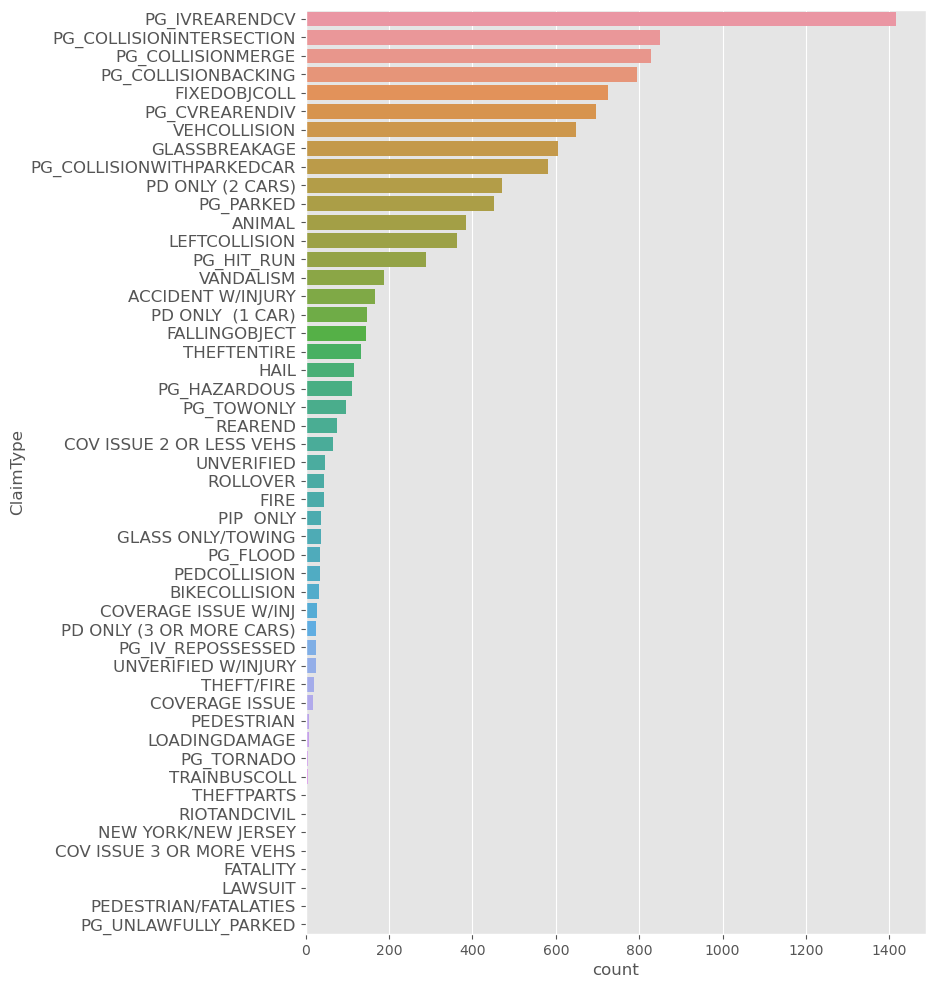

In [77]:
order = df_ClaimMasterTrans['ClaimType'].value_counts().index

plt.figure(figsize=(8,12))
sns.countplot(y='ClaimType',data=df_ClaimMasterTrans, order=order)
plt.yticks(fontsize=12)
plt.show()

It appears that 13 of the top 15 are directly related to collisions. This would be important to factor into our pricing model. Collision coverage needs to reflect just how common of an occurrence collisions are. Also, factors that decrease the liklihood of collisions would be good to know. For example, if we could identify the amount of time/mileage a driver spends on the road while insured with us. If we could identify data sources of the location of collisions in the areas around the driver, or we could find ways to reward the insured driver for avoiding (or at least not filing claims) on collisions.  

In [78]:
# This data adds the counts to a new temp dataframe called claim_type
claim_type_counts = df_ClaimMasterTrans['ClaimType'].value_counts()
claim_type_counts.reset_index()
claim_type_counts.columns = ['UniqueValue', 'Count']

claim_type = pd.DataFrame(claim_type_counts)


### What is the sum total cost per type of claim? 

In [79]:
# Add the sum total data of claim type
paid_loss_by_claim_type = df_ClaimMasterTrans.groupby('ClaimType')['ClaimTransPaidLoss'].sum().reset_index(name='TotalLosses')
# Add to claim_type dataframe
claim_type = pd.merge(claim_type, paid_loss_by_claim_type, on='ClaimType',how='left')


In [80]:
paid_loss_by_claim_type = paid_loss_by_claim_type.sort_values(by = 'TotalLosses', ascending=False)
paid_loss_by_claim_type

ClaimType  TotalLosses
32             PG_IVREARENDCV   9046012.23
25   PG_COLLISIONINTERSECTION   5964725.76
26          PG_COLLISIONMERGE   3555699.15
10               FIXEDOBJCOLL   3459755.68
49               VEHCOLLISION   3013002.78
15              LEFTCOLLISION   2642533.07
28             PG_CVREARENDIV   1399275.27
27  PG_COLLISIONWITHPARKEDCAR   1377461.91
24        PG_COLLISIONBACKING   1288515.69
0           ACCIDENT W/INJURY   1223518.68
1                      ANIMAL   1171442.64
19           PD ONLY (2 CARS)    917797.90
31                 PG_HIT_RUN    813158.49
30               PG_HAZARDOUS    752918.52
34                  PG_PARKED    470324.86
13                       HAIL    433207.49
43                THEFTENTIRE    410898.58
41                   ROLLOVER    395577.89
21               PEDCOLLISION    359313.34
18           PD ONLY  (1 CAR)    357535.04
39                    REAREND    336147.12
7               FALLINGOBJECT    260310.54
2               BIKECOLLISION    227689.31
48                  VANDALISM    226615.96
29                   PG_FLOOD    217807.90
6        COVERAGE ISSUE W/INJ    201747.94
9                        FIRE    167799.21
20   PD ONLY (3 OR MORE CARS)    142074.07
38                  PIP  ONLY    136544.88
3    COV ISSUE 2 OR LESS VEHS    109236.55
12              GLASSBREAKAGE    108392.97
22                 PEDESTRIAN     65523.92
33          PG_IV_REPOSSESSED     17178.30
5              COVERAGE ISSUE     16186.94
47        UNVERIFIED W/INJURY     15821.62
42                 THEFT/FIRE     15158.62
14                    LAWSUIT     15000.00
35                 PG_TORNADO     14971.78
45               TRAINBUSCOLL     14329.74
40               RIOTANDCIVIL      6437.48
8                    FATALITY      4616.04
36                 PG_TOWONLY      4370.58
11          GLASS ONLY/TOWING      4218.42
37       PG_UNLAWFULLY_PARKED      2525.51
17        NEW YORK/NEW JERSEY      2289.29
46                 UNVERIFIED      2260.58
16              LOADINGDAMAGE       453.72
23      PEDESTRIAN/FATALATIES         0.00
44                 THEFTPARTS         0.00
4    COV ISSUE 3 OR MORE VEHS         0.00

### What is the average cost per type of claim? 

In [81]:
avg_paid_loss_by_claim_type = df_ClaimMasterTrans.groupby('ClaimType')['ClaimTransPaidLoss'].mean().reset_index()
avg_paid_loss_by_claim_type = avg_paid_loss_by_claim_type.rename(columns={'ClaimTransPaidLoss':'AvgLossPerClaim'})
claim_type = pd.merge(claim_type, avg_paid_loss_by_claim_type, on='ClaimType',how='left')

In [82]:
avg_paid_loss_by_claim_type = avg_paid_loss_by_claim_type.sort_values(by = 'AvgLossPerClaim', ascending=False)
avg_paid_loss_by_claim_type

ClaimType  AvgLossPerClaim
14                    LAWSUIT     15000.000000
21               PEDCOLLISION     10568.039412
41                   ROLLOVER      8790.619778
6        COVERAGE ISSUE W/INJ      7472.145926
0           ACCIDENT W/INJURY      7370.594458
15              LEFTCOLLISION      7299.815110
22                 PEDESTRIAN      7280.435556
2               BIKECOLLISION      7115.290937
25   PG_COLLISIONINTERSECTION      7017.324424
30               PG_HAZARDOUS      6722.486786
32             PG_IVREARENDCV      6388.426716
29                   PG_FLOOD      6223.082857
20   PD ONLY (3 OR MORE CARS)      5464.387308
10               FIXEDOBJCOLL      4778.668066
49               VEHCOLLISION      4649.695648
39                    REAREND      4422.988421
26          PG_COLLISIONMERGE      4294.322645
9                        FIRE      3813.618409
13                       HAIL      3702.628120
38                  PIP  ONLY      3690.402162
43                THEFTENTIRE      3089.463008
1                      ANIMAL      3050.631875
31                 PG_HIT_RUN      2823.466979
37       PG_UNLAWFULLY_PARKED      2525.510000
35                 PG_TORNADO      2495.296667
18           PD ONLY  (1 CAR)      2415.777297
45               TRAINBUSCOLL      2388.290000
27  PG_COLLISIONWITHPARKEDCAR      2370.846661
8                    FATALITY      2308.020000
40               RIOTANDCIVIL      2145.826667
28             PG_CVREARENDIV      2007.568537
19           PD ONLY (2 CARS)      1944.487076
7               FALLINGOBJECT      1807.712083
3    COV ISSUE 2 OR LESS VEHS      1680.562308
24        PG_COLLISIONBACKING      1620.774453
48                  VANDALISM      1205.404043
34                  PG_PARKED      1040.541726
5              COVERAGE ISSUE       899.274444
42                 THEFT/FIRE       797.822105
17        NEW YORK/NEW JERSEY       763.096667
33          PG_IV_REPOSSESSED       660.703846
47        UNVERIFIED W/INJURY       632.864800
12              GLASSBREAKAGE       178.866287
11          GLASS ONLY/TOWING       117.178333
16              LOADINGDAMAGE        56.715000
46                 UNVERIFIED        49.143043
36                 PG_TOWONLY        45.526875
4    COV ISSUE 3 OR MORE VEHS         0.000000
23      PEDESTRIAN/FATALATIES         0.000000
44                 THEFTPARTS         0.000000

### Display the 10 most frequent, least frequent, 10 highest cost overall, 10 highest cost per claim

Text(0.5, 0.98, 'Frequency and Expense of Claims')

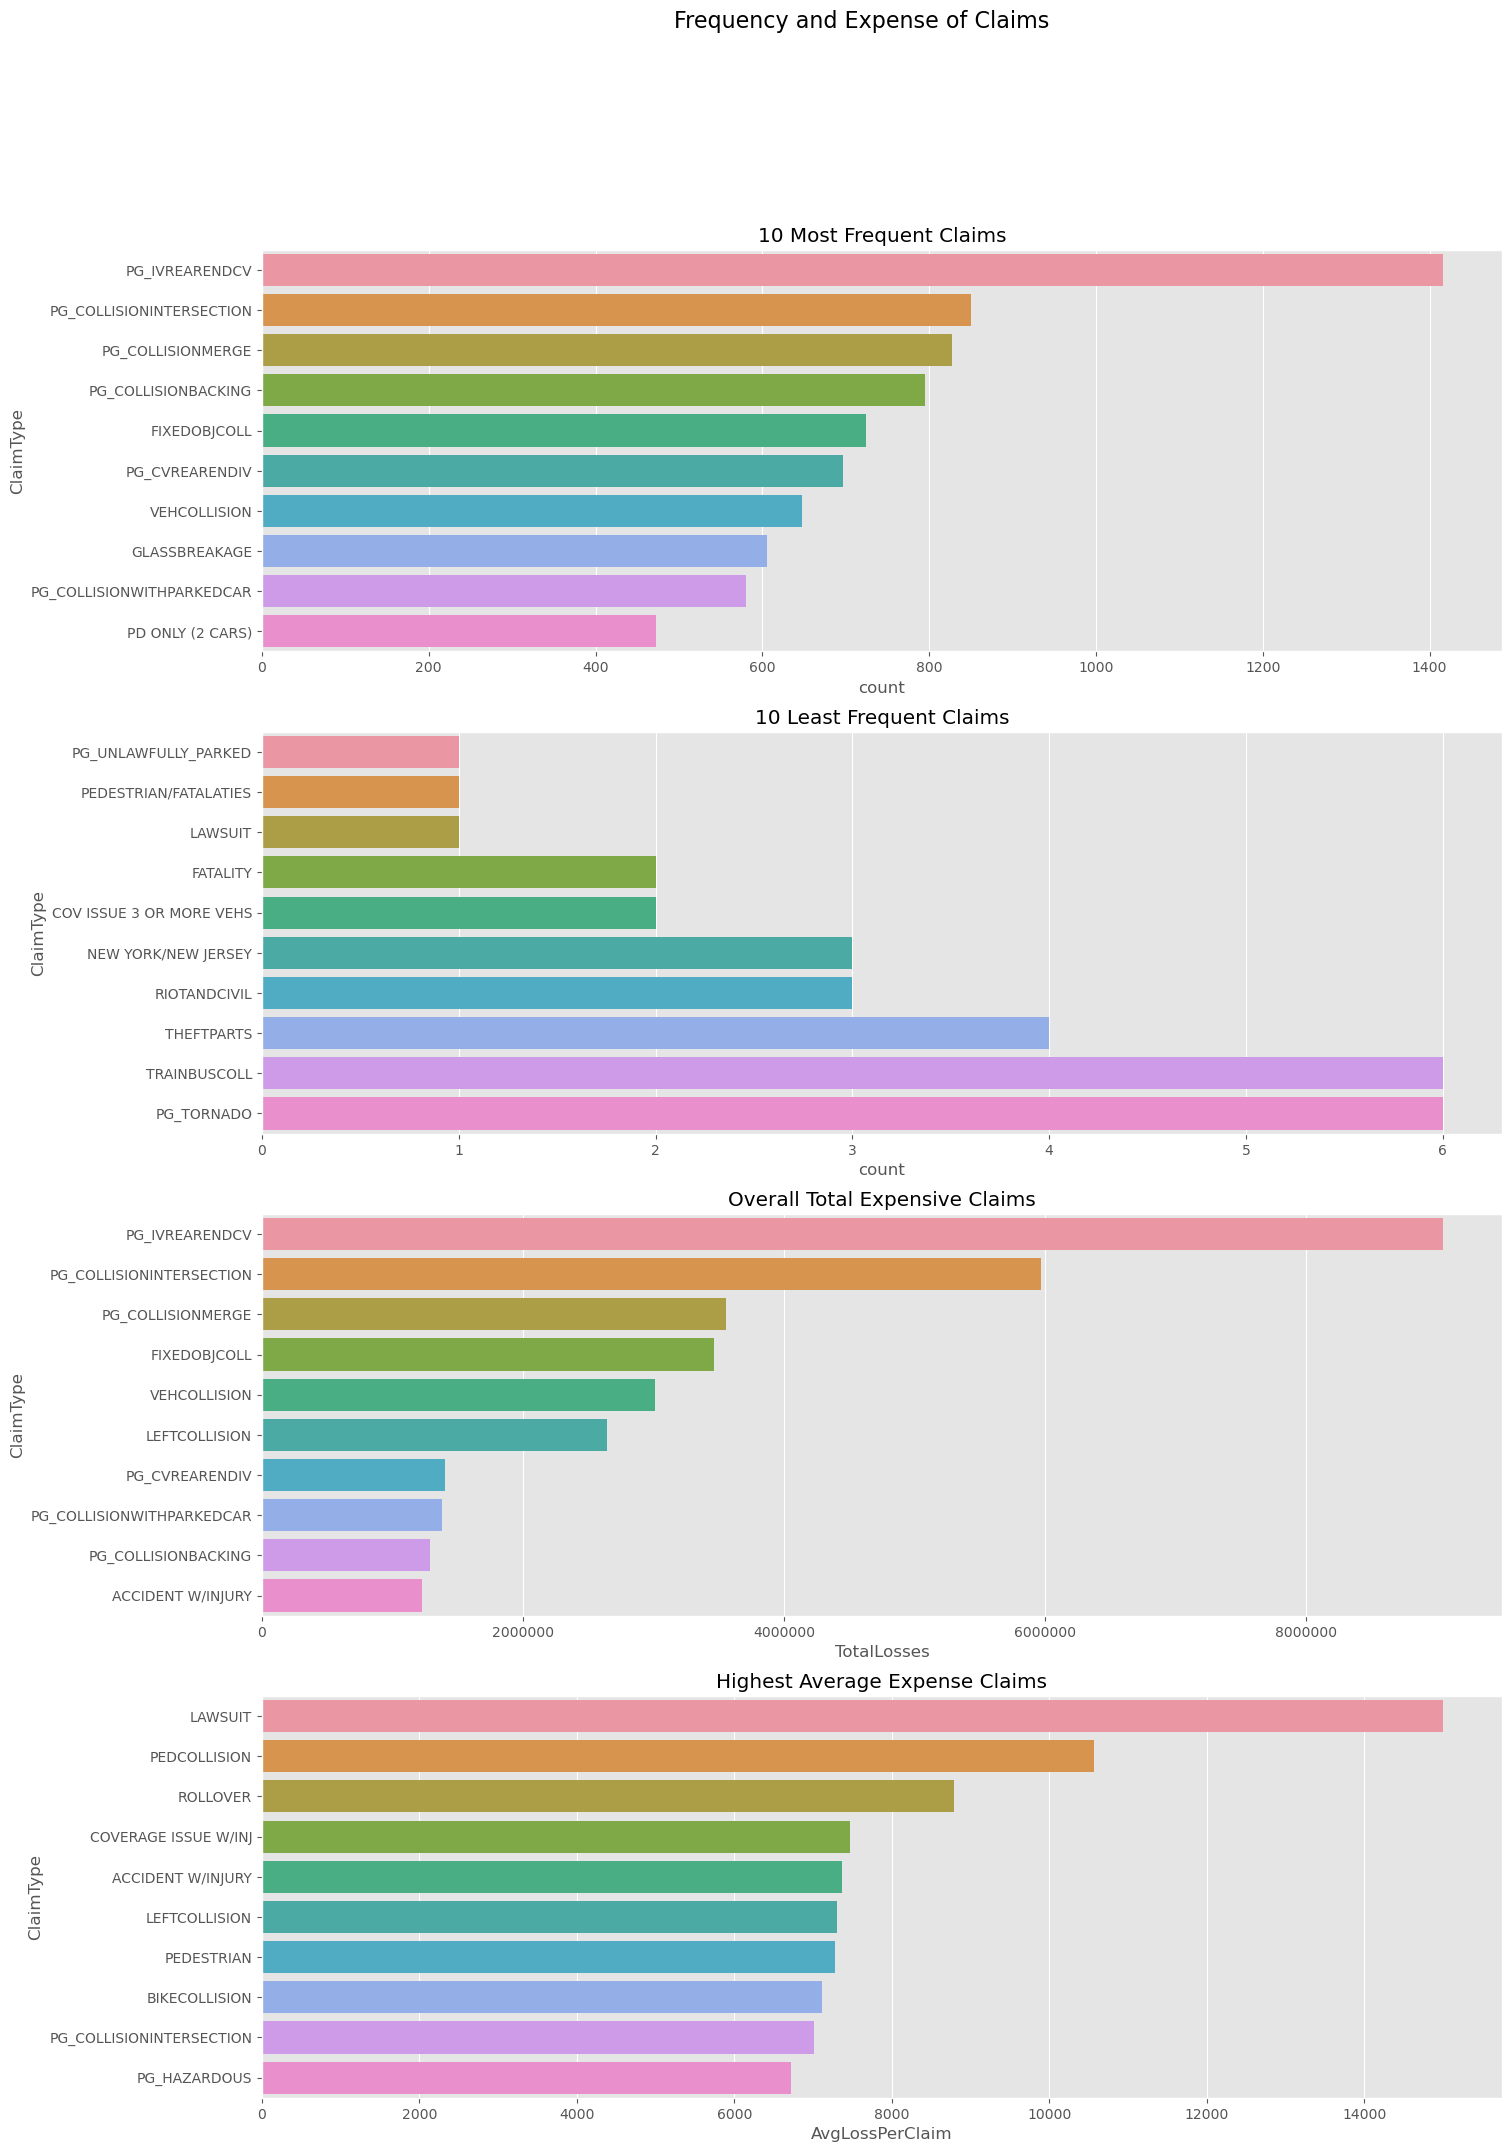

In [83]:
# Top 10 Frequent
df_top10_freq = claim_type.sort_values(by='count',ascending = False).head(10)

# Bottom 10 Frequent
df_bottom10_freq = claim_type.sort_values(by='count',ascending = True).head(10)

# 10 Highest Total Cost Claims
df_10highcost = claim_type.sort_values(by='TotalLosses',ascending = False).head(10)

# 10 Highest Total Cost Claims
df_10avghighcost = claim_type.sort_values(by='AvgLossPerClaim',ascending = False).head(10)


fig, axes = plt.subplots(4,1, figsize = (16,24))

# Top 10 Frequent
sns.barplot(data=df_top10_freq, y='ClaimType',x='count', ax=axes[0])
axes[0].set_title('10 Most Frequent Claims')

# 10 Least Frequent
sns.barplot(data=df_bottom10_freq, y='ClaimType',x='count', ax=axes[1])
axes[1].set_title('10 Least Frequent Claims')



# 10 Overall Cost
sns.barplot(data=df_10highcost, y='ClaimType',x='TotalLosses',ax=axes[2])
axes[2].set_title('Overall Total Expensive Claims')
axes[2].ticklabel_format(style='plain', axis='x')

# 10 Highest Total Cost Claims
sns.barplot(data=df_10avghighcost, y='ClaimType',x='AvgLossPerClaim',ax=axes[3])
axes[3].set_title('Highest Average Expense Claims')
axes[3].ticklabel_format(style='plain', axis='x')


fig.suptitle('Frequency and Expense of Claims', fontsize = 16)


Analysis: 
- The 5 largest average expenses are relatively uncommon. 
- The 9th most expensive on average is also the 2nd most common. Collisions in intersections. Identifying areas with high collision incidents and then finding out how often an insured driver is likely to cross could be a way to minimize this cost. 
- The LEFTCOLLISION is something to look out for. This appears to be driver side collision incidents, which likely result in damages to people and vehicles most often. Finding ways to minimize this value would be an interesting process. 
- Identifying places with high levels of pedestrians, bikes, or rollover potential could also minimize the liklihood of these high cost claims

### Display the Average and Total Cost Relative to Frequency

Text(0.5, 1.0, 'Average Cost Relative to Frequency')

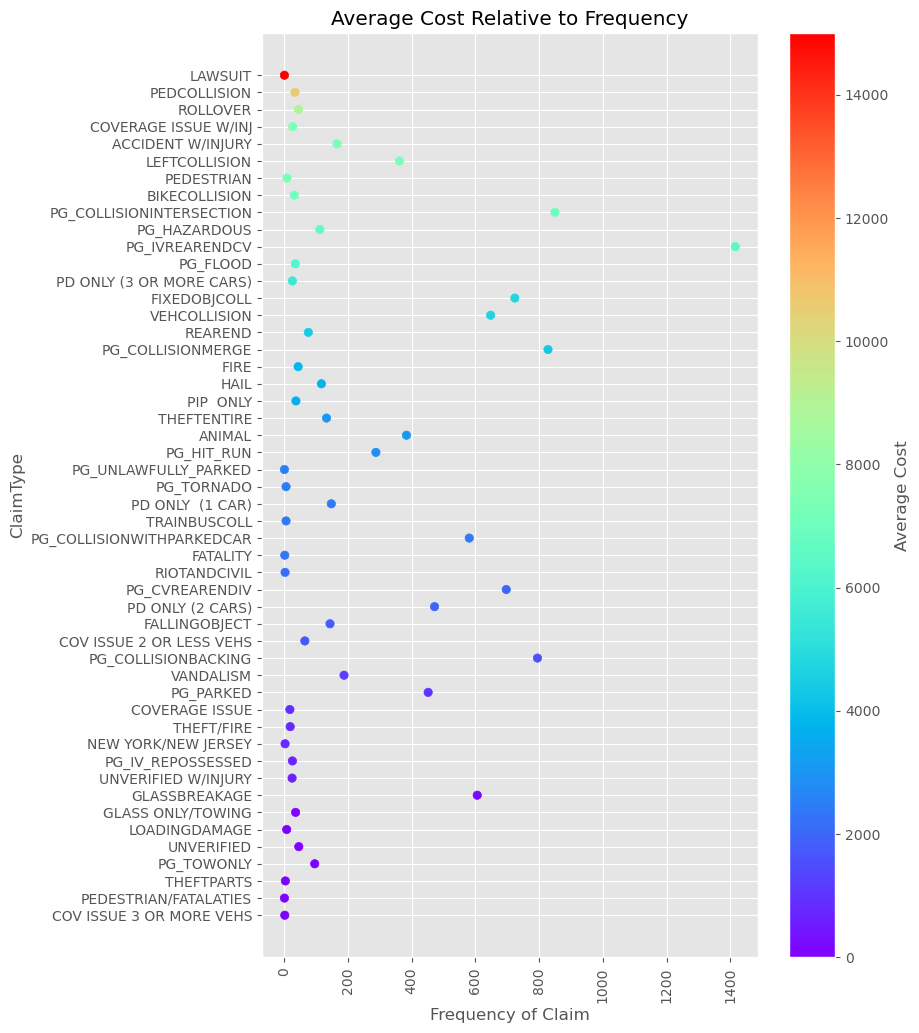

In [84]:
sorted_df = claim_type.sort_values(by='AvgLossPerClaim', ascending=True)
plt.figure(figsize=(8,12))
plt.scatter(sorted_df['count'],sorted_df['ClaimType'],  c=sorted_df['AvgLossPerClaim'], cmap='rainbow', marker='o')
plt.colorbar(label='Average Cost')
plt.xlabel('Frequency of Claim')
plt.xticks(rotation=90)
plt.ylabel('ClaimType')
plt.title('Average Cost Relative to Frequency')

Analysis
- As seen in this chart, pushing the values at the top as close to the left as possible would be an ideal strategy. Rear Ending by insured vehicles and left collisions are two large frequency large cost items

Text(0.5, 1.0, 'Total Cost Relative to Frequency')

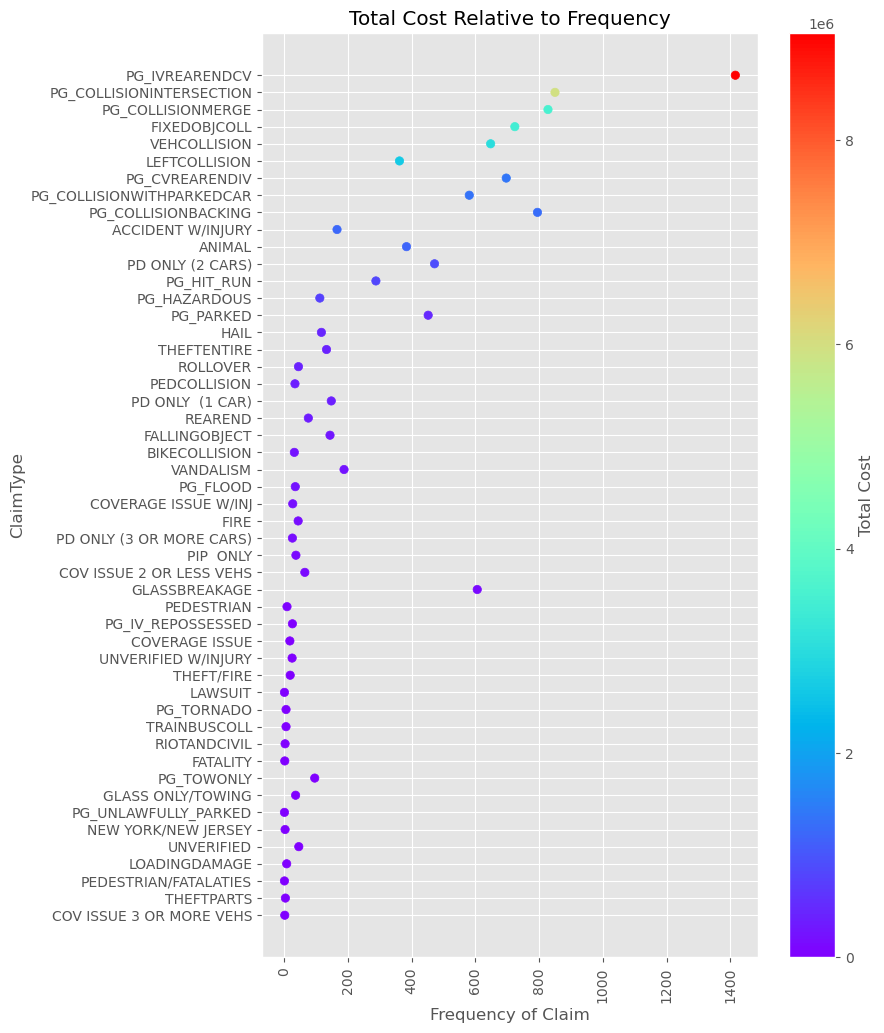

In [85]:
sorted_df = claim_type.sort_values(by='TotalLosses', ascending=True)
plt.figure(figsize=(8,12))
plt.scatter(sorted_df['count'],sorted_df['ClaimType'],  c=sorted_df['TotalLosses'], cmap='rainbow', marker='o')
plt.colorbar(label='Total Cost')
plt.xlabel('Frequency of Claim')
plt.xticks(rotation=90)
plt.ylabel('ClaimType')
plt.title('Total Cost Relative to Frequency')

This is another way of looking at those factors, with the total cost now represented by the hue. Merging, intersections, and rearending are all high cost, high frequency claims. Modelling the area where a potential claimant lives and drives to work could provide a way to estimate the liklihood that they file one of these claims. 

### What is the breakdown of At Fault Descriptions?  

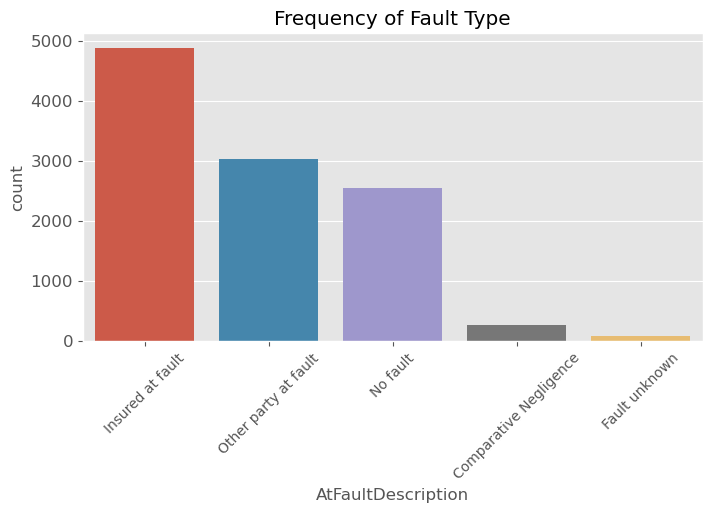

In [86]:
order = df_ClaimMasterTrans['AtFaultDescription'].value_counts().index
plt.figure(figsize=(8,4))
sns.countplot(x='AtFaultDescription',data=df_ClaimMasterTrans, order=order)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.title('Frequency of Fault Type')
plt.show()

### What is paid out for each category? 

In [87]:
at_fault_count = df_ClaimMasterTrans['AtFaultDescription'].value_counts()

at_fault_count.reset_index()
at_fault_count.columns = ['AtFaultDescription', 'Count']

df_fault_type = pd.DataFrame(at_fault_count)

In [88]:
paid_loss_by_fault_type = df_ClaimMasterTrans.groupby('AtFaultDescription')['ClaimTransPaidLoss'].sum().reset_index()


In [89]:
df_fault_type = pd.merge(df_fault_type, paid_loss_by_fault_type, on='AtFaultDescription',how='left')
df_fault_type = df_fault_type.rename(columns = {'ClaimTransPaidLoss': 'Total_Losses'})

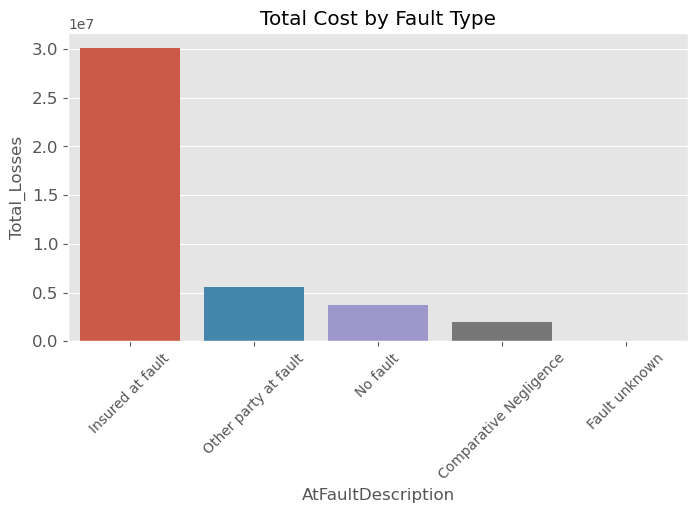

In [90]:
order = df_fault_type['AtFaultDescription'].value_counts().index
plt.figure(figsize=(8,4))
sns.barplot(x='AtFaultDescription',y='Total_Losses',data=df_fault_type, order=order)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.title('Total Cost by Fault Type')
plt.show()

In [91]:
avg_loss_by_fault_type = df_ClaimMasterTrans.groupby('AtFaultDescription')['ClaimTransPaidLoss'].mean().reset_index()
df_fault_type = pd.merge(df_fault_type, avg_loss_by_fault_type, on='AtFaultDescription',how='left')

In [92]:
df_fault_type = df_fault_type.rename(columns = {'ClaimTransPaidLoss': 'AverageLoss'})

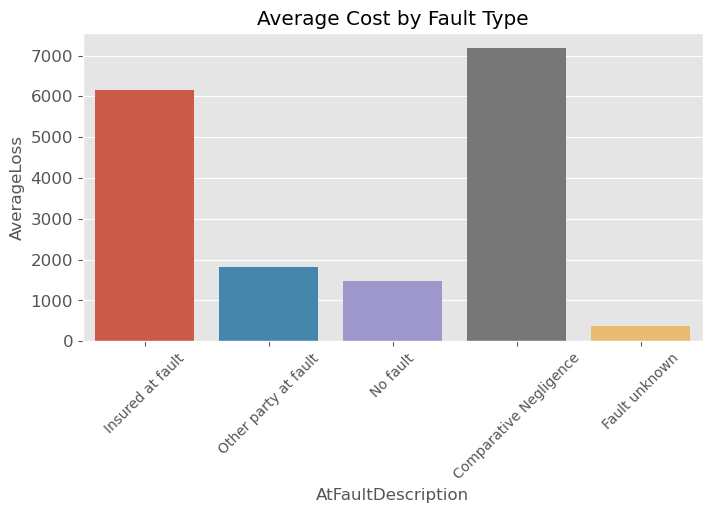

In [93]:
order = df_fault_type['AtFaultDescription'].value_counts().index
plt.figure(figsize=(8,4))
sns.barplot(x='AtFaultDescription',y='AverageLoss',data=df_fault_type, order=order)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.title('Average Cost by Fault Type')
plt.show()

#### Summary
This section explored the relationship between At Fault Description and Claims. Frankly the insights were a little obvious. The highest cost and most frequent cost to us were the cases where the person who is insured was at fault. The comparative negligence case is likely due to very high cost legal issues such as manslaughter or a fatality. 

## How does time relate to claims? 

In [94]:
# Generate the Season Column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

In [95]:
df_ClaimTime = df_ClaimMasterTrans

df_ClaimTime.loc[:,'MonthLoss'] = df_ClaimTime['DateOfLoss'].dt.month
df_ClaimTime.loc[:,'DayOfWeek'] = df_ClaimTime['DateOfLoss'].dt.dayofweek #Monday is 0 Sunday is 6
df_ClaimTime.loc[:,'DayOfWeek'] = df_ClaimTime['DayOfWeek'].apply(lambda x: calendar.day_abbr[x])
df_ClaimTime.loc[:,'Season'] = df_ClaimTime['MonthLoss'].apply(get_season)

C:\Users\j8k-o\AppData\Local\Temp\ipykernel_6432\4126000743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ClaimTime.loc[:,'MonthLoss'] = df_ClaimTime['DateOfLoss'].dt.month
C:\Users\j8k-o\AppData\Local\Temp\ipykernel_6432\4126000743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ClaimTime.loc[:,'DayOfWeek'] = df_ClaimTime['DateOfLoss'].dt.dayofweek #Monday is 0 Sunday is 6
C:\Users\j8k-o\AppData\Local\Temp\ipykernel_6432\4126000743.py:6: SettingWithCopyWarning: 
A value is trying to be set 

### How do the months relate to filing claims? 

In [96]:
#Grouping by Months
df_claimMonthsTotal = df_ClaimTime.groupby('MonthLoss')['ClaimTransPaidLoss'].sum().reset_index()
df_claimMonthsAverage = df_ClaimTime.groupby('MonthLoss')['ClaimTransPaidLoss'].mean().reset_index()
df_claimMonthsCount = df_ClaimTime.groupby('MonthLoss')['ClaimTransPaidLoss'].count().reset_index()
df_claimMonthsDaysToClaim = df_ClaimTime.groupby('MonthLoss')['DaysToClaim'].mean().reset_index()

df_claimMonthsTotal = df_claimMonthsTotal.rename(columns = {'ClaimTransPaidLoss': 'TotalMonthlyLoss'})
df_claimMonthsAverage = df_claimMonthsAverage.rename(columns = {'ClaimTransPaidLoss': 'AverageMonthlyLoss'})
df_claimMonthsCount = df_claimMonthsCount.rename(columns = {'ClaimTransPaidLoss': 'Count'})
df_claimMonthsDaysToClaim = df_claimMonthsDaysToClaim.rename(columns = {'DaysToClaim': 'AvgDaystoClaim'})

df_claimMonths = pd.merge(df_claimMonthsTotal, df_claimMonthsAverage, on='MonthLoss',how='left')
df_claimMonths = pd.merge(df_claimMonths, df_claimMonthsCount, on='MonthLoss',how='left')
df_claimMonths = pd.merge(df_claimMonths, df_claimMonthsDaysToClaim, on='MonthLoss',how='left')
df_claimMonths.loc[:,'MonthLossAbbr'] = df_claimMonths['MonthLoss'].apply(lambda x: calendar.month_abbr[x])


In [97]:
#Plot the Totals for each month sorted by amount of total Loss
df_claimMonths_sortedTotal = df_claimMonths.sort_values('TotalMonthlyLoss', ascending=False)
df_claimMonths_sortedAvg = df_claimMonths.sort_values('AverageMonthlyLoss', ascending=False)
df_claimMonths_sortedCount = df_claimMonths.sort_values('Count', ascending=False)
df_claimMonths_sortedDaysToClaim = df_claimMonths.sort_values('AvgDaystoClaim', ascending=False)



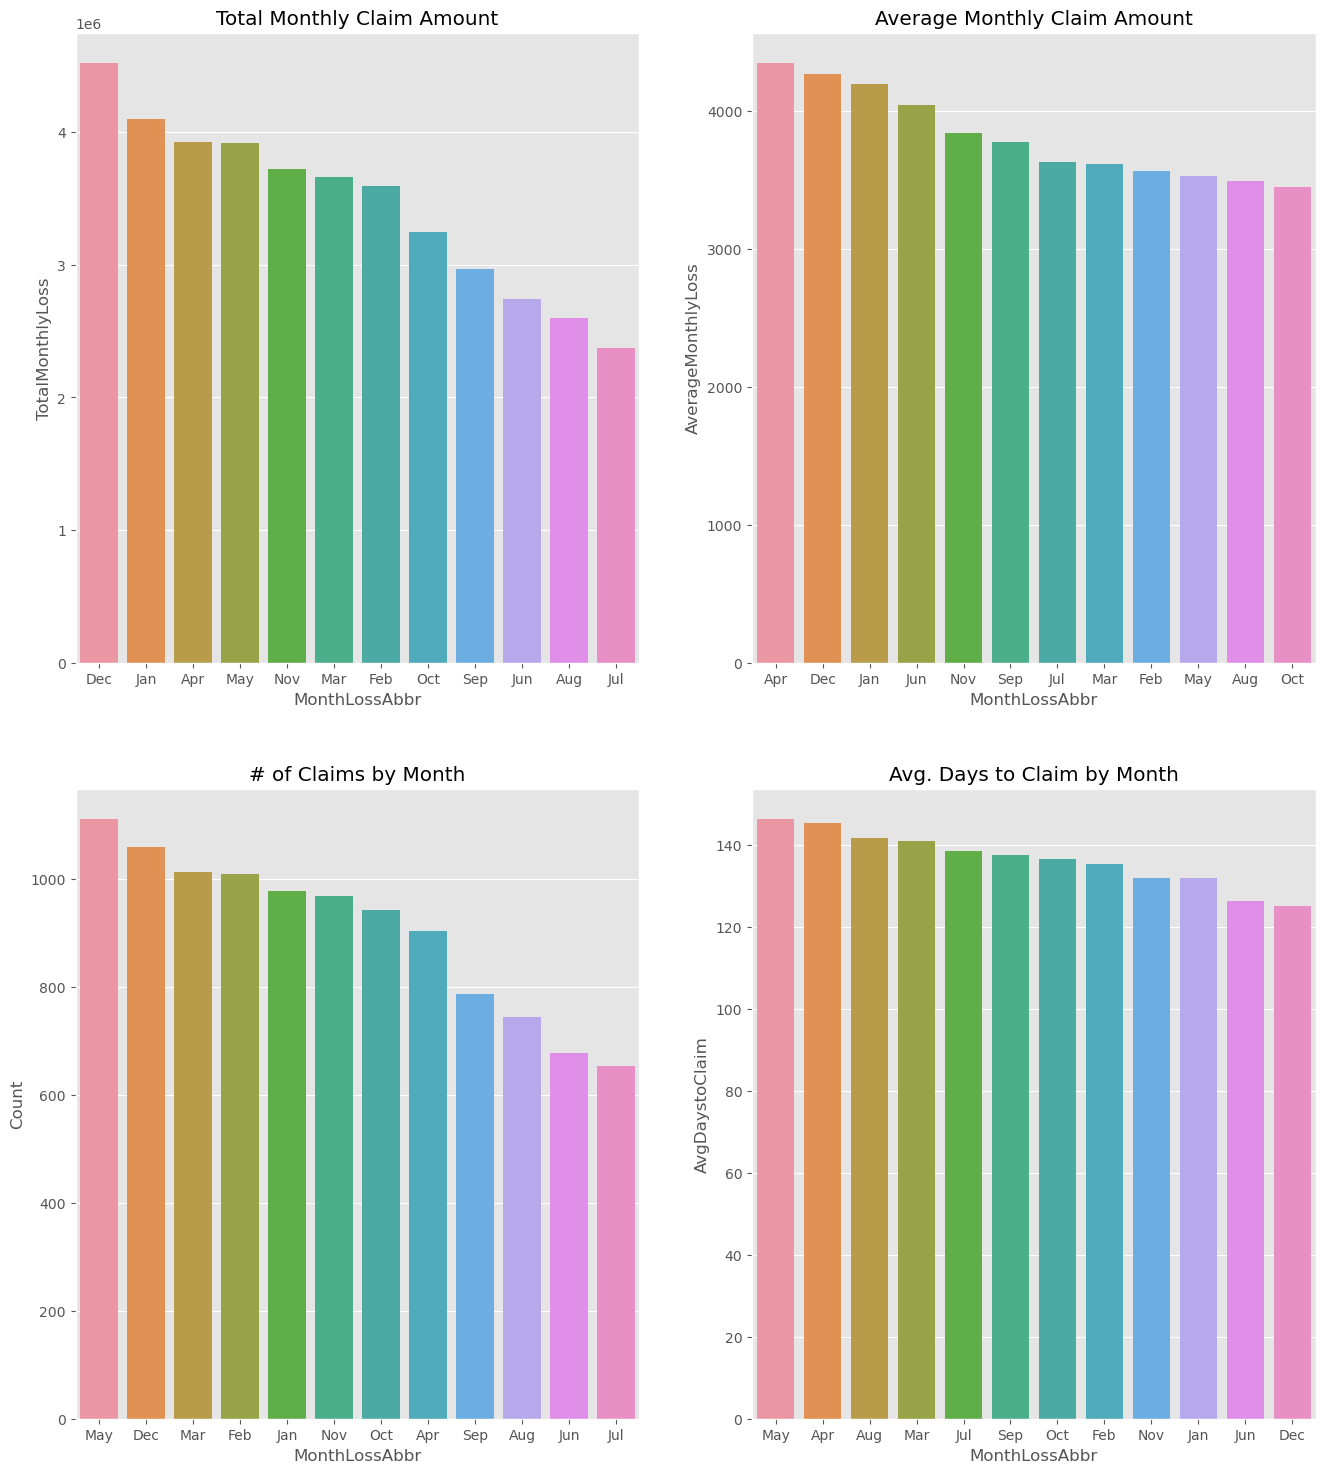

In [98]:
fig, axes = plt.subplots(2, 2, figsize=(16, 18))

# Total Monthly Claim Amount
sns.barplot(y='TotalMonthlyLoss', x='MonthLossAbbr', data=df_claimMonths_sortedTotal, ax=axes[0, 0])
axes[0, 0].set_title('Total Monthly Claim Amount')

# Average Monthly Claim Amount
sns.barplot(y='AverageMonthlyLoss', x='MonthLossAbbr', data=df_claimMonths_sortedAvg, ax=axes[0, 1])
axes[0, 1].set_title('Average Monthly Claim Amount')

# # of Claims by Month
sns.barplot(y='Count', x='MonthLossAbbr', data=df_claimMonths_sortedCount, ax=axes[1, 0])
axes[1, 0].set_title('# of Claims by Month')

# Avg Days to Claim by Month
sns.barplot(y='AvgDaystoClaim', x='MonthLossAbbr', data=df_claimMonths_sortedDaysToClaim, ax=axes[1, 1])
axes[1, 1].set_title('Avg. Days to Claim by Month')


#fig.suptitle('Monthly Breakdown of Claims - Overall', fontsize=16)

plt.show()


### Summary
- This was very interesting. The highest claim times occur in the rain and snow of Winter and Spring. The lowest claim times are in the summer and fall. Therefore, it could be advantageous to our business if we can find ways to model prices to reflect the higher probability of a claim being filed between October and May. 
- It would be interesting to see this chart subdivided into regions in order to drill down to see if this changes in the south vs the north. I would have assumed that most claims would be filed in the summer due to the increased outdoor activity. 

### How do the Seasons relate to filing claims? 

In [99]:
#Grouping by Seasons
df_claimSeasonsTotalClaimAmount = df_ClaimTime.groupby('Season')['ClaimTransPaidLoss'].sum().reset_index()
df_claimSeasonsAvgClaimAmount = df_ClaimTime.groupby('Season')['ClaimTransPaidLoss'].mean().reset_index()
df_claimSeasonsCount= df_ClaimTime.groupby('Season')['ClaimTransPaidLoss'].count().reset_index()
df_claimSeasonsAvgDaysToClaim= df_ClaimTime.groupby('Season')['DaysToClaim'].mean().reset_index()

In [100]:
df_claimSeasonsTotalClaimAmount = df_claimSeasonsTotalClaimAmount.rename(columns = {'ClaimTransPaidLoss': 'TotalLosses'})
df_claimSeasonsAvgClaimAmount = df_claimSeasonsAvgClaimAmount.rename(columns = {'ClaimTransPaidLoss': 'AverageMonthlyLoss'})
df_claimSeasonsCount = df_claimSeasonsCount.rename(columns = {'ClaimTransPaidLoss': 'Count'})
df_claimSeasonsAvgDaysToClaim = df_claimSeasonsAvgDaysToClaim.rename(columns = {'DaysToClaim': 'AvgDaystoClaim'})

In [101]:
df_claimSeasons = pd.merge(df_claimSeasonsTotalClaimAmount, df_claimSeasonsAvgClaimAmount, on='Season',how='left')
df_claimSeasons = pd.merge(df_claimSeasons, df_claimSeasonsCount, on='Season',how='left')
df_claimSeasons = pd.merge(df_claimSeasons, df_claimSeasonsAvgDaysToClaim, on='Season',how='left')

In [102]:
#Plot the Totals for each month sorted by amount of total Loss
df_claimSeasonsTotalClaimAmount = df_claimSeasons.sort_values('TotalLosses', ascending=False)
df_claimSeasonsAvgClaimAmount = df_claimSeasons.sort_values('AverageMonthlyLoss', ascending=False)
df_claimSeasonsCount = df_claimSeasons.sort_values('Count', ascending=False)
df_claimSeasonsAvgDaysToClaim = df_claimSeasons.sort_values('AvgDaystoClaim', ascending=False)


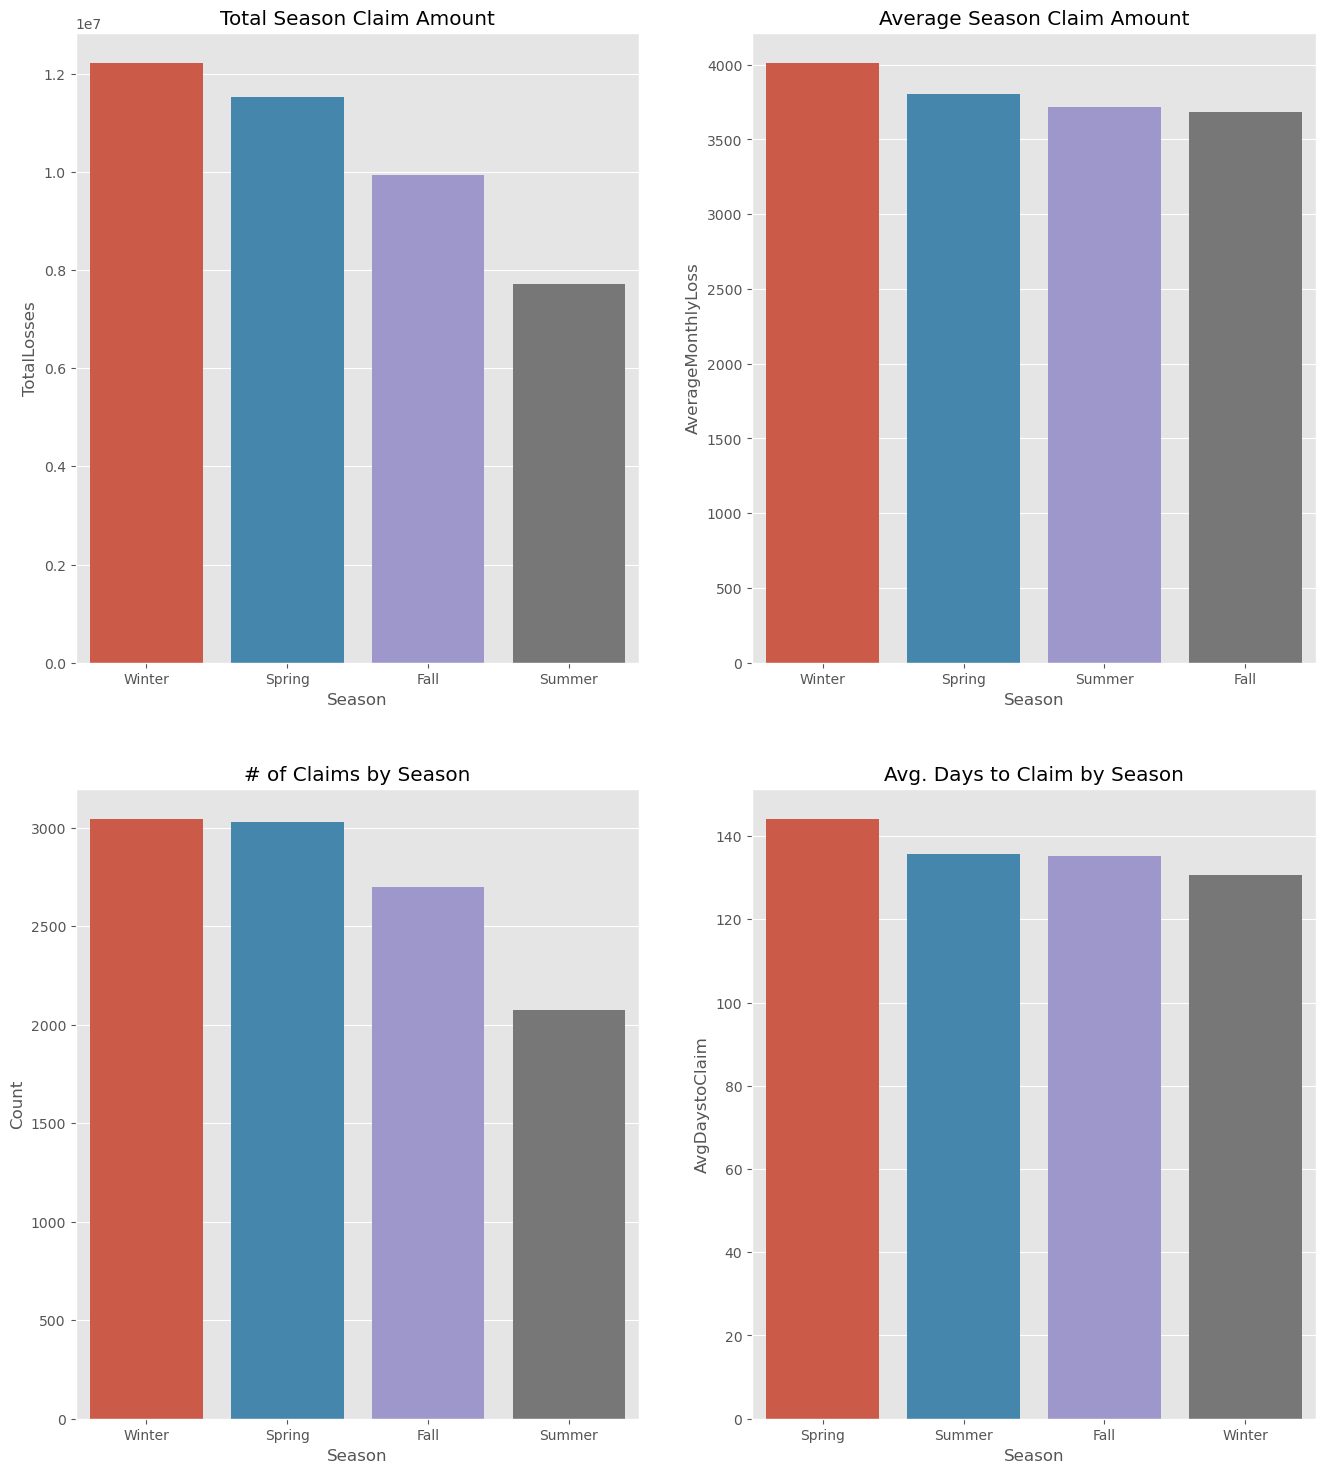

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(16, 18))

# Total Monthly Claim Amount
sns.barplot(y='TotalLosses', x='Season', data=df_claimSeasonsTotalClaimAmount, ax=axes[0, 0])
axes[0, 0].set_title('Total Season Claim Amount')

# Average Monthly Claim Amount
sns.barplot(y='AverageMonthlyLoss', x='Season', data=df_claimSeasonsAvgClaimAmount, ax=axes[0, 1])
axes[0, 1].set_title('Average Season Claim Amount')

# # of Claims by Month
sns.barplot(y='Count', x='Season', data=df_claimSeasonsCount, ax=axes[1, 0])
axes[1, 0].set_title('# of Claims by Season')

# Avg Days to Claim by Month
sns.barplot(y='AvgDaystoClaim', x='Season', data=df_claimSeasonsAvgDaysToClaim, ax=axes[1, 1])
axes[1, 1].set_title('Avg. Days to Claim by Season')

#fig.suptitle('Monthly Breakdown of Claims - Overall', fontsize=16)

plt.show()

### Summary
- This data shows exactly what was just mentioned. The Winter and Spring are the high cost times of year for claims. 
- Finding ways to minimize the effects of the season could provide an opportunity to lessen overall paid losses. 

### How does the Day of the Week relate to the filing of Claims? 

In [104]:
#Grouping by Day of the Week
df_claimDayOfWeekTotal = df_ClaimTime.groupby('DayOfWeek')['ClaimTransPaidLoss'].sum().reset_index()
df_claimDayOfWeekAverage = df_ClaimTime.groupby('DayOfWeek')['ClaimTransPaidLoss'].mean().reset_index()
df_claimDayOfWeekCount = df_ClaimTime.groupby('DayOfWeek')['ClaimTransPaidLoss'].count().reset_index()
df_claimDayOfWeekDaysToClaim = df_ClaimTime.groupby('DayOfWeek')['DaysToClaim'].mean().reset_index()

df_claimDayOfWeekTotal = df_claimDayOfWeekTotal.rename(columns = {'ClaimTransPaidLoss': 'TotalDailyLoss'})
df_claimDayOfWeekAverage = df_claimDayOfWeekAverage.rename(columns = {'ClaimTransPaidLoss': 'AverageDailyLoss'})
df_claimDayOfWeekCount = df_claimDayOfWeekCount.rename(columns = {'ClaimTransPaidLoss': 'Count'})
df_claimDayOfWeekDaysToClaim = df_claimDayOfWeekDaysToClaim.rename(columns = {'DaysToClaim': 'AvgDaystoClaim'})

df_claimDayOfWeek = pd.merge(df_claimDayOfWeekTotal, df_claimDayOfWeekAverage, on='DayOfWeek',how='left')
df_claimDayOfWeek = pd.merge(df_claimDayOfWeek, df_claimDayOfWeekCount, on='DayOfWeek',how='left')
df_claimDayOfWeek = pd.merge(df_claimDayOfWeek, df_claimDayOfWeekDaysToClaim, on='DayOfWeek',how='left')
#df_claimDayOfWeek.loc[:,'DayOfWeekAbbr'] = df_claimDayOfWeek['DayOfWeek'].apply(lambda x: calendar.day_abbr[x])


In [105]:
#Plot the Totals for each day of week sorted
df_claimDayOfWeek_sortedTotal = df_claimDayOfWeek.sort_values('TotalDailyLoss', ascending=False)
df_claimDayOfWeek_sortedAvg = df_claimDayOfWeek.sort_values('AverageDailyLoss', ascending=False)
df_claimDayOfWeek_sortedCount = df_claimDayOfWeek.sort_values('Count', ascending=False)
df_claimDayOfWeek_sortedDaysToClaim = df_claimDayOfWeek.sort_values('AvgDaystoClaim', ascending=False)


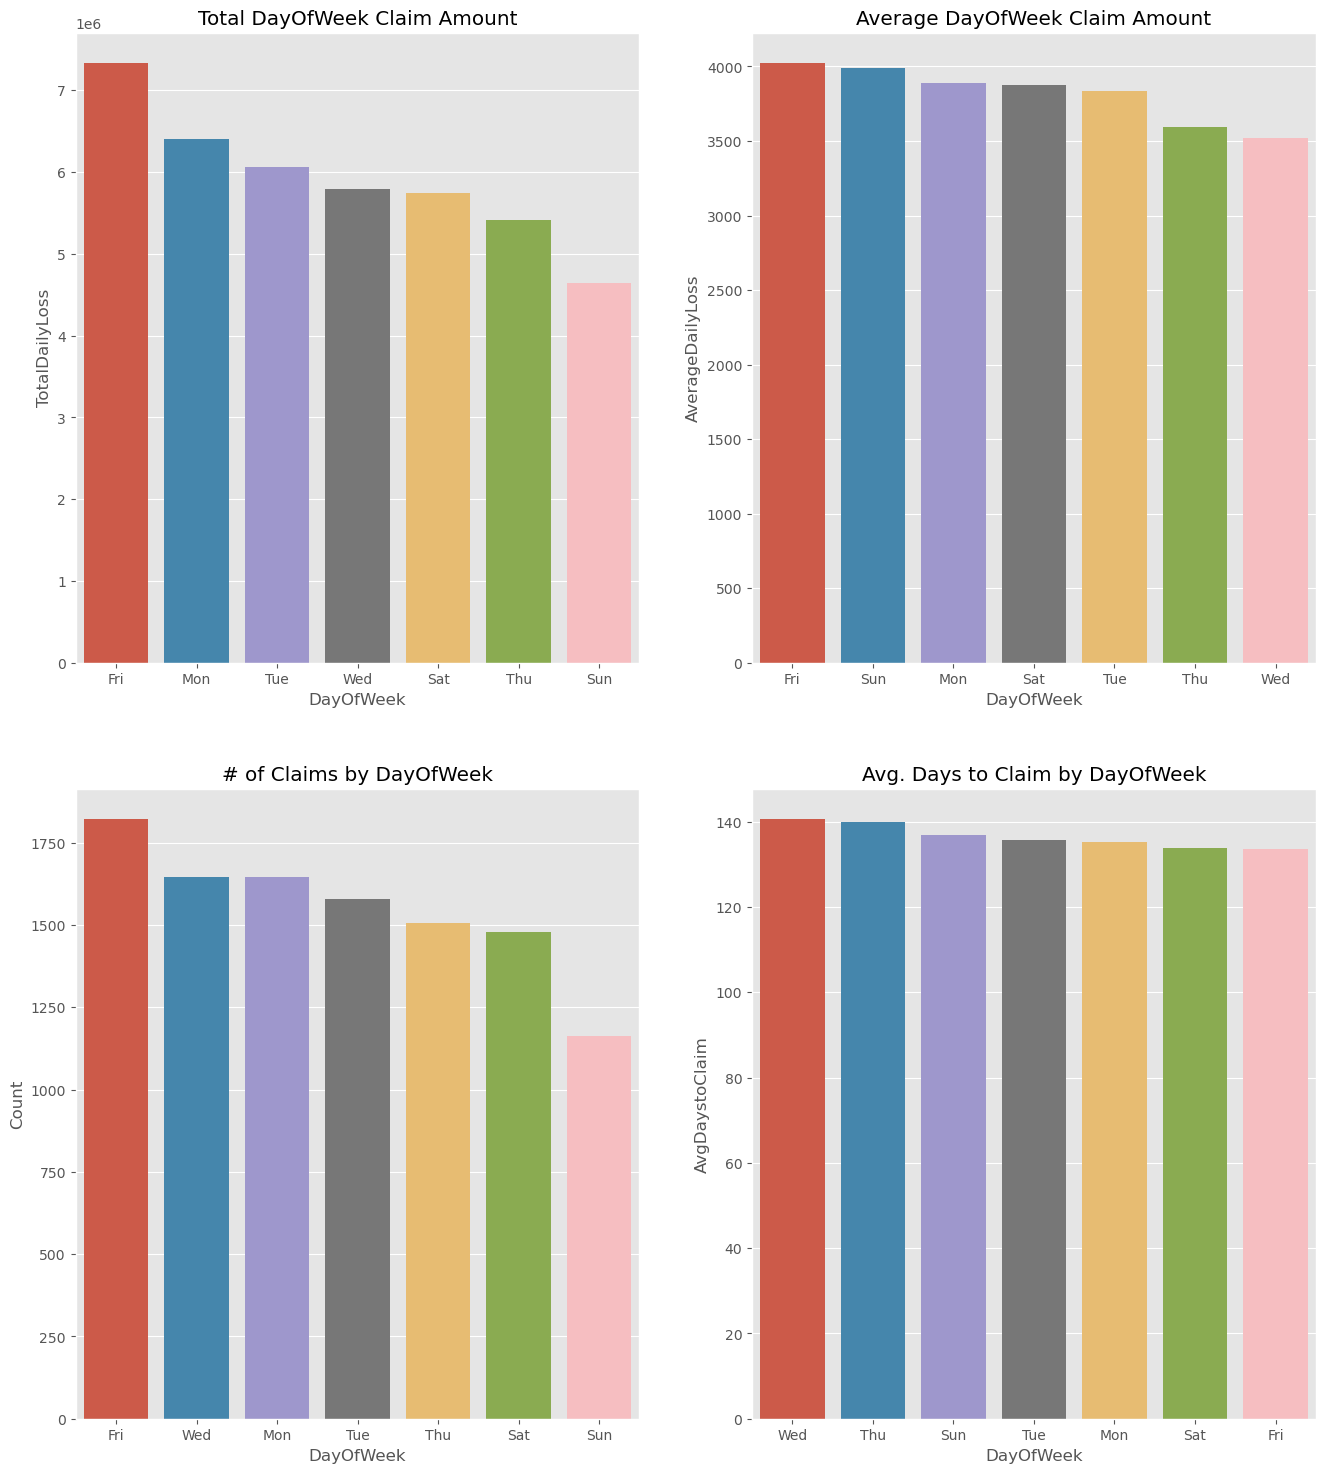

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(16, 18))

# Total DayOfWeek Claim Amount
sns.barplot(y='TotalDailyLoss', x='DayOfWeek', data=df_claimDayOfWeek_sortedTotal, ax=axes[0, 0])
axes[0, 0].set_title('Total DayOfWeek Claim Amount')

# Average DayOfWeek Claim Amount
sns.barplot(y='AverageDailyLoss', x='DayOfWeek', data=df_claimDayOfWeek_sortedAvg, ax=axes[0, 1])
axes[0, 1].set_title('Average DayOfWeek Claim Amount')

# # of Claims by DayOfWeek
sns.barplot(y='Count', x='DayOfWeek', data=df_claimDayOfWeek_sortedCount, ax=axes[1, 0])
axes[1, 0].set_title('# of Claims by DayOfWeek')

# Avg Days to Claim by DayOfWeek
sns.barplot(y='AvgDaystoClaim', x='DayOfWeek', data=df_claimDayOfWeek_sortedDaysToClaim, ax=axes[1, 1])
axes[1, 1].set_title('Avg. Days to Claim by DayOfWeek')

#fig.suptitle('DayOfWeek Breakdown of Claims - Overall', fontsize=16)

plt.show()

### Summary
- This was interesting, because it indicates that the workweek has the most often claims. But the weekend has the highest cost on average. I assume this is because the work week likely involves more small time accidents, while weekends involve more serious ones. 

### What is the relationship between Policy State and filing of claims?  

In [107]:
df_ClaimMasterTrans = df_ClaimMasterTrans[df_ClaimMasterTrans['PolicyStateCode'] != 'UC']


df_StateCount = df_ClaimMasterTrans.groupby('PolicyStateCode')['ClaimTransPaidLoss'].count().reset_index(name='Count')
df_StateTotal = df_ClaimMasterTrans.groupby('PolicyStateCode')['ClaimTransPaidLoss'].sum().reset_index(name='TotalLoss')
df_StateAvg = df_ClaimMasterTrans.groupby('PolicyStateCode')['ClaimTransPaidLoss'].mean().reset_index(name='AverageLoss')
df_State_AvgDaystoClaim = df_ClaimMasterTrans.groupby('PolicyStateCode')['DaysToClaim'].mean().reset_index(name ='AvgDayToClaim')

df_LossStateCount = df_ClaimMasterTrans.groupby('LossState')['ClaimTransPaidLoss'].count().reset_index(name='Count')
df_LossStateTotal = df_ClaimMasterTrans.groupby('LossState')['ClaimTransPaidLoss'].sum().reset_index(name='TotalLoss')
df_LossStateAvg = df_ClaimMasterTrans.groupby('LossState')['ClaimTransPaidLoss'].mean().reset_index(name='AverageLoss')
df_LossState_AvgDaystoClaim = df_ClaimMasterTrans.groupby('LossState')['DaysToClaim'].mean().reset_index(name ='AvgDayToClaim')

In [108]:
df_State = pd.merge(df_StateCount,df_StateTotal, on='PolicyStateCode',how='left')
df_State = pd.merge(df_State, df_StateAvg, on='PolicyStateCode',how='left')
df_State = pd.merge(df_State, df_State_AvgDaystoClaim, on='PolicyStateCode',how='left')


df_LossState = pd.merge(df_LossStateCount,df_LossStateTotal, on='LossState',how='left')
df_LossState = pd.merge(df_LossState, df_LossStateAvg, on='LossState',how='left')
df_LossState = pd.merge(df_LossState, df_LossState_AvgDaystoClaim, on='LossState',how='left')


In [109]:
df_State_sortedTotal = df_State.sort_values('TotalLoss', ascending=False)
df_State_sortedAvg = df_State.sort_values('AverageLoss', ascending=False)
df_State_sortedCount = df_State.sort_values('Count', ascending=False)
df_State_sortedAvgDay = df_State.sort_values('AvgDayToClaim', ascending=False)

df_LossState_sortedTotal = df_LossState.sort_values('TotalLoss', ascending=False)
df_LossState_sortedAvg = df_LossState.sort_values('AverageLoss', ascending=False)
df_LossState_sortedCount = df_LossState.sort_values('Count', ascending=False)
df_LossState_sortedAvgDay = df_LossState.sort_values('AvgDayToClaim', ascending=False)

### Policy State

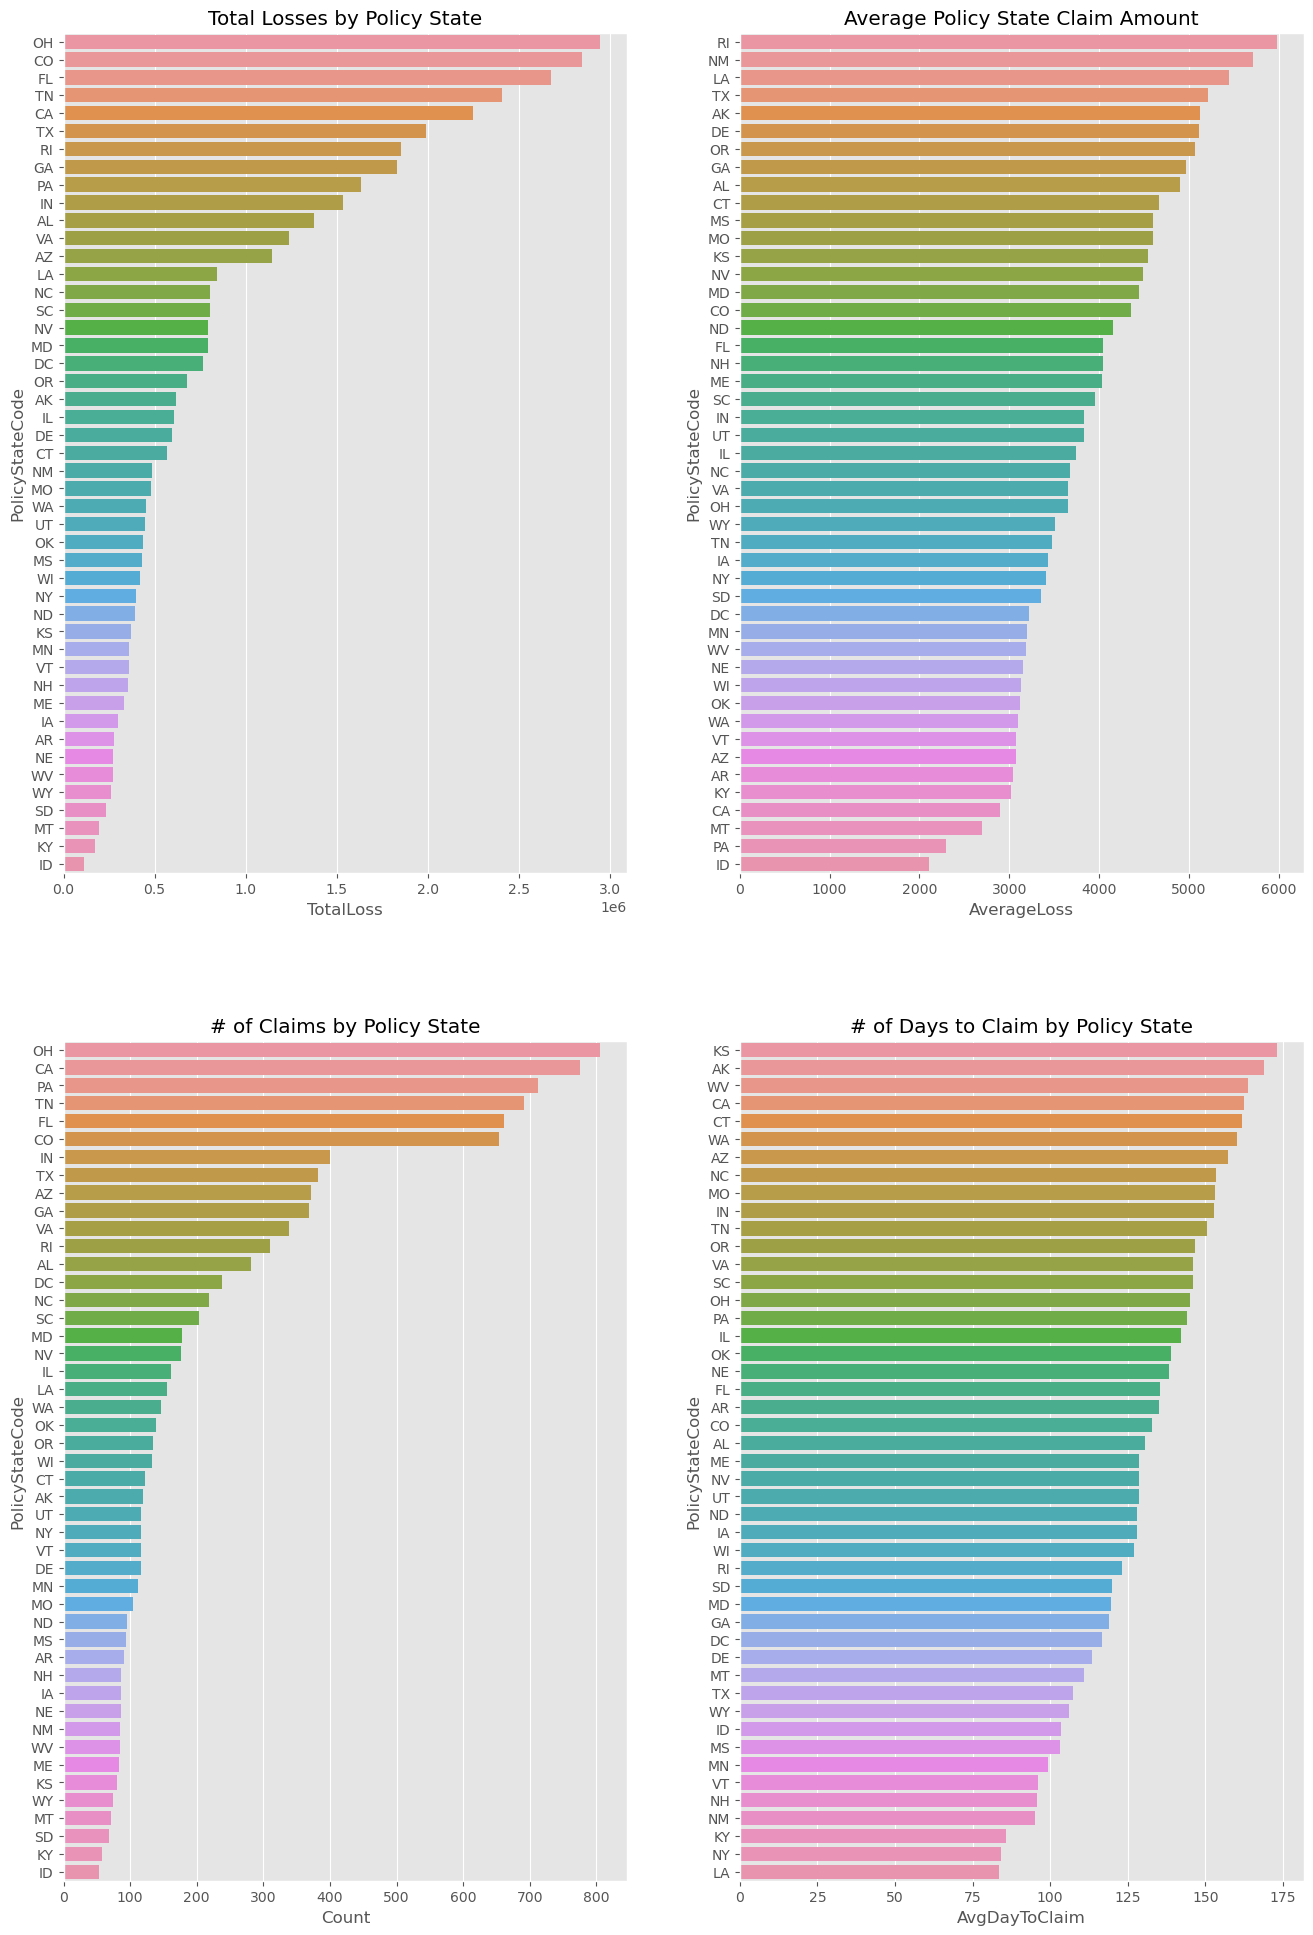

In [110]:

fig, axes = plt.subplots(2, 2, figsize=(16, 24))

# Total State Claim Amount
sns.barplot(x='TotalLoss', y='PolicyStateCode', data=df_State_sortedTotal,ax=axes[0, 0])
axes[0, 0].set_title('Total Losses by Policy State')

# Average State Claim Amount
sns.barplot(x='AverageLoss', y='PolicyStateCode', data=df_State_sortedAvg, ax=axes[0, 1])
axes[0, 1].set_title('Average Policy State Claim Amount')

# # of Claims by State
sns.barplot(x='Count', y='PolicyStateCode', data=df_State_sortedCount, ax=axes[1, 0])
axes[1, 0].set_title('# of Claims by Policy State')

# Avg Days to Claim by State
sns.barplot(x='AvgDayToClaim', y='PolicyStateCode', data=df_State_sortedAvgDay, ax=axes[1, 1])
axes[1, 1].set_title('# of Days to Claim by Policy State')


plt.show()

### Loss State

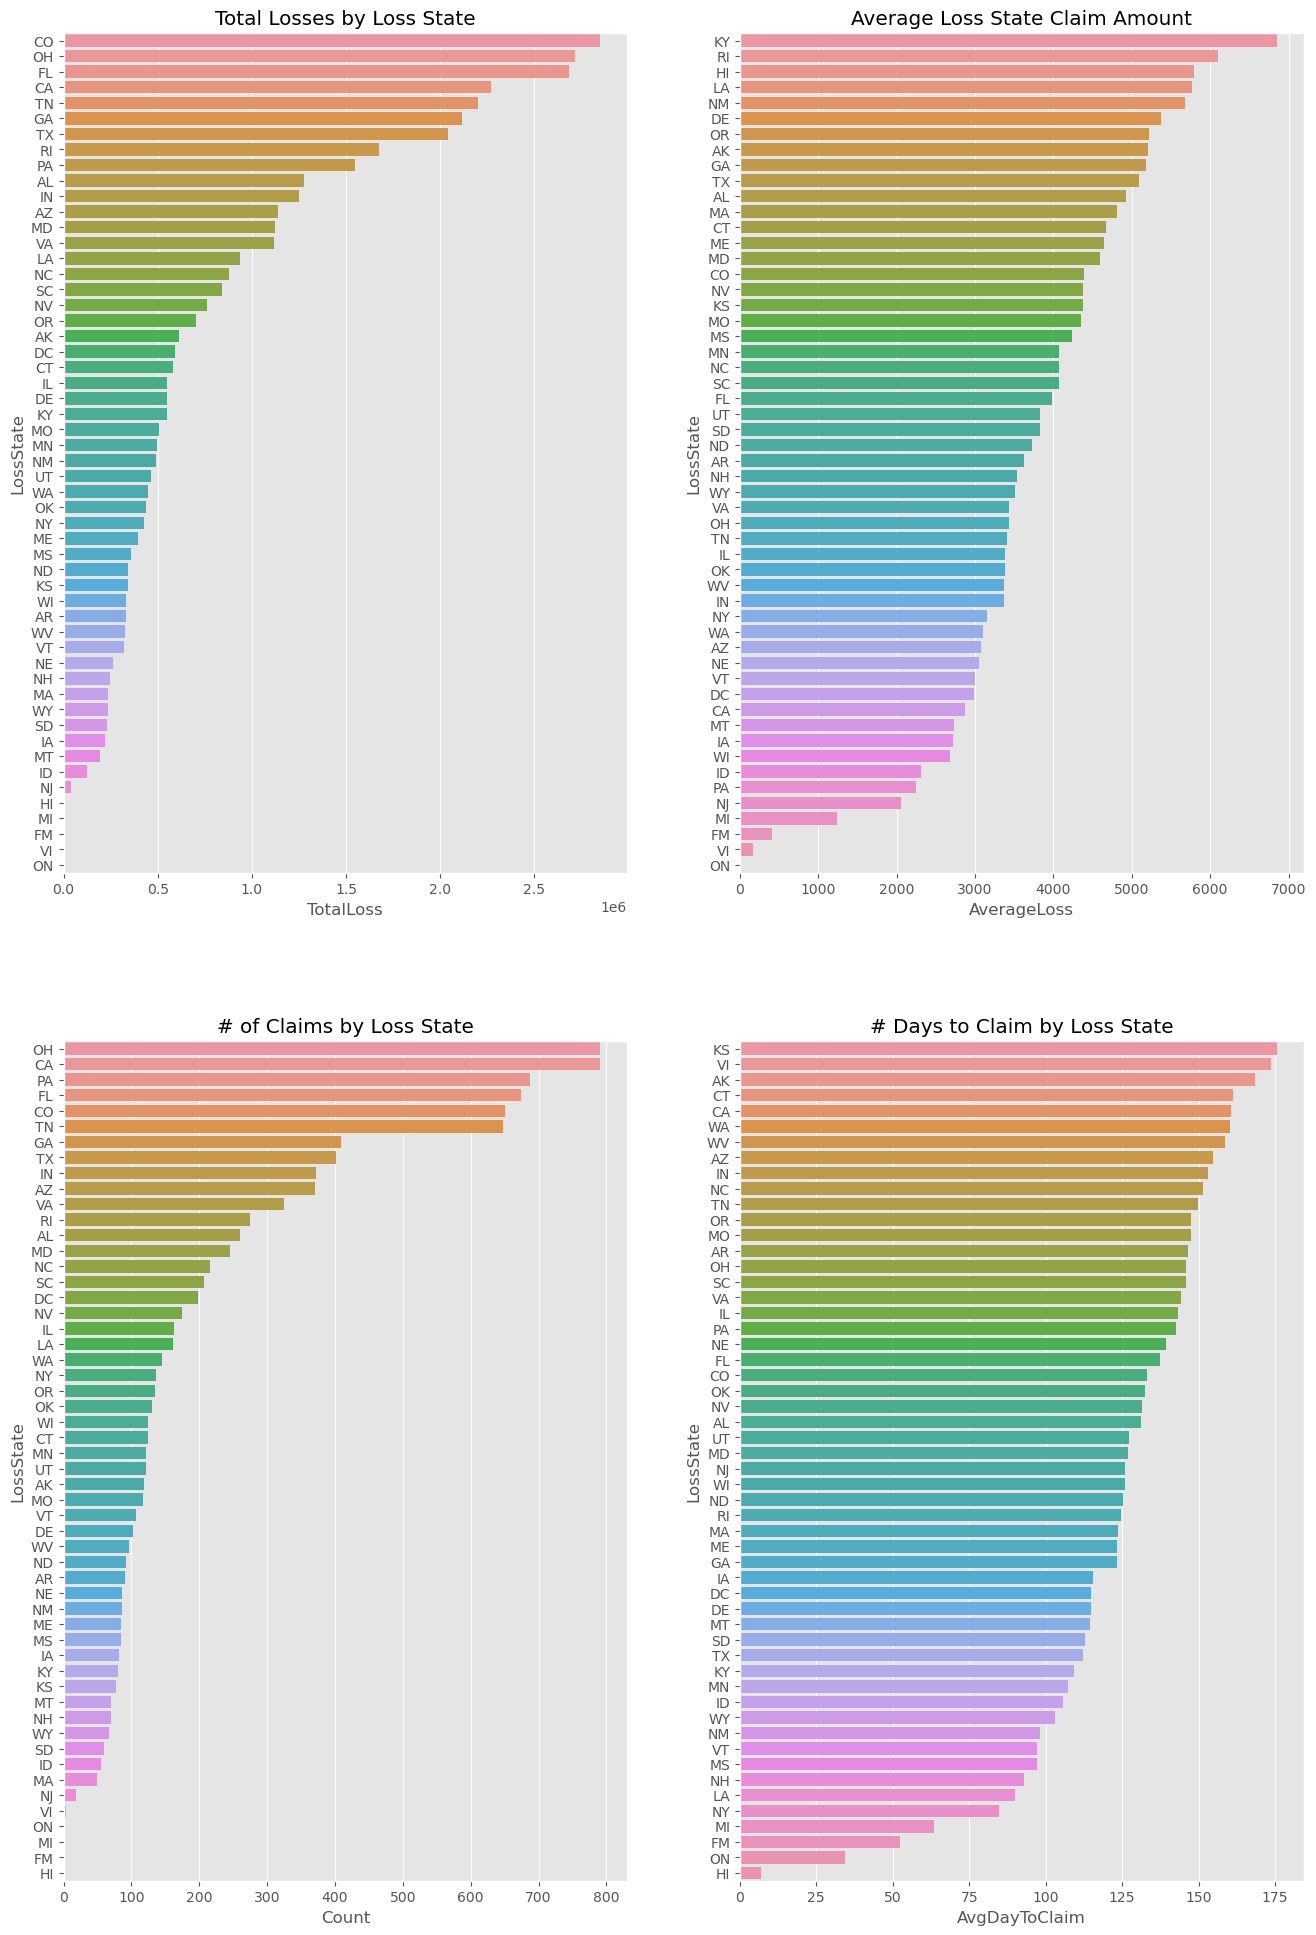

In [111]:

fig, axes = plt.subplots(2, 2, figsize=(16, 24))

# Total DayOfWeek Claim Amount
sns.barplot(x='TotalLoss', y='LossState', data=df_LossState_sortedTotal,ax=axes[0, 0])
axes[0, 0].set_title('Total Losses by Loss State')

# Average DayOfWeek Claim Amount
sns.barplot(x='AverageLoss', y='LossState', data=df_LossState_sortedAvg, ax=axes[0, 1])
axes[0, 1].set_title('Average Loss State Claim Amount')

# # of Claims by DayOfWeek
sns.barplot(x='Count', y='LossState', data=df_LossState_sortedCount, ax=axes[1, 0])
axes[1, 0].set_title('# of Claims by Loss State')

sns.barplot(x='AvgDayToClaim', y='LossState', data=df_LossState_sortedAvgDay, ax=axes[1, 1])
axes[1, 1].set_title('# Days to Claim by Loss State')

plt.show()

### Summary
- This data shows the highest average claim amount per state and the average amount of time until a claim is filed. This is useful because it gives us an idea of the driving conditions in the state. 
- Further analysis needs to be done to take the state of all policies and show the relative percentage and number of filed per policy holder in the state. This could provide interesting value to The General, as they can identify where to focus their marketing and growing their business. They could also identify particular geographic regions that are not ideal for their business. 

### Analyze the Regions relationships to filing claims

In [112]:

state_to_region = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
    'Southeast': ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'SC', 'TN'],
    'NorthWest': ['CO', 'ID', 'MT', 'WY', 'AK', 'OR', 'WA'],
    'SouthWest': ['AZ','NV','NM','UT','CA', 'HI', 'TX'],
    'Mid-Atlantic': ['DE', 'MD', 'DC', 'NC', 'WV','VA'],

}

In [113]:
def get_region(state_code):
    for region, states in state_to_region.items():
        if state_code in states:
            return region
    return 'Unknown' 

In [114]:
df_ClaimMasterTrans.loc[:,'Region'] = df_ClaimMasterTrans['PolicyStateCode'].apply(get_region)

C:\Users\j8k-o\AppData\Local\Temp\ipykernel_6432\562762191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ClaimMasterTrans.loc[:,'Region'] = df_ClaimMasterTrans['PolicyStateCode'].apply(get_region)


In [115]:
df_RegionCount = df_ClaimMasterTrans.groupby('Region')['ClaimTransPaidLoss'].count().reset_index()
df_RegionTotal = df_ClaimMasterTrans.groupby('Region')['ClaimTransPaidLoss'].sum().reset_index()
df_RegionAvg = df_ClaimMasterTrans.groupby('Region')['ClaimTransPaidLoss'].mean().reset_index()
df_RegionDaysToClaim = df_ClaimMasterTrans.groupby('Region')['DaysToClaim'].mean().reset_index()

df_RegionCount = df_RegionCount.rename(columns = {'ClaimTransPaidLoss': 'Count'})
df_RegionTotal = df_RegionTotal.rename(columns = {'ClaimTransPaidLoss': 'TotalLoss'})
df_RegionAvg = df_RegionAvg.rename(columns = {'ClaimTransPaidLoss': 'AverageLoss'})
df_RegionDaysToClaim = df_RegionDaysToClaim.rename(columns = {'DaysToClaim': 'AvgDaysToClaim'})

df_Region = pd.merge(df_RegionCount,df_RegionTotal, on='Region',how='left')
df_Region = pd.merge(df_Region, df_RegionAvg, on='Region',how='left')
df_Region = pd.merge(df_Region, df_RegionDaysToClaim, on='Region',how='left')

In [116]:
df_Region_sortedTotal = df_Region.sort_values('TotalLoss', ascending=False)
df_Region_sortedAvg = df_Region.sort_values('AverageLoss', ascending=False)
df_Region_sortedcount = df_Region.sort_values('Count', ascending=False)
df_Region_sortedDaystoClaim = df_Region.sort_values('AvgDaysToClaim', ascending = False)

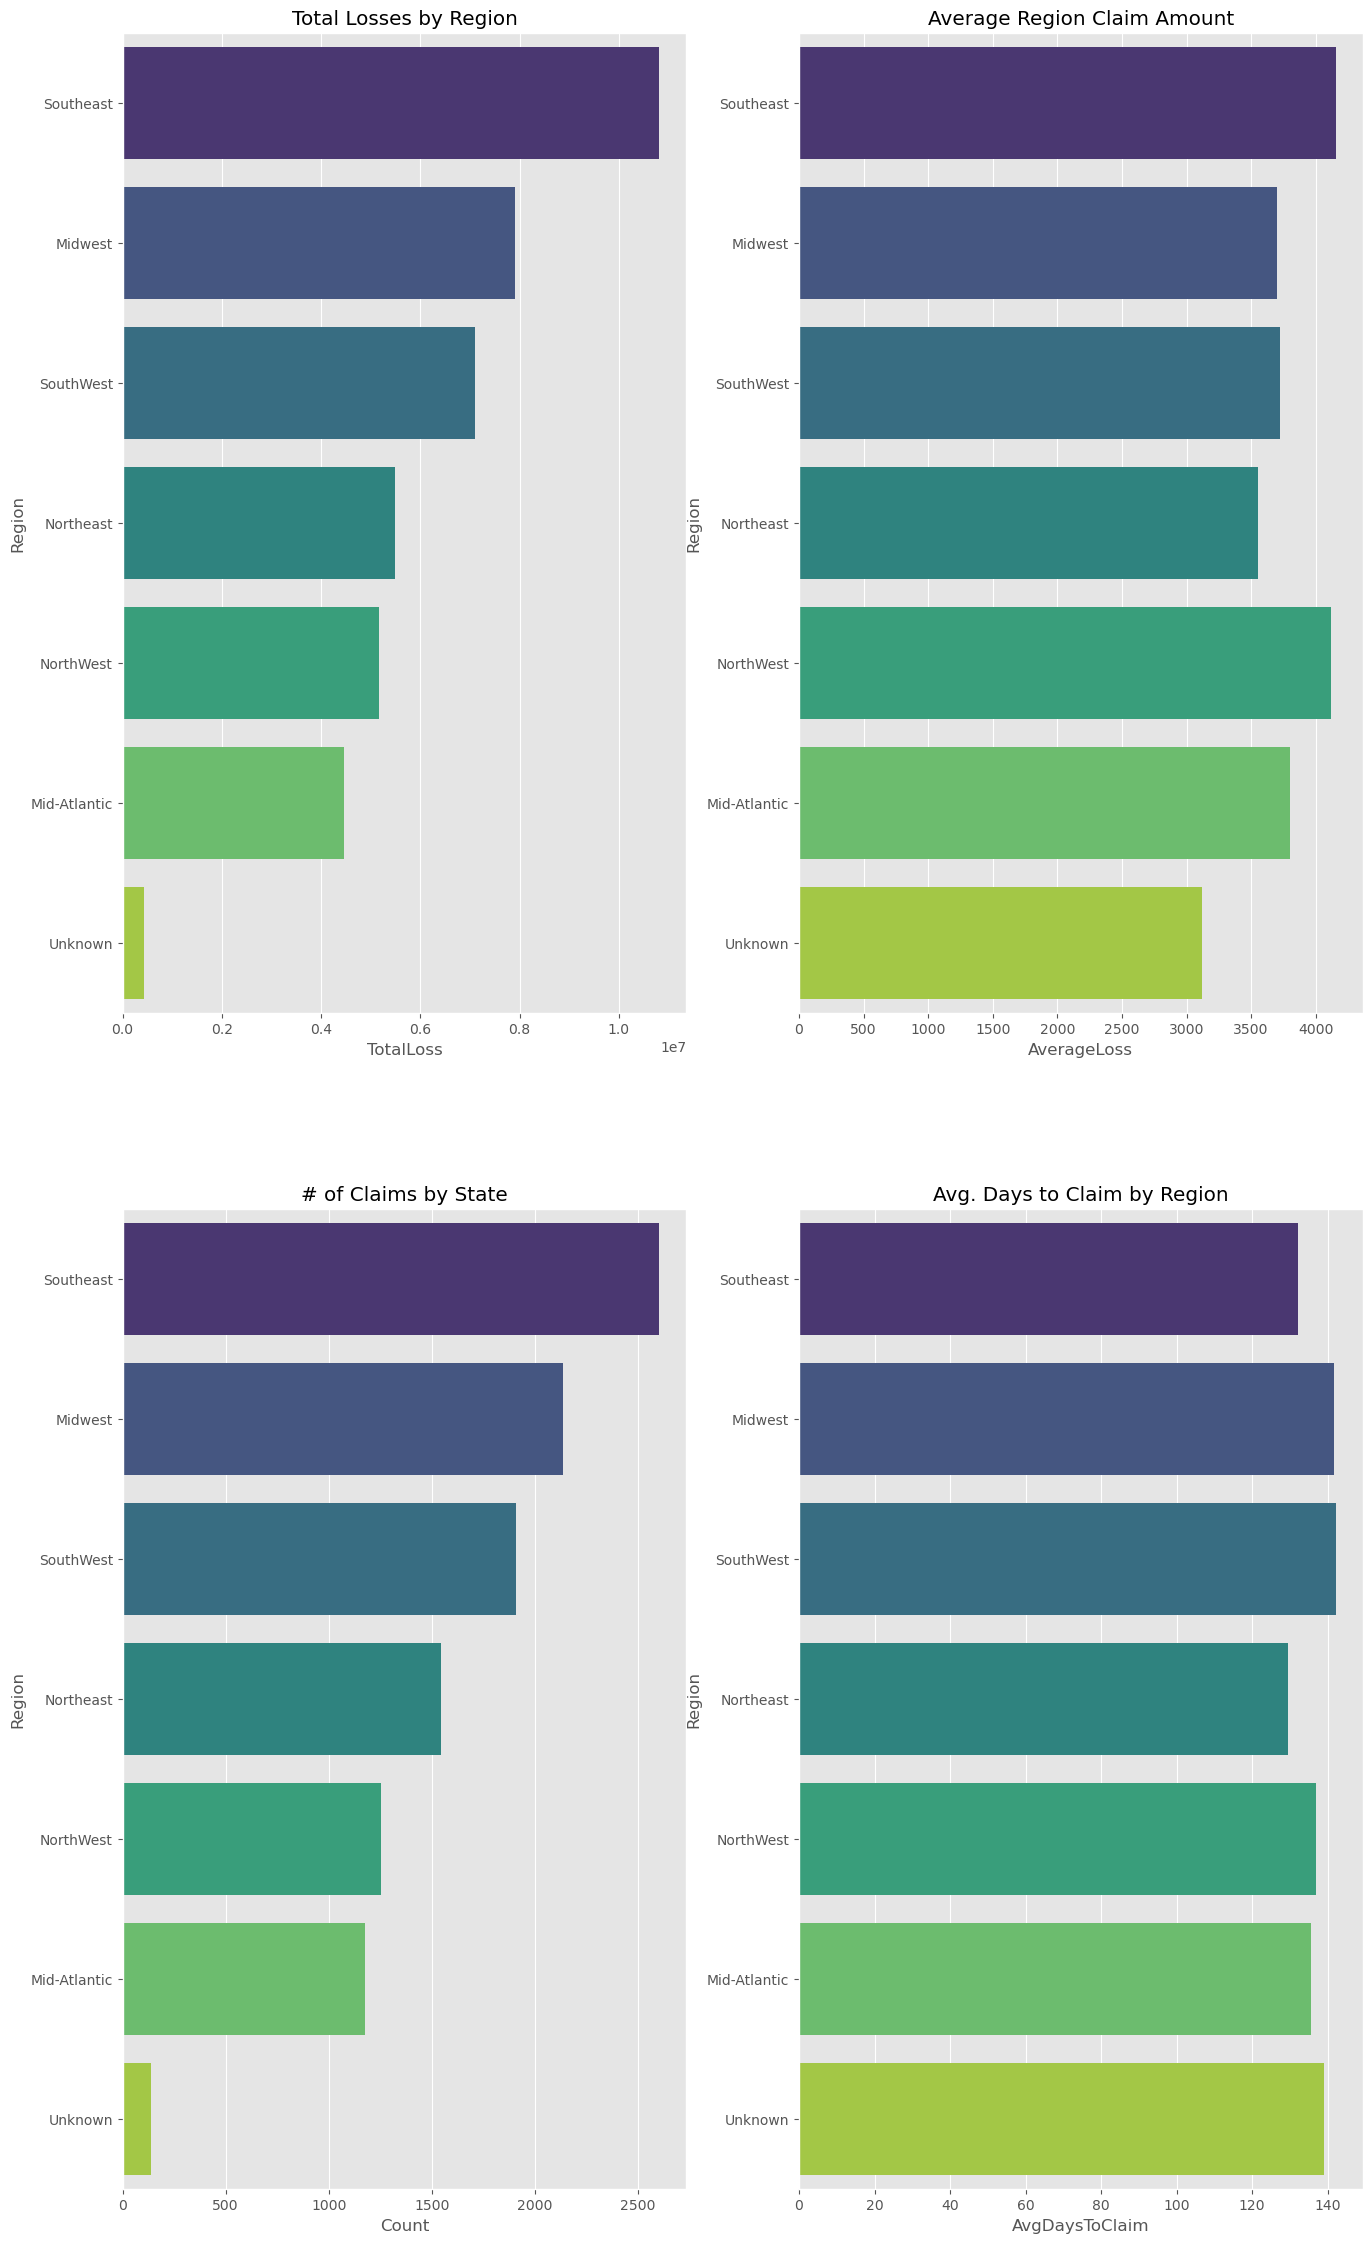

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(16, 28))
color_palette = sns.color_palette("viridis", n_colors=len(df_Region_sortedTotal['Region'].unique()))
region_order = df_Region_sortedTotal['Region'].unique()
region_colors = {region: color for region, color in zip(region_order, color_palette)}

# Total DayOfWeek Claim Amount
sns.barplot(x='TotalLoss', y='Region', data=df_Region_sortedTotal, palette=region_colors, order=region_order, ax=axes[0, 0])
axes[0, 0].set_title('Total Losses by Region')

# Average DayOfWeek Claim Amount
sns.barplot(x='AverageLoss', y='Region', data=df_Region_sortedAvg, palette=region_colors, order=region_order, ax=axes[0, 1])
axes[0, 1].set_title('Average Region Claim Amount')

# # of Claims by DayOfWeek
sns.barplot(x='Count', y='Region', data=df_Region_sortedcount, palette=region_colors, order=region_order, ax=axes[1, 0])
axes[1, 0].set_title('# of Claims by State')


# Avg Days to Claim by DayOfWeek
sns.barplot(x='AvgDaysToClaim', y='Region', data=df_Region_sortedDaystoClaim, palette=region_colors, order=region_order, ax=axes[1, 1])
axes[1, 1].set_title('Avg. Days to Claim by Region')

plt.show()

### Summary
- The regional breakdown shows that the SouthEast is the highest frequency, and highest average claim amount. 
- The Northeast files the 3rd least claims and the least average claim amount. 
- These charts may help inform The General where they can grown and shrink their presence in order to avoid costs. 

### Analyze DriverID 

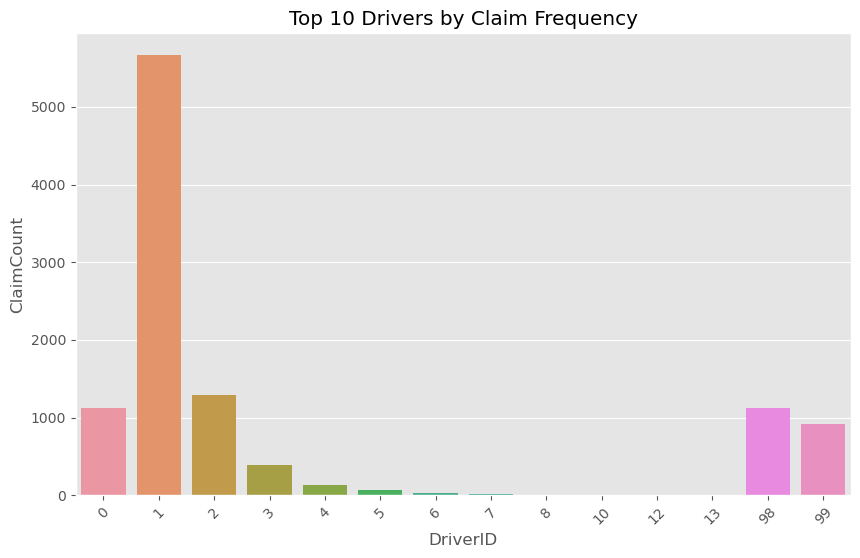

In [118]:
claims_by_driver = df_ClaimMasterTrans.groupby('DriverID')['ClaimNumber'].count().reset_index(name='ClaimCount')
claims_by_driver_sorted = claims_by_driver.sort_values('ClaimCount', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='DriverID', y='ClaimCount', data=claims_by_driver_sorted)  # Display top 10 for clarity
plt.xticks(rotation=45)
plt.title('Top 10 Drivers by Claim Frequency')
plt.show()

In [119]:
df_ClaimMasterTransD1 = df_ClaimMasterTrans[df_ClaimMasterTrans['DriverID'] == 1]
claims_by_driver1 = df_ClaimMasterTransD1.groupby('ClaimType').agg(ClaimCount=('ClaimNumber', 'count'),
                                                 TotalClaimCost=('ClaimTransPaidLoss', 'sum')).reset_index()
claims_by_driver1['AvgClaimCost'] = claims_by_driver1['TotalClaimCost'] / claims_by_driver1['ClaimCount']
claims_by_driver1_sorted = claims_by_driver1.sort_values(['ClaimCount', 'AvgClaimCost'], ascending=False)

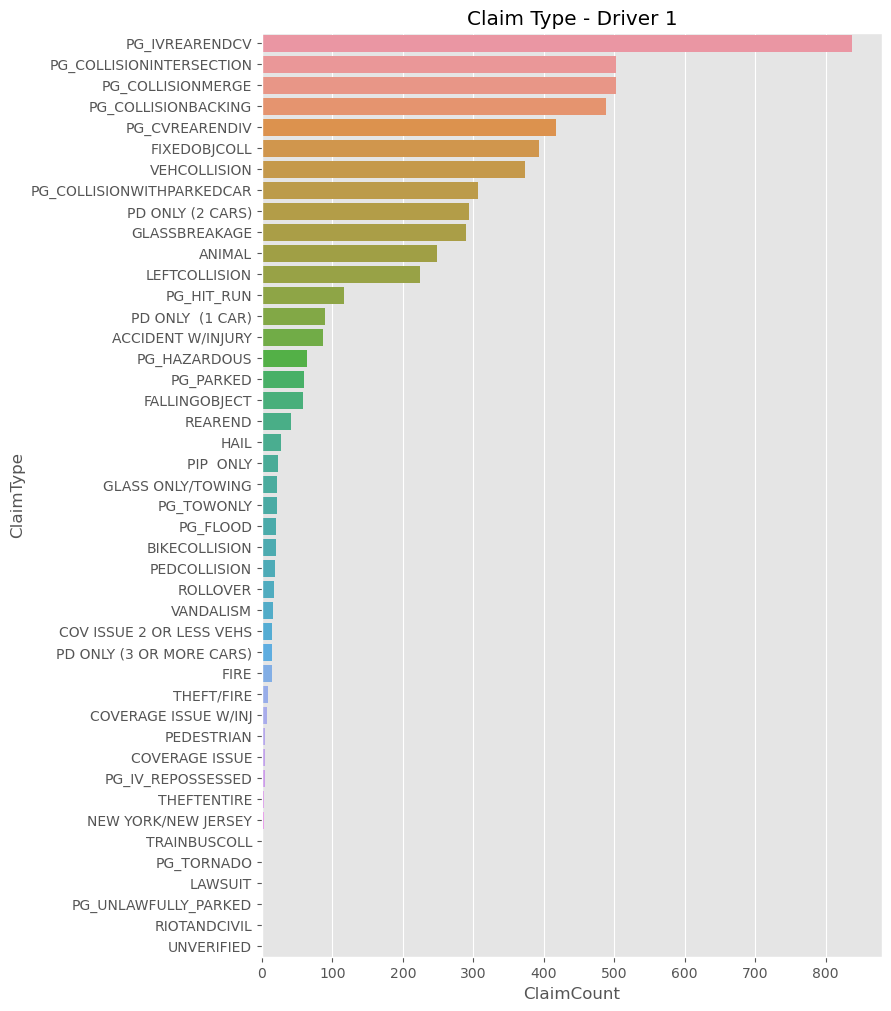

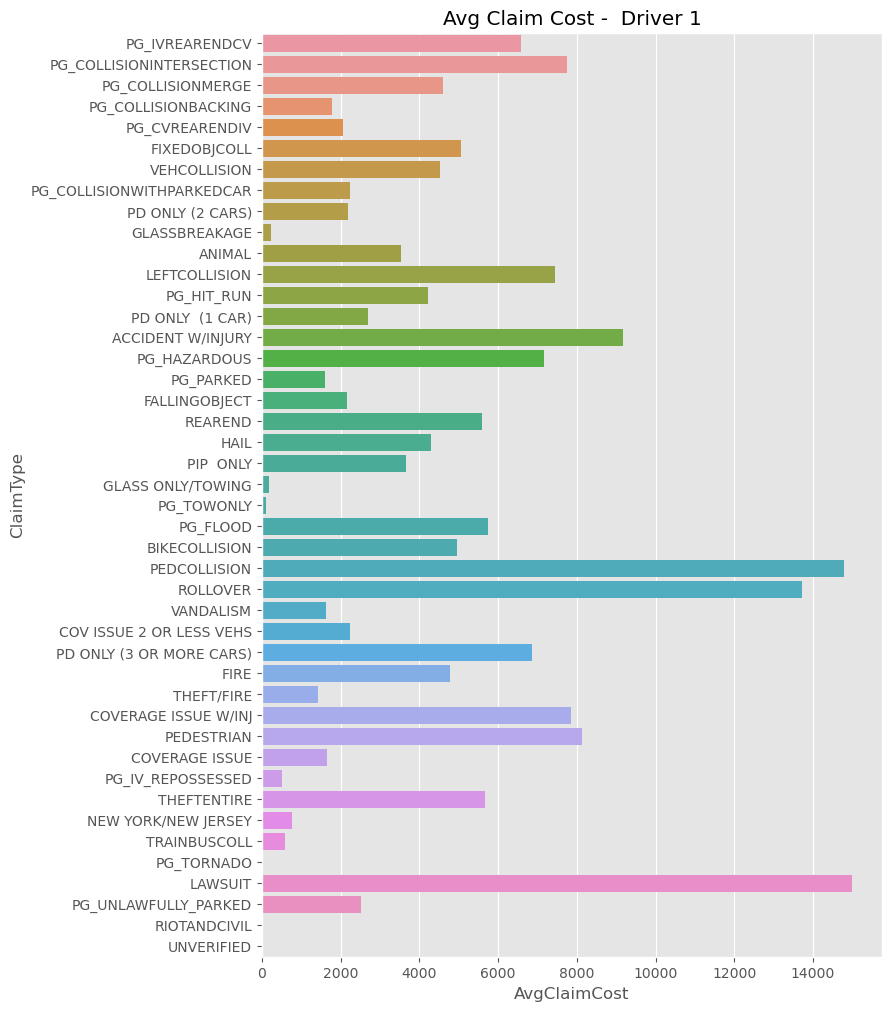

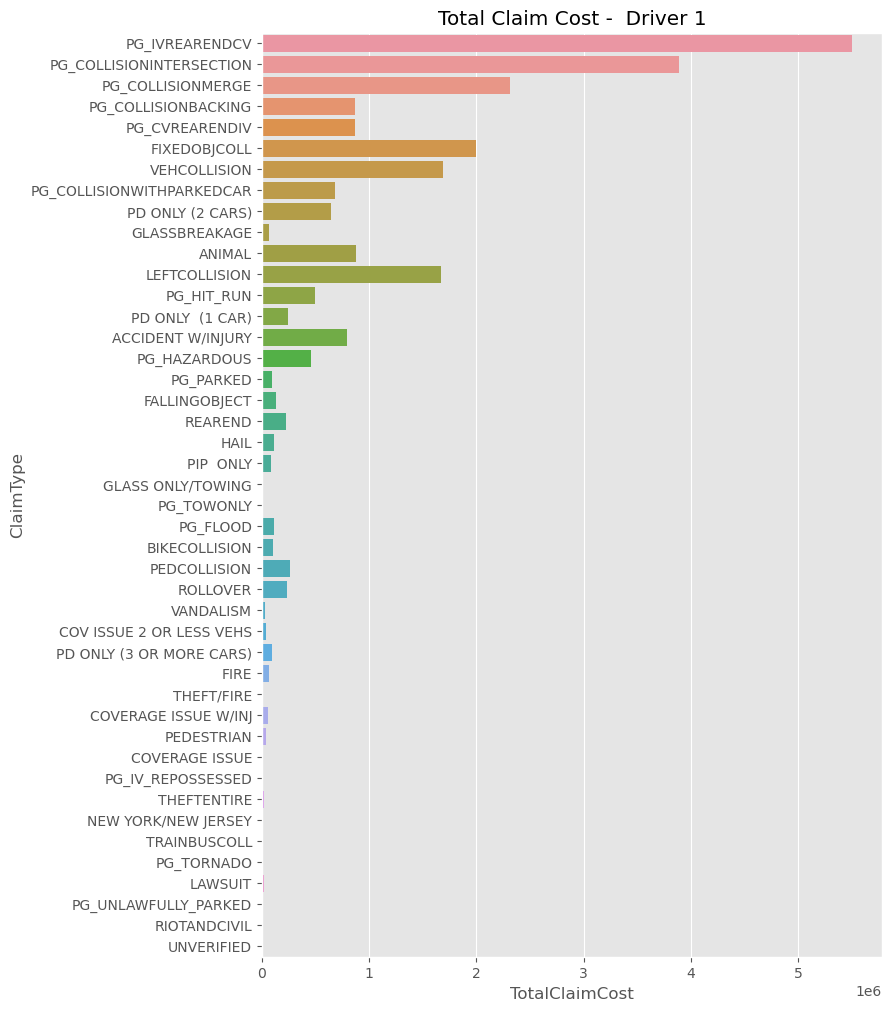

In [120]:
plt.figure(figsize=(8,12))
sns.barplot(x='ClaimCount', y='ClaimType',data=claims_by_driver1_sorted, errorbar=None)
plt.title('Claim Type - Driver 1')
plt.show()

# For Average Claim Cost
plt.figure(figsize=(8, 12))
sns.barplot(x='AvgClaimCost', y='ClaimType', data=claims_by_driver1_sorted, errorbar=None)
plt.title('Avg Claim Cost -  Driver 1')
plt.show()

# For Total Claim Cost
plt.figure(figsize=(8,12))
sns.barplot(x='TotalClaimCost', y='ClaimType', data=claims_by_driver1_sorted, errorbar=None)
plt.title('Total Claim Cost -  Driver 1')
plt.show()

### Analyze Vehicles

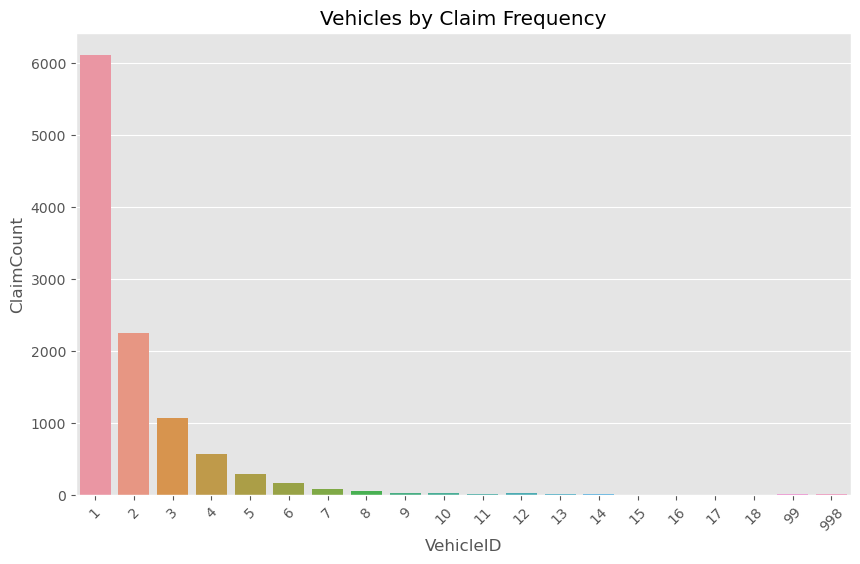

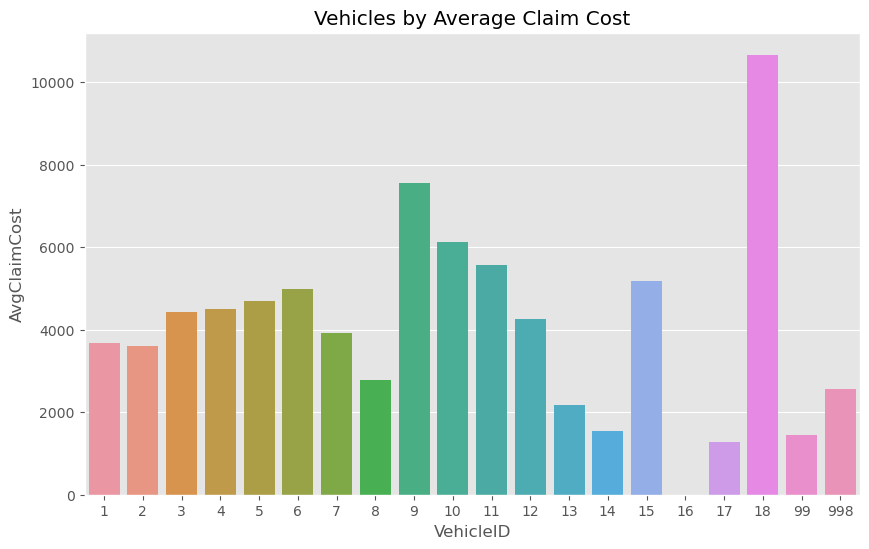

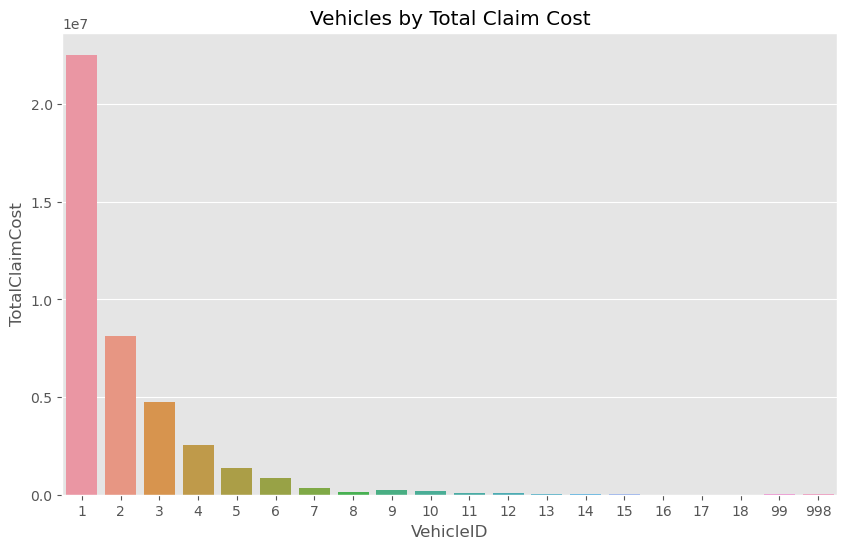

In [121]:
claims_by_vehicle = df_ClaimMasterTrans.groupby('VehicleID').agg(ClaimCount=('ClaimNumber', 'count'),
                                                 TotalClaimCost=('ClaimTransPaidLoss', 'sum')).reset_index()
claims_by_vehicle['AvgClaimCost'] = claims_by_vehicle['TotalClaimCost'] / claims_by_vehicle['ClaimCount']
claims_by_vehicle_sorted = claims_by_vehicle.sort_values(['ClaimCount', 'AvgClaimCost'], ascending=False)
# For Claim Frequency
plt.figure(figsize=(10, 6))
sns.barplot(x='VehicleID', y='ClaimCount', data=claims_by_vehicle_sorted) 
plt.xticks(rotation=45)
plt.title('Vehicles by Claim Frequency')
plt.show()

# For Average Claim Cost
plt.figure(figsize=(10, 6))
sns.barplot(x='VehicleID', y='AvgClaimCost', data=claims_by_vehicle_sorted)
plt.title('Vehicles by Average Claim Cost')
plt.show()

# For Total Claim Cost
plt.figure(figsize=(10, 6))
sns.barplot(x='VehicleID', y='TotalClaimCost', data=claims_by_vehicle_sorted)
plt.title('Vehicles by Total Claim Cost')
plt.show()

### Look at Vehicle 1 - The most common

In [122]:
df_ClaimMasterTransV1 = df_ClaimMasterTrans[df_ClaimMasterTrans['VehicleID'] == 1]

claims_by_vehicle = df_ClaimMasterTransV1.groupby('ClaimType').agg(ClaimCount=('ClaimNumber', 'count'),
                                                 TotalClaimCost=('ClaimTransPaidLoss', 'sum')).reset_index()
claims_by_vehicle['AvgClaimCost'] = claims_by_vehicle['TotalClaimCost'] / claims_by_vehicle['ClaimCount']
claims_by_vehicle_sorted = claims_by_vehicle.sort_values(['ClaimCount', 'AvgClaimCost'], ascending=False)

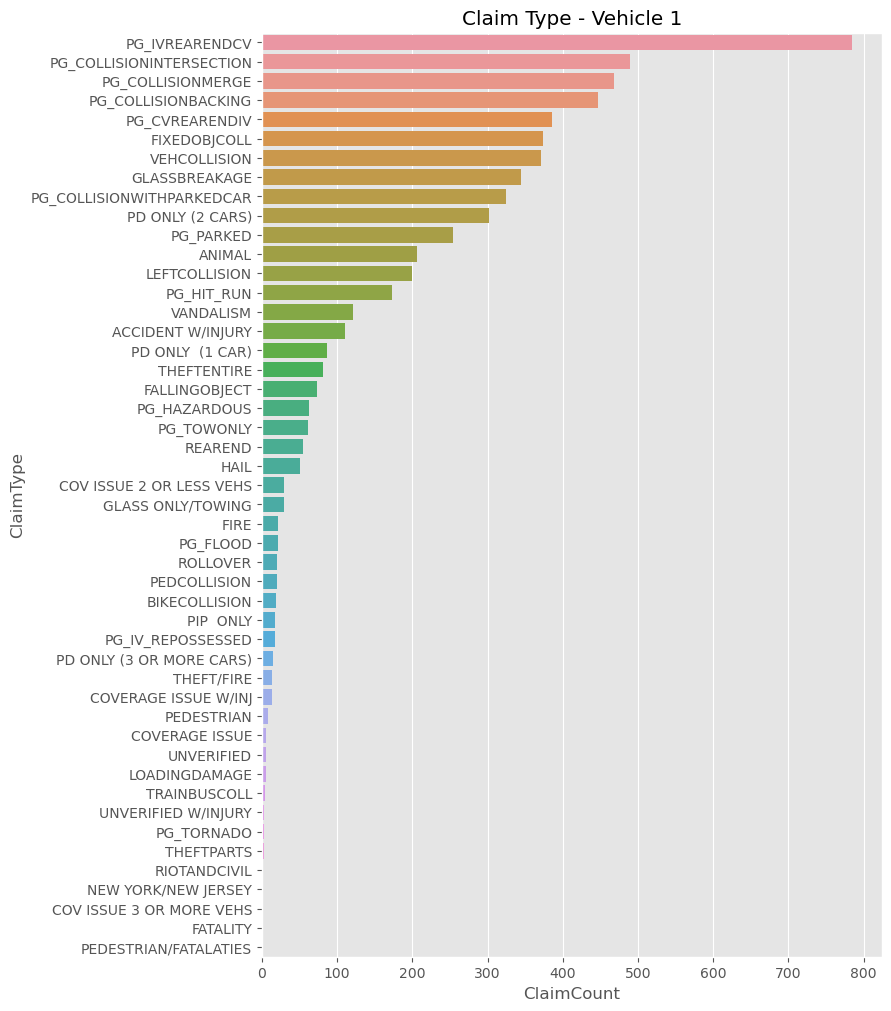

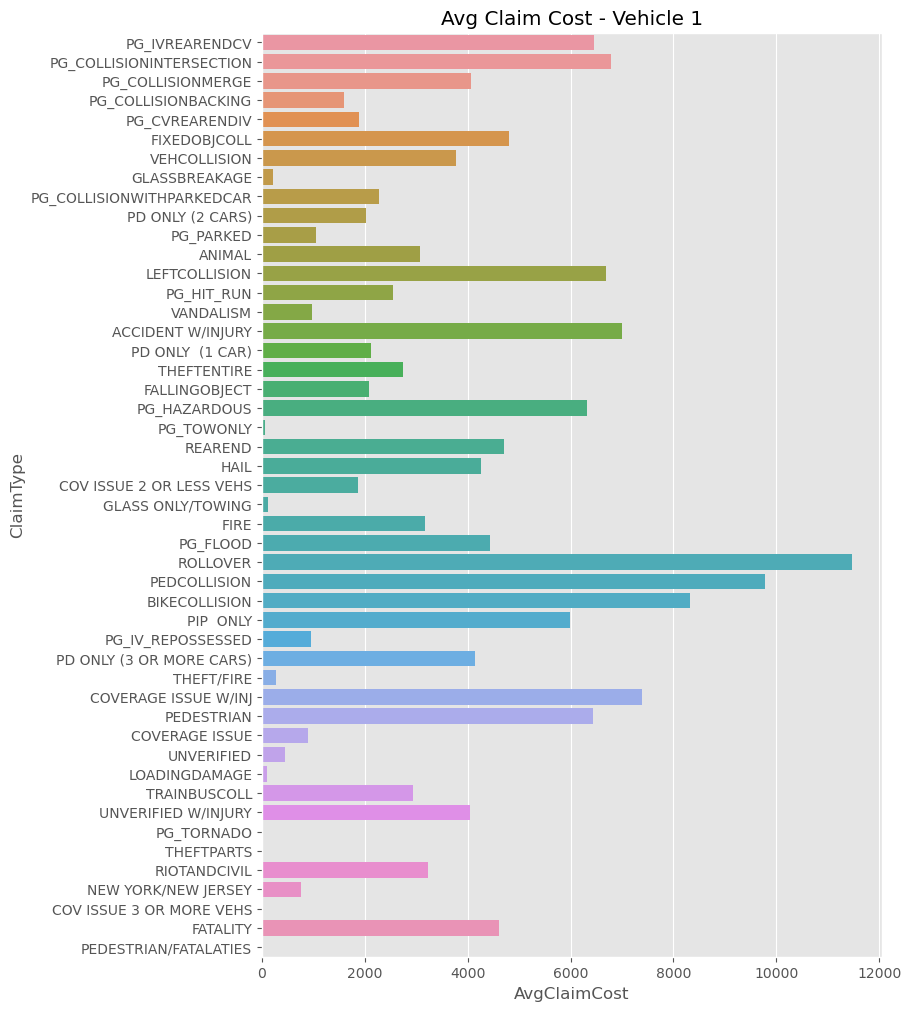

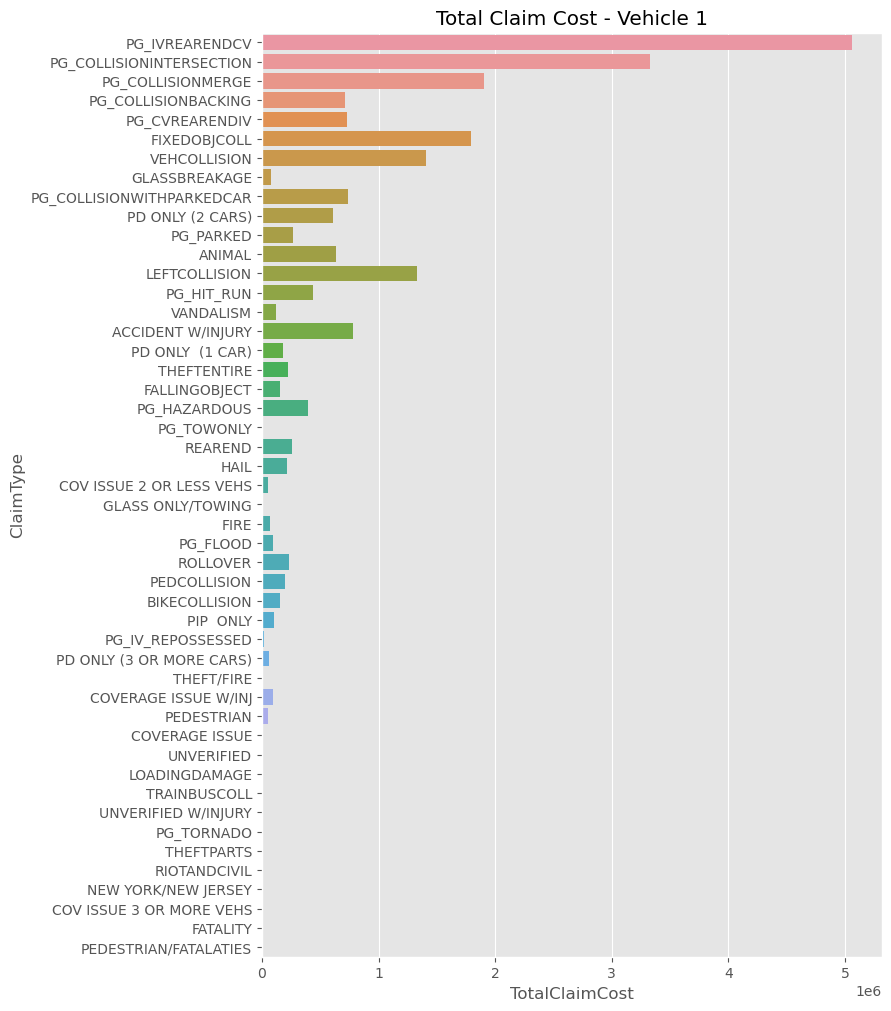

In [123]:
plt.figure(figsize=(8,12))
sns.barplot(x='ClaimCount', y='ClaimType',data=claims_by_vehicle_sorted, errorbar=None)
plt.title('Claim Type - Vehicle 1')
plt.show()

# For Average Claim Cost
plt.figure(figsize=(8, 12))
sns.barplot(x='AvgClaimCost', y='ClaimType', data=claims_by_vehicle_sorted, errorbar=None)
plt.title('Avg Claim Cost - Vehicle 1')
plt.show()

# For Total Claim Cost
plt.figure(figsize=(8,12))
sns.barplot(x='TotalClaimCost', y='ClaimType', data=claims_by_vehicle_sorted, errorbar=None)
plt.title('Total Claim Cost - Vehicle 1')
plt.show()

### Look at Vehicle 2 - Second Most Expensive 

In [124]:
df_ClaimMasterTransV9 = df_ClaimMasterTrans[df_ClaimMasterTrans['VehicleID'] == 9]

claims_by_vehicle = df_ClaimMasterTransV9.groupby('ClaimType').agg(ClaimCount=('ClaimNumber', 'count'),
                                                 TotalClaimCost=('ClaimTransPaidLoss', 'sum')).reset_index()
claims_by_vehicle['AvgClaimCost'] = claims_by_vehicle['TotalClaimCost'] / claims_by_vehicle['ClaimCount']
claims_by_vehicle_sorted = claims_by_vehicle.sort_values(['ClaimCount', 'AvgClaimCost'], ascending=False)

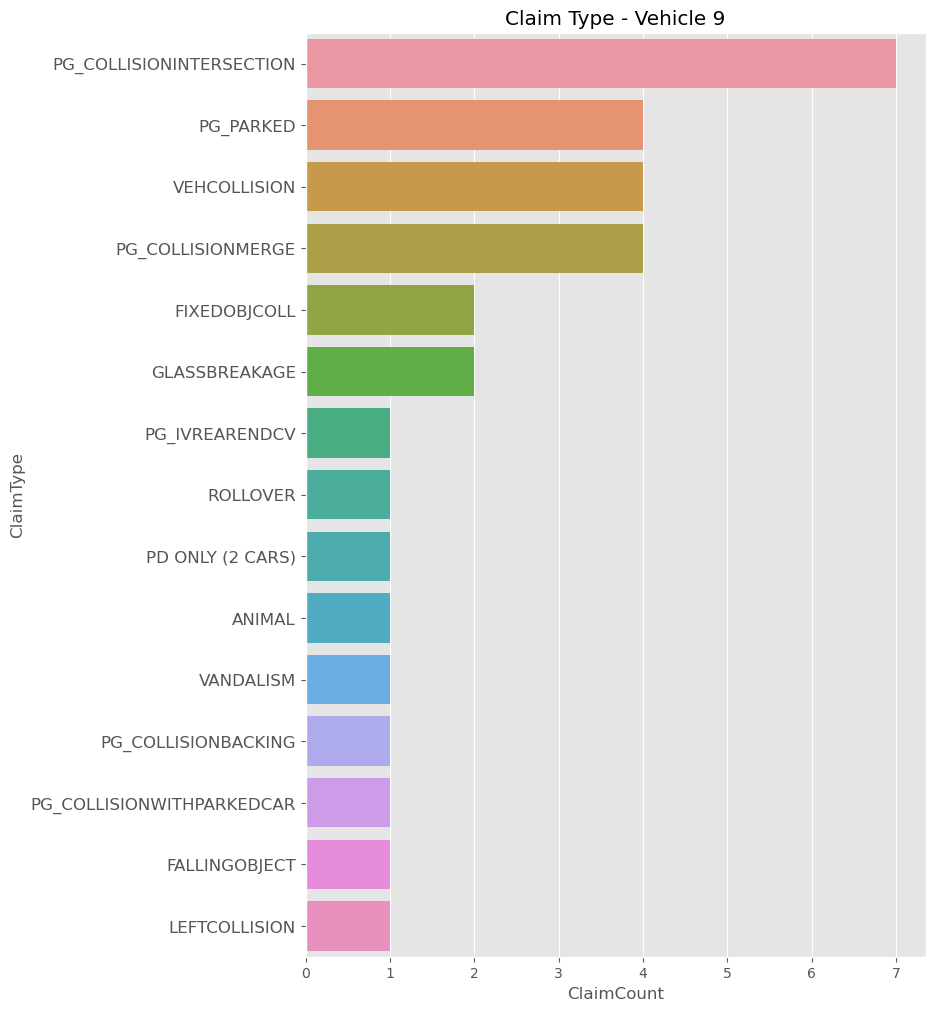

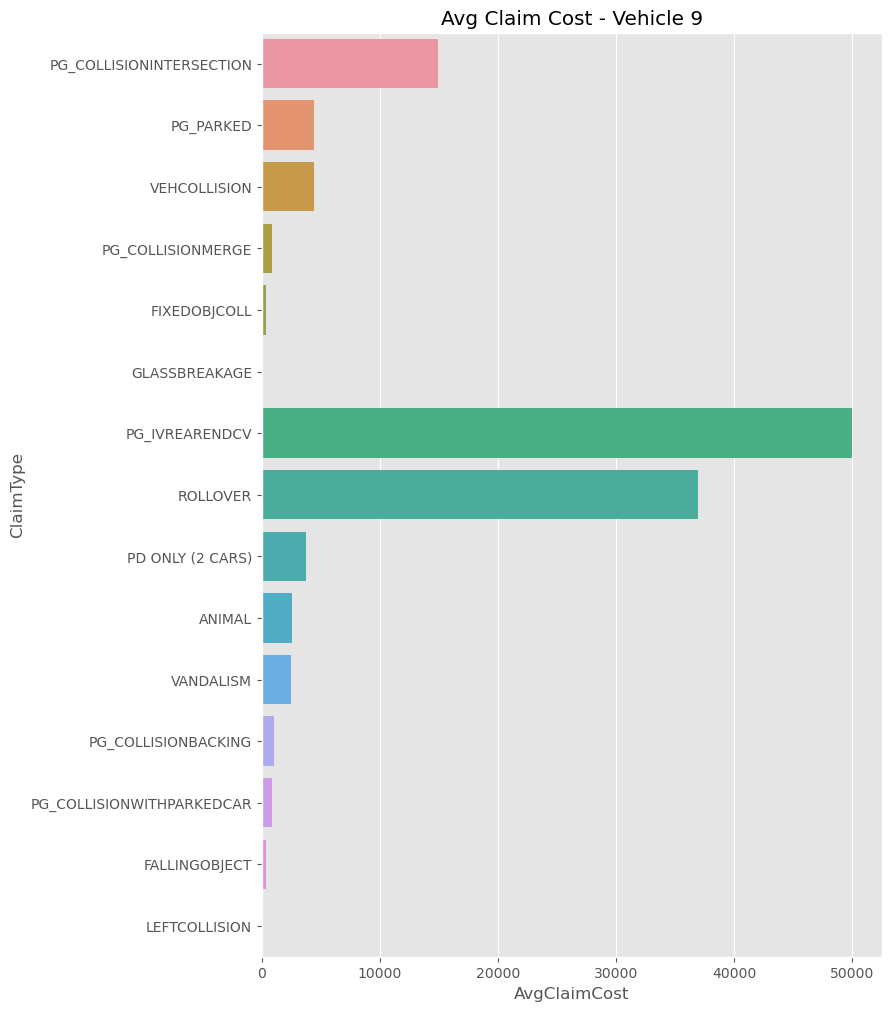

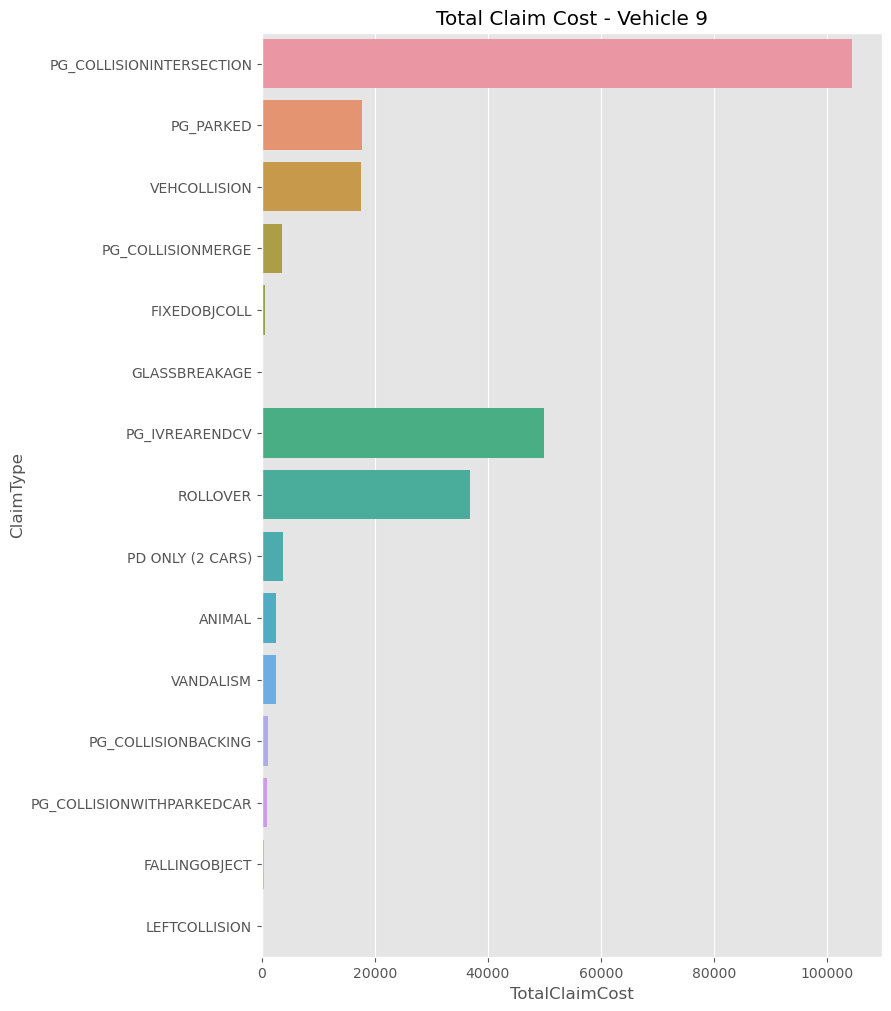

In [125]:
plt.figure(figsize=(8,12))
sns.barplot(x='ClaimCount', y='ClaimType',data=claims_by_vehicle_sorted, errorbar=None)
plt.yticks(fontsize=12)
plt.title('Claim Type - Vehicle 9')
plt.show()

# For Average Claim Cost
plt.figure(figsize=(8, 12))
sns.barplot(x='AvgClaimCost', y='ClaimType', data=claims_by_vehicle_sorted, errorbar=None)
plt.title('Avg Claim Cost - Vehicle 9')
plt.show()

# For Total Claim Cost
plt.figure(figsize=(8,12))
sns.barplot(x='TotalClaimCost', y='ClaimType', data=claims_by_vehicle_sorted, errorbar=None)
plt.title('Total Claim Cost - Vehicle 9')
plt.show()

### Summary of Vehicles
- This section explored the relationship between claims filed and the vehicles. 
- Vehicle 1 is the most common, Vehicle 9 appears to the be the most costly to have a claim on it. 
- Slicing this analysis various ways, while combining it with an analysis of the cost of the particular make and model of car could provide greater insights into how to properly consider the role that vehicle type has in the overall cost of claims against the business.

## Section 5.2 Exploring Policies

### What is the most and average policies that one contact or household has with The General? 

In [126]:
PolicyPerContact = df_PolicyContact.groupby('AbilitecContactID')['PolicyNumber'].count().reset_index(name='#OfPolicies')
PolicyPerHousehold = df_PolicyContact.groupby('AbilitecHouseholdID')['PolicyNumber'].count().reset_index(name='#OfPolicies')

print(f"The most policies that one Contact has is {PolicyPerContact['#OfPolicies'].max()} policies.")
print(f"The average number of policies that a Contact has is {PolicyPerContact['#OfPolicies'].mean():.2f} policies.")

print(f"The most policies that one household has is {PolicyPerHousehold['#OfPolicies'].max()} policies.")
print(f"The average number of policies that a household has is {PolicyPerHousehold['#OfPolicies'].mean():.2f} policies.")

The most policies that one Contact has is 15 policies.
The average number of policies that a Contact has is 1.42 policies.
The most policies that one household has is 14 policies.
The average number of policies that a household has is 1.26 policies.


In [127]:
ContactPerHousehold = df_PolicyContact.groupby('AbilitecHouseholdID')['AbilitecContactID'].count().reset_index(name='#OfContacts')

In [128]:
print(f"The most contacts that one household has is {ContactPerHousehold['#OfContacts'].max()} contacts.")
print(f"The average number of contacts that one household has is {ContactPerHousehold['#OfContacts'].mean():.2f} contacts.")

The most contacts that one household has is 14 contacts.
The average number of contacts that one household has is 1.26 contacts.


One contact has 15 policies, apparently within two different households ( ? ) 
The average number of policies per contact and household are two figures worth keeping track of over time. It could be used to inform marketing direction when combined with drill downs of where more household policies are achieved. 

### What is the % of Policies that have produced less than the avg paid loss on a claim from sectoin 5.1?

In [129]:
percent_below_avg = (df_PolicyContact['TotalPaid'] < 3715.42).mean() * 100
print(f"The percentage of policies that have had a paid loss less than the average claim cost is {percent_below_avg:.2f}%")

The percentage of policies that have had a paid loss less than the average claim cost is 93.08%


#### This means that 6.92% of our policies are the source of 50% of our claim cost. Finding these values and identifying how they differ from the other 93.08% could provide great insight. 

### Violin Plot of ClaimCount and TotalPaid

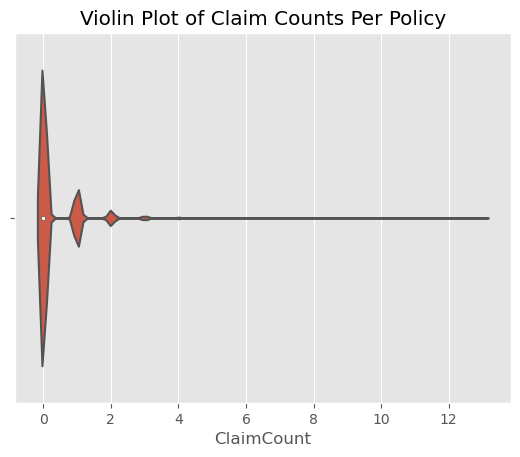

In [130]:
sns.violinplot(x='ClaimCount', data=df_PolicyContact)
plt.title('Violin Plot of Claim Counts Per Policy')
plt.show()

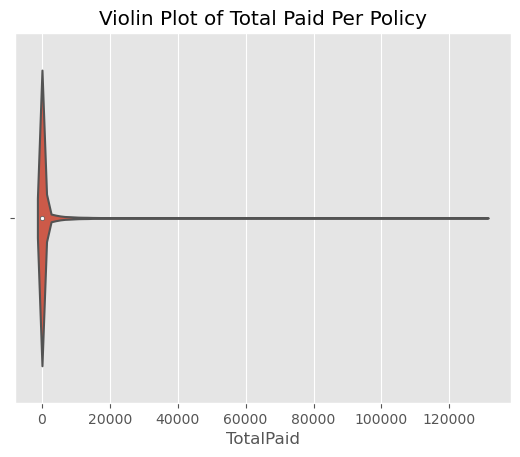

In [131]:
sns.violinplot(x='TotalPaid', data=df_PolicyContact)
plt.title('Violin Plot of Total Paid Per Policy')
plt.show()


#### This is visualzing the heavy right skew of claims and paid losses in insurance. We want this to be as skinny and focused to the left as possible

### What is going on with these massive payouts? 

In [132]:
threshold_value = 50000

df_PolicyContactHigh = (df_PolicyContact['TotalPaid'] > threshold_value)
df_PolicyContact_HighCost = df_PolicyContact[df_PolicyContactHigh]

In [133]:
PolicyPerHighCostContact = df_PolicyContact_HighCost.groupby('AbilitecContactID')['PolicyNumber'].count().reset_index(name='#OfPolicies')
PolicyPerHighCostHousehold = df_PolicyContact_HighCost.groupby('AbilitecHouseholdID')['PolicyNumber'].count().reset_index(name='#OfPolicies')
ClaimsPerHighCostContact = df_PolicyContact_HighCost.groupby('AbilitecContactID')['ClaimCount'].sum().reset_index(name='#OfClaims')
ClaimsPerHighCostHousehold = df_PolicyContact_HighCost.groupby('AbilitecHouseholdID')['ClaimCount'].sum().reset_index(name='#OfClaims')

In [134]:
print(f"The average number of policies per high cost (>${threshold_value}) contact is: {PolicyPerHighCostContact['#OfPolicies'].mean():.2f}.")
print(f"The average number of claims per high cost contact (>${threshold_value}) contact is: {ClaimsPerHighCostContact['#OfClaims'].mean():.2f}.")

The average number of policies per high cost (>$50000) contact is: 1.00.
The average number of claims per high cost contact (>$50000) contact is: 2.80.


In [135]:
print(f"The average number of policies per high cost (>${threshold_value}) household is: {PolicyPerHighCostHousehold['#OfPolicies'].mean():.2f}.")
print(f"The average number of claims per high cost household (>${threshold_value}) household is: {ClaimsPerHighCostHousehold['#OfClaims'].mean():.2f}.")

The average number of policies per high cost (>$50000) household is: 1.00.
The average number of claims per high cost household (>$50000) household is: 2.80.


### Merge df_PolicyContact_HighCost with df_ClaimMasterTrans to see what is causing these high cost

In [136]:
df_HighCostClaimMasterTrans = pd.merge(df_PolicyContact_HighCost, df_ClaimMasterTrans, on='PolicyNumber',how='left')

In [137]:
claim_counts = df_HighCostClaimMasterTrans['ClaimCount']

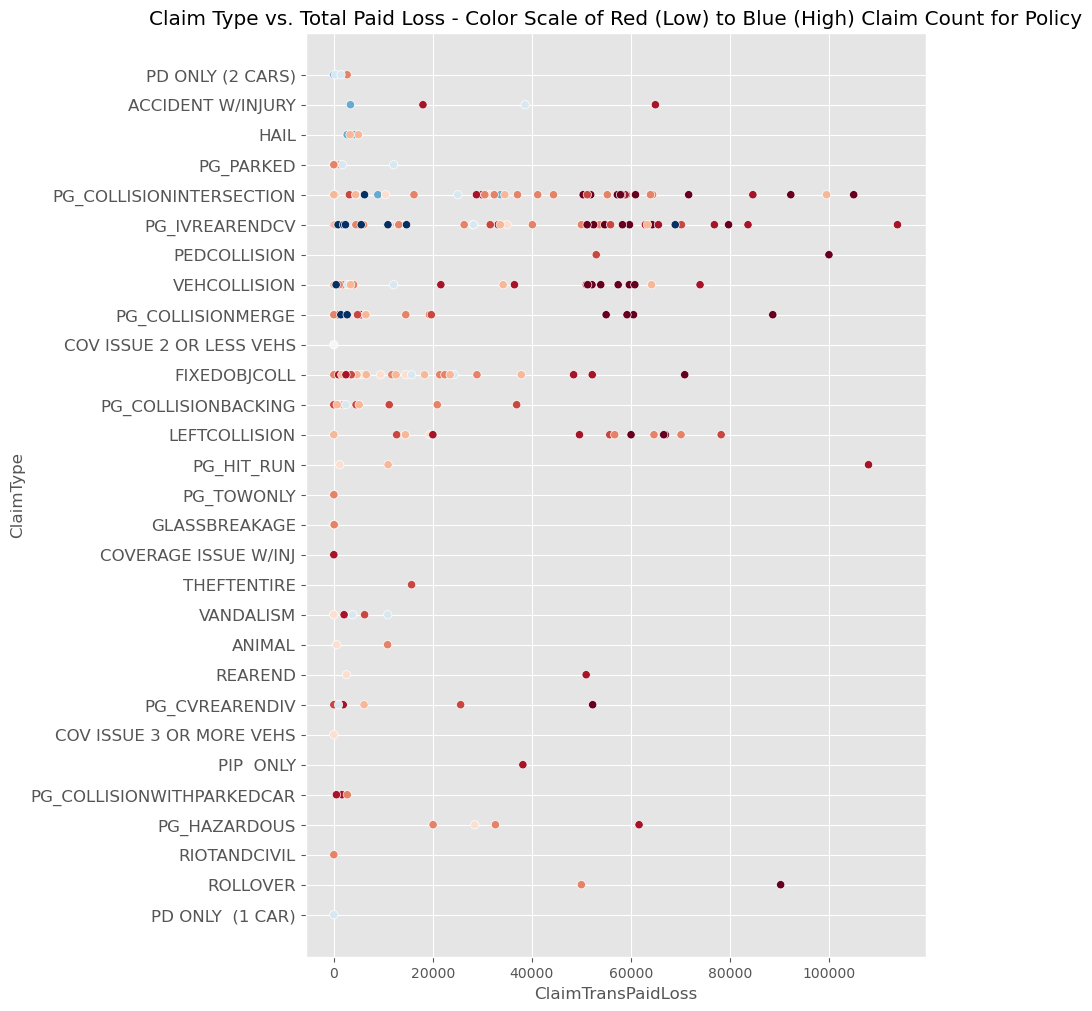

In [138]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='ClaimTransPaidLoss', y='ClaimType',data=df_HighCostClaimMasterTrans, c=claim_counts, cmap='RdBu', marker='o')
plt.yticks(fontsize=12)
plt.title('Claim Type vs. Total Paid Loss - Color Scale of Red (Low) to Blue (High) Claim Count for Policy')
plt.show()

#### This chart shows the total number of claims in a Red (low) to Blue (High) hue with the total paid out in the x axis. Identifying who the multiple frequency collision and rearend offenders are can help identify what the total cost should be in for similar demographics and driving histories in the future. 

### Vehicle Type in the High Loss Dataset

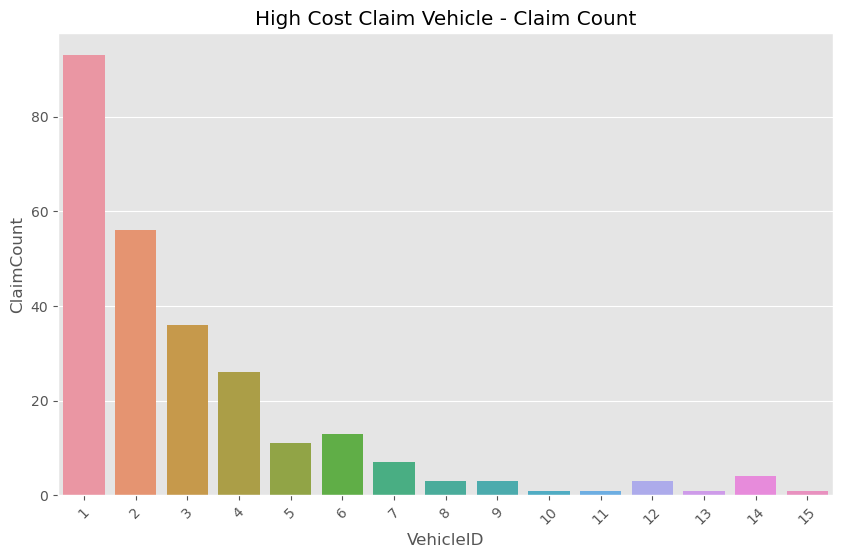

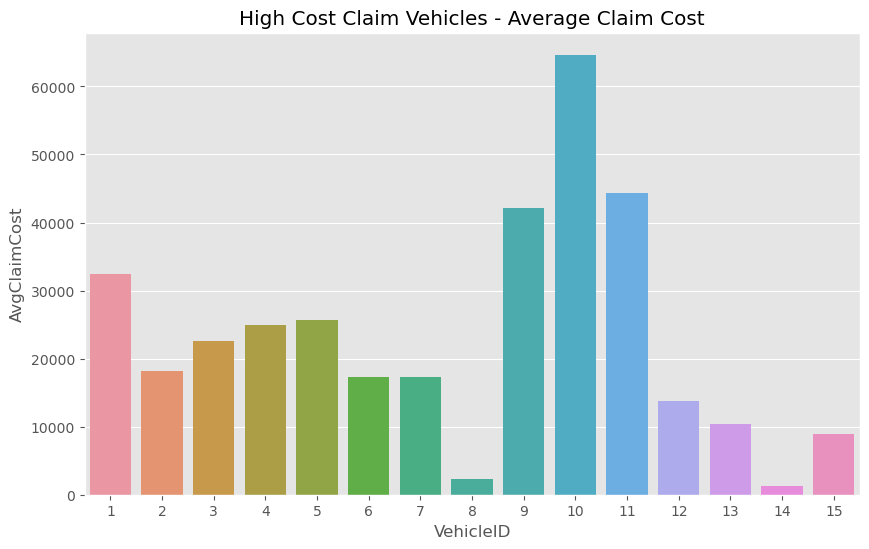

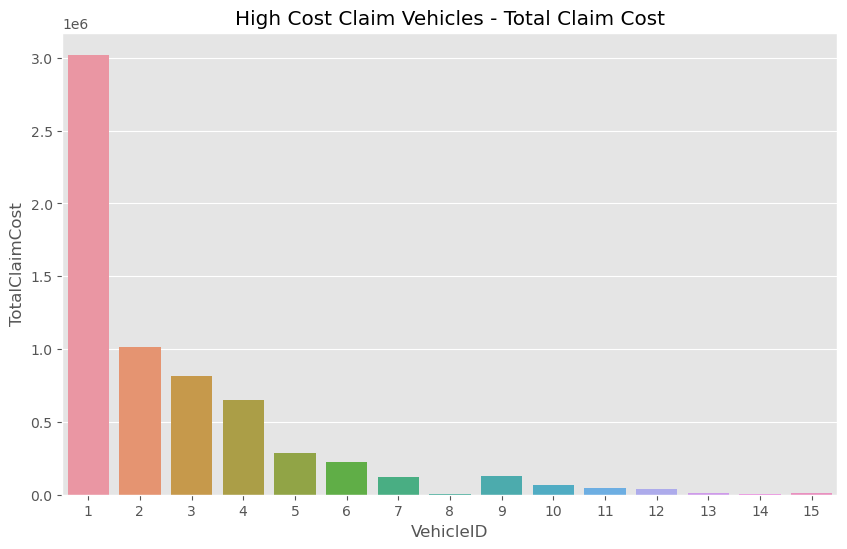

In [139]:
claims_by_vehicle = df_HighCostClaimMasterTrans.groupby('VehicleID').agg(ClaimCount=('ClaimNumber', 'count'),
                                                                         ClaimTypeCount=('ClaimType','count'),
                                                 TotalClaimCost=('ClaimTransPaidLoss', 'sum')).reset_index()

claims_by_vehicle['AvgClaimCost'] = claims_by_vehicle['TotalClaimCost'] / claims_by_vehicle['ClaimCount']
claims_by_vehicle_sorted = claims_by_vehicle.sort_values(['ClaimCount', 'AvgClaimCost'], ascending=False)
# For Claim Frequency
plt.figure(figsize=(10, 6))
sns.barplot(x='VehicleID', y='ClaimCount', data=claims_by_vehicle_sorted) 
plt.xticks(rotation=45)
plt.title('High Cost Claim Vehicle - Claim Count')
plt.show()

# For Average Claim Cost
plt.figure(figsize=(10, 6))
sns.barplot(x='VehicleID', y='AvgClaimCost', data=claims_by_vehicle_sorted)
plt.title('High Cost Claim Vehicles - Average Claim Cost')
plt.show()

# For Total Claim Cost
plt.figure(figsize=(10, 6))
sns.barplot(x='VehicleID', y='TotalClaimCost', data=claims_by_vehicle_sorted)
plt.title('High Cost Claim Vehicles - Total Claim Cost')
plt.show()



- Vehicle ID 9-11 appear to be very costly. 
- Vehicle ID 1 appear to be most costly to cover overall in high cost situations. The avg payout in these situations is nearly 10x the avg payout in the full dataset. Possibly these are the instances where these vehicles are involved in very damaging events. 

### What were the claim types for vehicle 1 in the High Cost dataset

In [140]:
df_HighCostClaimMasterTransV1 = df_HighCostClaimMasterTrans[df_HighCostClaimMasterTrans['VehicleID'] == 1]

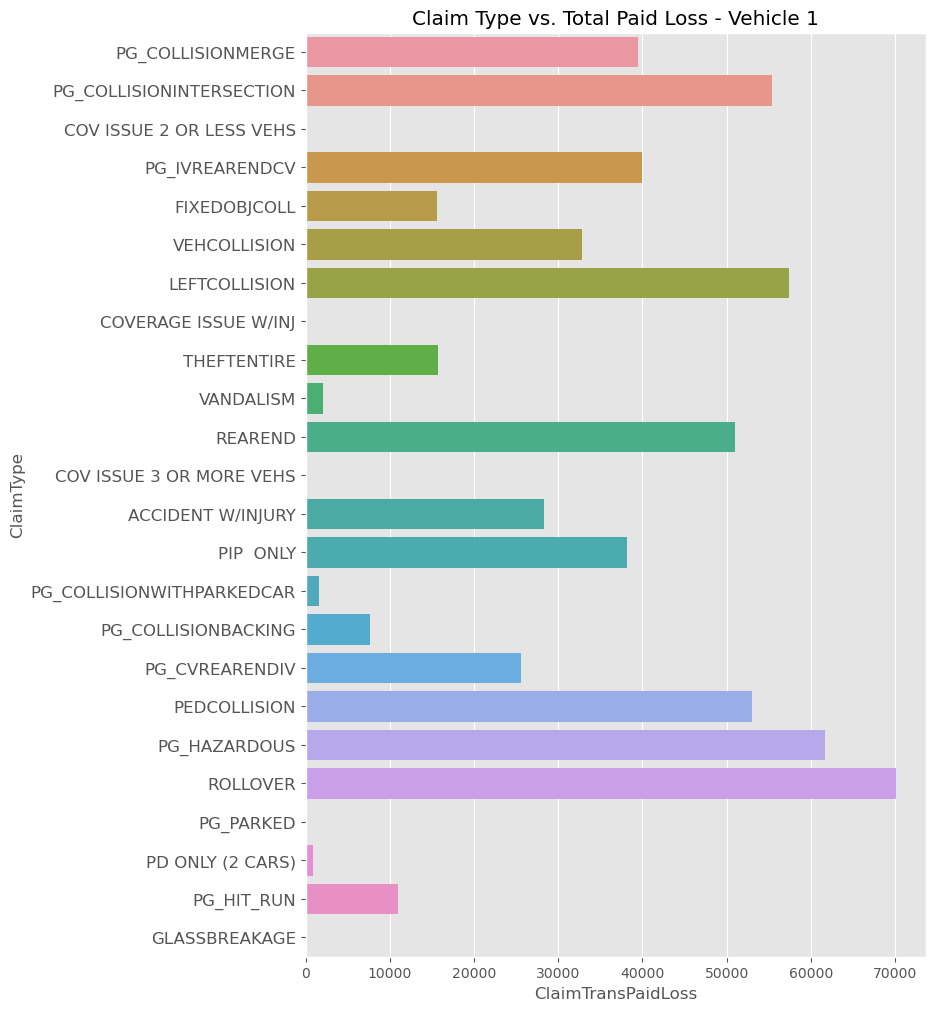

In [141]:
plt.figure(figsize=(8,12))
sns.barplot(x='ClaimTransPaidLoss', y='ClaimType',data=df_HighCostClaimMasterTransV1, errorbar=None)
plt.yticks(fontsize=12)
plt.title('Claim Type vs. Total Paid Loss - Vehicle 1')
plt.show()

### Demographic Information in the High Cost Data

In [142]:
df_PolicyContact_HighCost = pd.merge(df_PolicyContact_HighCost, df_demoInfo, left_on='AbilitecContactID', right_on='APID', how='left')

In [143]:
df_HighCost_Claims = pd.merge(df_PolicyContact_HighCost, df_ClaimMasterTrans, on='PolicyNumber', how='right')

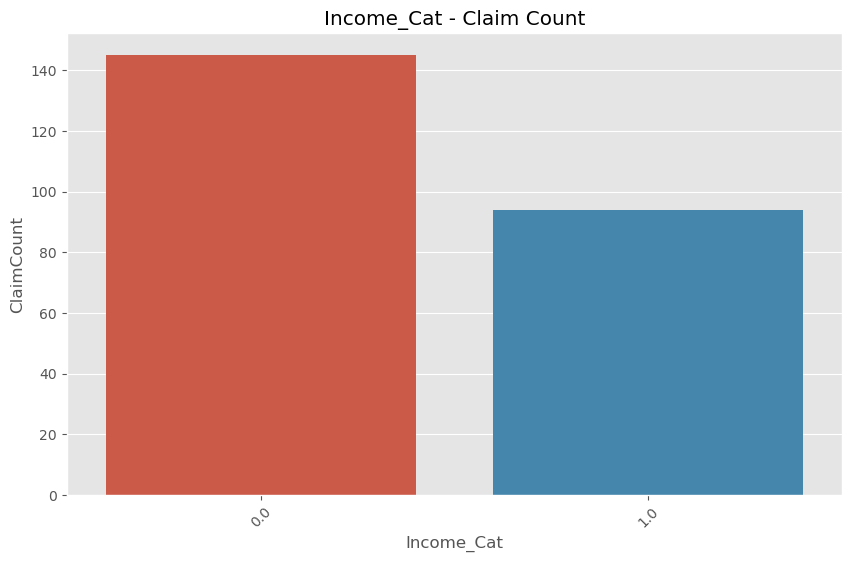

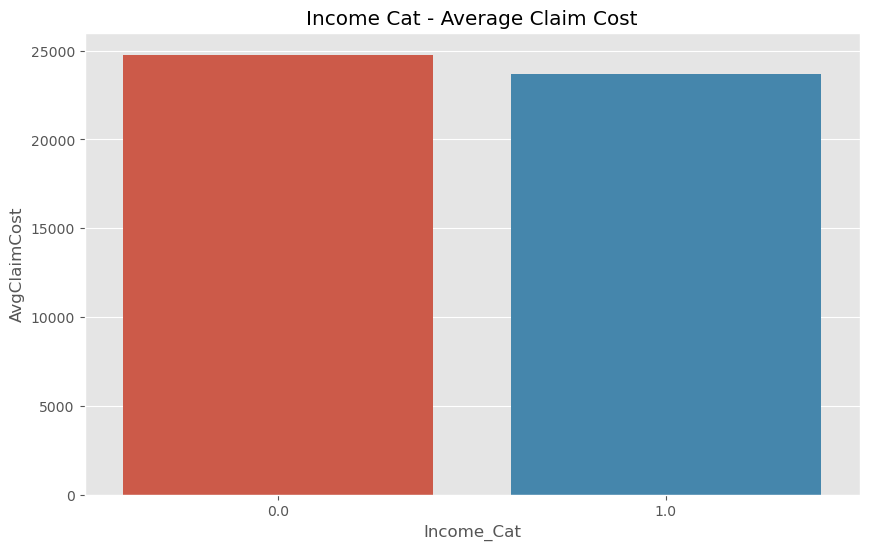

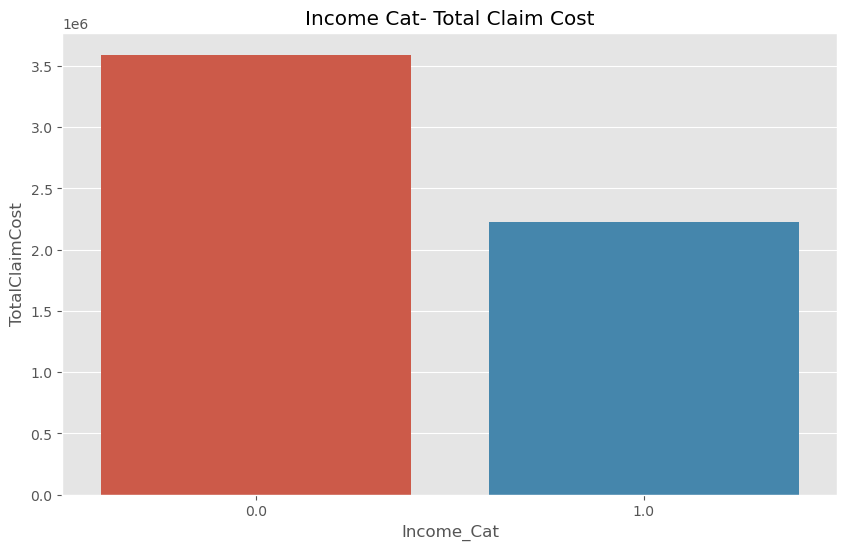

In [144]:
claims_by_income_cat = df_HighCost_Claims.groupby('Income_Cat').agg(ClaimCount=('ClaimNumber', 'count'),
                                                                         ClaimTypeCount=('ClaimType','count'),
                                                 TotalClaimCost=('ClaimTransPaidLoss', 'sum')).reset_index()

claims_by_income_cat['AvgClaimCost'] = claims_by_income_cat['TotalClaimCost'] / claims_by_income_cat['ClaimCount']
claims_by_income_cat_sorted = claims_by_income_cat.sort_values(['ClaimCount', 'AvgClaimCost'], ascending=False)
# For Claim Frequency
plt.figure(figsize=(10, 6))
sns.barplot(x='Income_Cat', y='ClaimCount', data=claims_by_income_cat_sorted) 
plt.xticks(rotation=45)
plt.title('Income_Cat - Claim Count')
plt.show()

# For Average Claim Cost
plt.figure(figsize=(10, 6))
sns.barplot(x='Income_Cat', y='AvgClaimCost', data=claims_by_income_cat_sorted)
plt.title('Income Cat - Average Claim Cost')
plt.show()

# For Total Claim Cost
plt.figure(figsize=(10, 6))
sns.barplot(x='Income_Cat', y='TotalClaimCost', data=claims_by_income_cat_sorted)
plt.title('Income Cat- Total Claim Cost')
plt.show()

#### This indicates that high income individuals are costing less in this high cost events. 
- I'm not sure if there is much great insight to be made here. 

## Exploring Quotes

### What percentage of quotes result in a policy? 

In [145]:
policy_count = df_MasterQuote.loc[df_MasterQuote['PolicyNumber'] != 'NoPolicy'].shape[0]
quote_count = df_MasterQuote['QuoteNumber'].count()
print(f"The percentage of quotes that result in a policy is {(policy_count/quote_count)* 100:.2f}%")

The percentage of quotes that result in a policy is 60.89%


### What is the breakdown of quoted Policy terms? 

In [146]:
df_MasterQuote['PolicyTerm'].unique()

array([12,  6], dtype=int64)

In [147]:
full_year_count = df_MasterQuote.loc[df_MasterQuote['PolicyTerm'] == 12].shape[0]
half_year_count = df_MasterQuote.loc[df_MasterQuote['PolicyTerm'] == 6].shape[0]
print(f"The percentage of quotes that are quoted at 12 months is {(full_year_count/quote_count)* 100:.2f}%")
print(f"The percentage of quotes that are quoted at 6 months is {(half_year_count/quote_count)* 100:.2f}%")

The percentage of quotes that are quoted at 12 months is 64.65%
The percentage of quotes that are quoted at 6 months is 35.35%


### What is the relationship between Quotes and Marital Status?

In [148]:
QuotePerMaritalStatus = df_MasterQuote.groupby('NamedInsuredMaritalStatus')['QuoteNumber'].count().reset_index(name='#OfQuotes')


In [149]:
QuotePerMaritalStatus = QuotePerMaritalStatus.sort_values('#OfQuotes', ascending=False)

In [150]:
df_QuotedDemo = pd.merge(df_MasterQuote, df_demoInfo, left_on='AbilitecContactID',right_on='APID',how='left')

In [151]:
AvgQuotedTotalMaritalStatus = df_QuotedDemo.groupby('NamedInsuredMaritalStatus')['MQuotedTotalPayment'].mean().reset_index(name='AvgQuoteTotal')

In [152]:
AvgAgebyMaritalStatus = df_QuotedDemo.groupby('NamedInsuredMaritalStatus')['Age'].mean().reset_index(name='AvgAge')

In [153]:
AvgAgebyMaritalStatus

NamedInsuredMaritalStatus     AvgAge
0               Civil Union  50.666667
1                  Divorced  47.905361
2          Domestic Partner  36.857143
3                   Married  45.947163
4                 Separated  45.236332
5                    Single  43.872880
6                   Widowed  56.381579

#### The youngest demographic is Domestic Partner, the oldest is Widower. 

In [154]:
AvgQuotedTotalMaritalStatus

NamedInsuredMaritalStatus  AvgQuoteTotal
0               Civil Union    1411.777778
1                  Divorced    1477.930554
2          Domestic Partner    1265.875000
3                   Married    1781.729603
4                 Separated    1458.890269
5                    Single    1660.986106
6                   Widowed    1884.194067

#### This is indicated in the quoted prices. The younger a driver is, the lower their quoted price. 

In [155]:
QuotePerMaritalStatus

NamedInsuredMaritalStatus  #OfQuotes
5                    Single      30204
3                   Married      21990
1                  Divorced       5220
4                 Separated       2488
6                   Widowed       1190
0               Civil Union          9
2          Domestic Partner          8

## Predictive Analytics of the Dataset

### Question 1: Can a model predict that a person will accept their policy quote, given their demographics and the quotedtotalpayment? 

### Test 1: Using Logistic Regression 


#### Setting up the X model

In [156]:
df_APID_Policy = df_MasterQuote[['AbilitecContactID','MQuotedTotalPayment','GotPolicy']]

In [157]:
df_Policy_Demo = pd.merge(df_demoInfo,df_APID_Policy, left_on='APID',right_on='AbilitecContactID',how='left')

In [158]:
df_Policy_Demo = df_Policy_Demo.dropna()

In [159]:
df_Policy_Demo = df_Policy_Demo.drop(['AbilitecContactID'], axis = 1)

#### Creating X and y. 
##### X is a combination of demographic information and quoted policy information. 
##### y is the binary value 'GotPolicy', which indicates whether or not the quote was successful in conversion. 

In [160]:
X = df_Policy_Demo.drop(['APID','GotPolicy'], axis=1)
y = df_Policy_Demo['GotPolicy']

In [161]:
# Scale the X variable and name it X_reg_scaled
scaler = StandardScaler()
X.columns = X.columns.astype(str)
X_reg_scaled = scaler.fit_transform(X)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X_reg_scaled,y, test_size=0.3, random_state=42)

In [163]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [164]:
y_pred = model.predict(X_test)

In [165]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion Matrix\n", confusion_matrix(y_test, y_pred))
print("Classification Report\n", classification_report(y_test, y_pred))

Accuracy:  0.6074596182085169
Confusion Matrix
 [[   22  6678]
 [    5 10320]]
Classification Report
               precision    recall  f1-score   support

         0.0       0.81      0.00      0.01      6700
         1.0       0.61      1.00      0.76     10325

    accuracy                           0.61     17025
   macro avg       0.71      0.50      0.38     17025
weighted avg       0.69      0.61      0.46     17025



## Test 1 Summary
- This code analyzed scaled demographic information to predict whether someone would or would not get a policy given their demographics. 
- All it did was guess yes every time and it was right 60% of the time because that is the fraction of policies that are accepted. 
- This was an interesting experience, as I do not know what causes this behavior in the model. 

### Test 2: Decision Tree and Random Forest Classifier

#### I now want to explore whether I can actually get a model to actually do this

In [166]:
# Create a Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier = classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.8081057268722467

In [167]:
# Create a predicted variable
dt_preds = classifier.predict(X_test)
dt_preds = pd.DataFrame(dt_preds)
# Rename the column Predict_Tree
dt_preds = dt_preds.rename(columns = {0: 'Predict_Tree'})

In [168]:
# Print confusion matrix and classification report
print(confusion_matrix(y_test, dt_preds))
print("")
print(classification_report(y_test, dt_preds))

[[5205 1495]
 [1772 8553]]

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.76      6700
         1.0       0.85      0.83      0.84     10325

    accuracy                           0.81     17025
   macro avg       0.80      0.80      0.80     17025
weighted avg       0.81      0.81      0.81     17025



#### This was not bad. 81.20% classification accuracy. This jumped up from 67.25% when the Quoted Price was added to the model.  

iteration 25 done
iteration 26 done
iteration 27 done
iteration 28 done
iteration 29 done
iteration 30 done
iteration 31 done
iteration 32 done
iteration 33 done
iteration 34 done
iteration 35 done
iteration 36 done
iteration 37 done
iteration 38 done
iteration 39 done
iteration 40 done
iteration 41 done
iteration 42 done
iteration 43 done
iteration 44 done
iteration 45 done
iteration 46 done
iteration 47 done
iteration 48 done
iteration 49 done


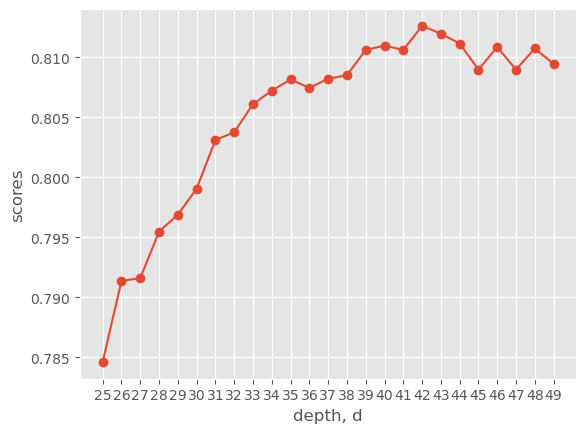

In [169]:
# Run an inertia model to identify the best number of depths for the classifier

depth = range(25,50)
scores = []

for d in depth: 
    classifier = DecisionTreeClassifier(max_depth = d, random_state=42)
    classifier = classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_test, y_test))
    print("iteration {} done".format(d))

plt.plot(depth, scores, '-o')
plt.xlabel('depth, d')
plt.ylabel('scores')
plt.xticks(depth)
plt.show()

In [170]:
#Create a second Decision Tree Classifier
classifier2 = DecisionTreeClassifier(max_depth=38, random_state=42)
classifier2 = classifier2.fit(X_train, y_train)
classifier2.score(X_test, y_test)

0.8085168869309839

In [171]:
# Print the confusion matrix and classification report
dt_preds2 = classifier2.predict(X_test)
print(confusion_matrix(y_test, dt_preds2))
print(classification_report(y_test, dt_preds2))

[[5161 1539]
 [1721 8604]]
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76      6700
         1.0       0.85      0.83      0.84     10325

    accuracy                           0.81     17025
   macro avg       0.80      0.80      0.80     17025
weighted avg       0.81      0.81      0.81     17025



In [172]:
# Find out which of the features are the most important in the first classifier
dt_fi = pd.DataFrame(classifier.feature_importances_)
names = pd.DataFrame(list(X.columns))
df_feat_imp = pd.concat([dt_fi, names], axis = 1)
df_feat_imp.columns = ['Importance','Features']
df_feat_imp.sort_values('Importance', ascending = False)

Importance                        Features
11    0.421128             MQuotedTotalPayment
4     0.186491  Discretionary_Spending_Dollars
0     0.145465                  Income_Dollars
1     0.103766                             Age
7     0.028916                       Predict_4
2     0.026881             Adults_in_Household
3     0.025946                 Househoold_Size
10    0.022721                   Household_Cat
6     0.013716                         Married
5     0.013498                       Homeowner
8     0.006197                         Age_Cat
9     0.005275                      Income_Cat

In [173]:
# Find out which of the features are the most important in the second classifier
dt_fi2 = pd.DataFrame(classifier2.feature_importances_)
names = pd.DataFrame(list(X.columns))
df_feat_imp2 = pd.concat([dt_fi2, names], axis = 1)
df_feat_imp2.columns = ['Importance','Features']
df_feat_imp2.sort_values('Importance', ascending = False)

Importance                        Features
11    0.416258             MQuotedTotalPayment
4     0.187401  Discretionary_Spending_Dollars
0     0.147746                  Income_Dollars
1     0.107020                             Age
7     0.030183                       Predict_4
2     0.027066             Adults_in_Household
3     0.026590                 Househoold_Size
10    0.021858                   Household_Cat
5     0.013937                       Homeowner
6     0.012849                         Married
8     0.005008                         Age_Cat
9     0.004084                      Income_Cat

In [174]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=90, max_depth = 10, random_state=42)
rf = rf.fit(X_train, y_train)
# Find out which of the features are the most important in the second classifier
dt_fi2 = pd.DataFrame(classifier2.feature_importances_)
names = pd.DataFrame(list(X.columns))
df_feat_imp2 = pd.concat([dt_fi2, names], axis = 1)
df_feat_imp2.columns = ['Importance','Features']
df_feat_imp2.sort_values('Importance', ascending = False)

Importance                        Features
11    0.416258             MQuotedTotalPayment
4     0.187401  Discretionary_Spending_Dollars
0     0.147746                  Income_Dollars
1     0.107020                             Age
7     0.030183                       Predict_4
2     0.027066             Adults_in_Household
3     0.026590                 Househoold_Size
10    0.021858                   Household_Cat
5     0.013937                       Homeowner
6     0.012849                         Married
8     0.005008                         Age_Cat
9     0.004084                      Income_Cat

#### The decision tree models depended heavily upon the MQuotedTotalPayment, which makes sense. If the payment combined with their income is a certain amount, they are more likely to choose to get the insurance. 

### Random Forest Model

In [175]:
# Print the scores
score = rf.score(X_test, y_test)
print(score)
rf_pred = rf.predict(X_test)
rf_pred = pd.DataFrame(rf_pred)
# Rename the column Predict_RF
rf_pred = rf_pred.rename(columns = {0: 'Predict_RF'})

0.690337738619677


In [176]:
# Print the confusion matrix and classification report
print(confusion_matrix(y_test,rf_pred))
print("")
print(classification_report(y_test, rf_pred))

[[ 1534  5166]
 [  106 10219]]

              precision    recall  f1-score   support

         0.0       0.94      0.23      0.37      6700
         1.0       0.66      0.99      0.79     10325

    accuracy                           0.69     17025
   macro avg       0.80      0.61      0.58     17025
weighted avg       0.77      0.69      0.63     17025



In [177]:
# Discover the most important features in the Random Forest Classifier
fi = pd.DataFrame(rf.feature_importances_)
columns = pd.DataFrame(list(X.columns))
features = pd.concat([columns, fi], axis=1)
features.columns = ['Feature','Importance']
features.sort_values('Importance', ascending=False)

Feature  Importance
11             MQuotedTotalPayment    0.705401
4   Discretionary_Spending_Dollars    0.073781
0                   Income_Dollars    0.063622
1                              Age    0.052285
3                  Househoold_Size    0.021791
7                        Predict_4    0.021456
2              Adults_in_Household    0.018756
10                   Household_Cat    0.014739
5                        Homeowner    0.008449
6                          Married    0.007522
8                          Age_Cat    0.006742
9                       Income_Cat    0.005455

#### Here it appears that the MQuotedTotalPayment is becoming increasingly weighty in the model. 

In [178]:
# Run an inertia model to identify the best number of depths for the classifier

depth = range(25,35)
scores = []

for d in depth: 
    rf = RandomForestClassifier(n_estimators=90, max_depth = d, random_state=42)
    rf = rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))
    print("iteration {} done".format(d))

plt.plot(depth, scores, '-o')
plt.xlabel('depth, d')
plt.ylabel('scores')
plt.xticks(depth)
plt.show()

iteration 25 done



KeyboardInterrupt



In [ ]:
# The plot 

n_estimators_range = range(120,150,10)  # Range of n_estimators 
max_depth_range = range(31,35)  # Range of max_depth 

# Initialize variables to store best parameters and score
best_score = 0
best_params = {'n_estimators': None, 'max_depth': None}

# Initialize lists to store scores for each combination
scores = []

# Loop over each combination of n_estimators and max_depth
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        # Create and train the Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate the score on the test set
        score = rf.score(X_test, y_test)
        
        # Store the score and parameters
        scores.append((n_estimators, max_depth, score))
        
        # Update the best score and parameters if score beats the best one so far
        if score > best_score:
            best_score = score
            best_params['n_estimators'] = n_estimators
            best_params['max_depth'] = max_depth
        
        #prints the progress, turned off for the sake of visuals
        #print("n_estimators: {}, max_depth: {}, score: {:.4f}".format(n_estimators, max_depth, score))
    print("n_estimator {} is done".format(n_estimators))
    
# Extracts n_estimators, max_depth, and scores for visual
n_estimators_values = [s[0] for s in scores]
max_depth_values = [s[1] for s in scores]
scores_values = [s[2] for s in scores]

# Plot the scores
plt.figure(figsize=(10, 6))
# Set the scatter plot to show max_depth on the x, n_estimators on the y
# set the colors as score_values, and the color gradient to 'magma'
plt.scatter(max_depth_values, n_estimators_values, c=scores_values, cmap='magma', marker='o')
plt.colorbar(label='Accuracy') # created a gradient bar to measure the accuracy (White is best purple worst)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Accuracy max_depth and n_estimators')
plt.grid(True) # Set it as a grid
plt.show()

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [179]:
rf = RandomForestClassifier(
        n_estimators=best_params['n_estimators']
        , max_depth = best_params['max_depth']
        , random_state=42
    )

rf = rf.fit(X_train, y_train)
# Print the scores 
score = rf.score(X_test, y_test)
print(score)
# Predict the model 
enhance_pred = rf.predict(X_test)
enhance_pred = pd.DataFrame(enhance_pred)
# Rename the column Predict_Enhance
enhance_pred = enhance_pred.rename(columns = {0: 'Predict_Enhance'})

NameError: name 'best_params' is not defined

In [180]:
# Print the confusion matrix and classification report
print(confusion_matrix(y_test, enhance_pred))
print("")
print(classification_report(y_test, enhance_pred))

NameError: name 'enhance_pred' is not defined

In [181]:
# Discover the most important features in the Random Forest Classifier
fi = pd.DataFrame(rf.feature_importances_)
columns = pd.DataFrame(list(X.columns))
features = pd.concat([columns, fi], axis=1)
features.columns = ['Feature','Importance']
features.sort_values('Importance', ascending=False)

Feature  Importance
0                   Income_Dollars         0.0
1                              Age         0.0
2              Adults_in_Household         0.0
3                  Househoold_Size         0.0
4   Discretionary_Spending_Dollars         0.0
5                        Homeowner         0.0
6                          Married         0.0
7                        Predict_4         0.0
8                          Age_Cat         0.0
9                       Income_Cat         0.0
10                   Household_Cat         0.0
11             MQuotedTotalPayment         0.0

### Test 2: Summary
- In this section, four tests were conducted: 
    - Decision Tree with unoptimized parameters. 
    - Decision Tree with optimized parameters
    - Random Forest with unoptimized parameters
    - Random Forest with one optimized parameter
    - Random Forest with multiple optimized parameters. 
- The Quoted Price, the Discretionary Spending and Income Dollars and Age make up nearly the entirity of the model when making a prediction whether someone is going to accept a policy of the prediction of whether or not someone will choose get a policy. Unfortunately, this is not a deep insight. Money drives demand. But it can give us a price modeller to test to potenially maximize the price we can charge for the policy given someone's discretionary income. 
- The Random Forest model was the most accurate, and it gave greater weight to the discretionary income and age factors than the decision trees. 
- More information about these tests are included below. 

## Question 2: Given a policy holders demographics, provide an estimation of their Paid Loss on a policy.

#### In this section, I am hoping to create a regression line that can predict the paid loss on a policy given the demographics and other information that is included in the claims. 

In [182]:
df_TheGeneral_PaidLoss = df_TheGeneral[['AbilitecContactID','ClaimTransPaidLoss','ClaimTransCount','ClaimCount','DaysToClaim']]

In [183]:
df_PaidLoss_Demo = pd.merge(df_Policy_Demo, df_TheGeneral_PaidLoss ,left_on='APID',right_on='AbilitecContactID', how='left')

In [184]:
df_PaidLoss_Demo = df_PaidLoss_Demo.dropna()

In [185]:
df_PaidLoss_Demo
y = df_PaidLoss_Demo['ClaimTransPaidLoss']

In [186]:
est1 = smf.ols(formula='ClaimTransPaidLoss ~ Discretionary_Spending_Dollars + Income_Dollars + Age + Predict_4 + Adults_in_Household + Househoold_Size + Homeowner + Married', data = df_PaidLoss_Demo).fit()

In [187]:
est1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ClaimTransPaidLoss   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     17.59
Date:                Mon, 26 Feb 2024   Prob (F-statistic):           1.79e-26
Time:                        00:23:46   Log-Likelihood:            -8.8996e+05
No. Observations:               91690   AIC:                         1.780e+06
Df Residuals:                   91681   BIC:                         1.780e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        551.5334     52.410     10.523      0.000     448.810     654.257
Discretionary_Spending_Dollars     0.0020      0.002      0.864      0.387      -0.003       0.007
Income_Dollars                     0.0025      0.000      6.310      0.000       0.002       0.003
Age                               -1.7971      0.852     -2.108      0.035      -3.468      -0.126
Predict_4                         55.3512     11.508      4.810      0.000      32.796      77.907
Adults_in_Household               59.0534     24.388      2.421      0.015      11.254     106.853
Househoold_Size                  -33.2123     17.995     -1.846      0.065     -68.482       2.057
Homeowner                        162.4159     30.965      5.245      0.000     101.726     223.106
Married                            0.9770     33.165      0.029      0.976     -64.026      65.980
==============================================================================
Omnibus:                   135910.397   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         57200817.522
Skew:                           9.176   Prob(JB):                         0.00
Kurtosis:                     123.978   Cond. No.                     2.76e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.76e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Well, that was not great... the model has an R^2 of .002. It is possible that the shape of my model is incorrect, but it is also likely that demographic information does not have a direct relationship with the total amount of information their policy costs when a claim is made.  

### Let's try it with SciKitLearn and less factors

In [188]:
X = df_PaidLoss_Demo.drop(['Age_Cat','Income_Cat','Household_Cat','APID', 'Discretionary_Spending_Dollars','AbilitecContactID','Married','Homeowner','Househoold_Size','GotPolicy','Adults_in_Household','ClaimTransPaidLoss','ClaimTransCount','ClaimCount', 'DaysToClaim'], axis =1)
y = df_PaidLoss_Demo['ClaimTransPaidLoss']

In [189]:
# Scale the X variable and name it X_scaled
scaler = StandardScaler()
X.columns = X.columns.astype(str)
X_scaled = scaler.fit_transform(X)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [191]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.006092287156925447

In [192]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred))

Mean Squared Error: 15603759.672996316
Coefficient of Determination (R^2): 0.006092287156925447


In [193]:
model.score(X_test, y_test)

0.006092287156925447

In [194]:
names = X.columns
multreg_coef = model.fit(X_train, y_train).coef_

In [195]:
df_multreg = pd.DataFrame([multreg_coef])

In [196]:
df_multreg.columns = names
df_multreg = df_multreg.T
df_multreg = df_multreg.rename(columns = {0: 'corr_coeff'})
df_multreg

corr_coeff
Income_Dollars         0.002995
Age                    0.141024
Predict_4             55.837235
MQuotedTotalPayment    0.202594

## Summary 
- Multiple Regression to predict a value for ClaimTransPaidLoss using demographic information was a failure. I did not realize that R^2 values could get that low. But there is seemingly no relationship that I can find between the Age of someone and the overall cost of the paid loss. 

## Question 3: Given demographics, what is the probability they will file a claim if they have a policy? 

In [197]:
# Dataframe of policy vs no policy
def filedClaim(ClaimCount):
    if ClaimCount == 0:
            return 0
    else:
        return 1

In [198]:
df_PolicyClaim_Demo = pd.merge(df_PolicyContact, df_demoInfo, left_on='AbilitecContactID', right_on='APID',how='left')

In [199]:
df_PolicyClaim_Demo = df_PolicyClaim_Demo.dropna()

In [200]:
df_PolicyClaim_Demo.loc[:,'FiledClaim'] = df_PolicyClaim_Demo.loc[:,'ClaimCount'].apply(filedClaim)

In [201]:
df_PolicyClaim_Demo = df_PolicyClaim_Demo.drop(['PolicyNumber','DriverNumber','AbilitecContactID','AbilitecHouseholdID','DriverCount','ClaimCount','TotalPaid','APID'], axis = 1)

In [202]:
X = df_PolicyClaim_Demo.drop(['FiledClaim'], axis=1)
y = df_PolicyClaim_Demo['FiledClaim']

In [203]:
# Scale the X variable and name it X_reg_scaled
scaler = StandardScaler()
X.columns = X.columns.astype(str)
X_reg_scaled = scaler.fit_transform(X)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_reg_scaled,y, test_size=0.3, random_state=42)

In [205]:

model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)
y_preds = model.predict(X_test)
y_preds = pd.DataFrame(y_preds)
y_preds = y_preds.rename(columns = {0: 'Predictions'})

In [206]:
# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_preds))
print("")
print(classification_report(y_test, y_preds))

[[7946    0]
 [2134    0]]

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      7946
           1       0.00      0.00      0.00      2134

    accuracy                           0.79     10080
   macro avg       0.39      0.50      0.44     10080
weighted avg       0.62      0.79      0.69     10080



C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Once again the Logistic Model just guessed all one or the other for high accuracy. This time it guessed 100% No, which leads to it having a nearly 80% accuracy rate... Maybe it needs to be skewed, but I think lasso and ridge regression would only make it slightly better than absolutely useless. 

### Decision Tree to see if it has better luck distributing the values

In [207]:
# Create a Decision Tree Classifier
classifier = DecisionTreeClassifier(random_state=42)
classifier = classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

0.6941468253968254

In [208]:
# Create a predicted variable
dt_preds = classifier.predict(X_test)
dt_preds = pd.DataFrame(dt_preds)
# Rename the column Predict_Tree
dt_preds = dt_preds.rename(columns = {0: 'Predict_Tree'})

In [209]:
# Print confusion matrix and classification report
print(confusion_matrix(y_test, dt_preds))
print("")
print(classification_report(y_test, dt_preds))

[[6597 1349]
 [1734  400]]

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7946
           1       0.23      0.19      0.21      2134

    accuracy                           0.69     10080
   macro avg       0.51      0.51      0.51     10080
weighted avg       0.67      0.69      0.68     10080



iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done


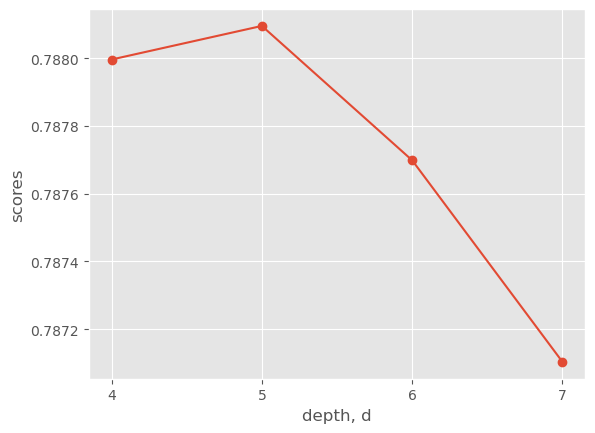

In [210]:
# Run an inertia model to identify the best number of depths for the classifier

depth = range(4,8)
scores = []

for d in depth: 
    classifier = DecisionTreeClassifier(max_depth = d, random_state=42)
    classifier = classifier.fit(X_train, y_train)
    scores.append(classifier.score(X_test, y_test))
    print("iteration {} done".format(d))

plt.plot(depth, scores, '-o')
plt.xlabel('depth, d')
plt.ylabel('scores')
plt.xticks(depth)
plt.show()

In [211]:
#Create a second Decision Tree Classifier
classifier2 = DecisionTreeClassifier(max_depth=25, random_state=42)
classifier2 = classifier2.fit(X_train, y_train)
classifier2.score(X_test, y_test)

0.7142857142857143

In [212]:
# Print the confusion matrix and classification report
dt_preds2 = classifier2.predict(X_test)
print(confusion_matrix(y_test, dt_preds2))
print(classification_report(y_test, dt_preds2))

[[6858 1088]
 [1792  342]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      7946
           1       0.24      0.16      0.19      2134

    accuracy                           0.71     10080
   macro avg       0.52      0.51      0.51     10080
weighted avg       0.68      0.71      0.69     10080



### I chose a different max_depth value, becuase it seems like the model is just gravitating towards guessing No for 79% accuracy. I'm unable to get the model to et above that accuracy rate. 

In [213]:
# Find out which of the features are the most important in the second classifier
dt_fi2 = pd.DataFrame(classifier2.feature_importances_)
names = pd.DataFrame(list(X.columns))
df_feat_imp2 = pd.concat([dt_fi2, names], axis = 1)
df_feat_imp2.columns = ['Importance','Features']
df_feat_imp2.sort_values('Importance', ascending = False)

Importance                        Features
4     0.354110  Discretionary_Spending_Dollars
0     0.258926                  Income_Dollars
1     0.187009                             Age
2     0.052304             Adults_in_Household
3     0.047375                 Househoold_Size
10    0.038038                   Household_Cat
6     0.026092                         Married
5     0.019588                       Homeowner
8     0.006919                         Age_Cat
7     0.005398                       Predict_4
9     0.004240                      Income_Cat

#### This model agrees that finances and age are the most important factors of whether or not a claim will be filed, but that is likely due to the lack of anything else relavant. 

### Let's try a random forest just to see if it will work

In [214]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=90, max_depth = 10, random_state=42)
rf = rf.fit(X_train, y_train)

In [215]:
# Print the scores
score = rf.score(X_test, y_test)
print(score)
rf_pred = rf.predict(X_test)
rf_pred = pd.DataFrame(rf_pred)
# Rename the column Predict_RF
rf_pred = rf_pred.rename(columns = {0: 'Predict_RF'})

0.7881944444444444


In [216]:
# Print the confusion matrix and classification report
print(confusion_matrix(y_test,rf_pred))
print("")
print(classification_report(y_test, rf_pred))

[[7942    4]
 [2131    3]]

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      7946
           1       0.43      0.00      0.00      2134

    accuracy                           0.79     10080
   macro avg       0.61      0.50      0.44     10080
weighted avg       0.71      0.79      0.70     10080



In [217]:
# Discover the most important features in the Random Forest Classifier
fi = pd.DataFrame(rf.feature_importances_)
columns = pd.DataFrame(list(X.columns))
features = pd.concat([columns, fi], axis=1)
features.columns = ['Feature','Importance']
features.sort_values('Importance', ascending=False)

Feature  Importance
4   Discretionary_Spending_Dollars    0.284711
0                   Income_Dollars    0.240785
1                              Age    0.185598
7                        Predict_4    0.057500
2              Adults_in_Household    0.053748
3                  Househoold_Size    0.053615
10                   Household_Cat    0.036783
6                          Married    0.028329
5                        Homeowner    0.027779
8                          Age_Cat    0.017750
9                       Income_Cat    0.013403

#### Nope. Another instance of the model guessing one way in order to maintain high accuracy.  

iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done
iteration 10 done
iteration 11 done
iteration 12 done


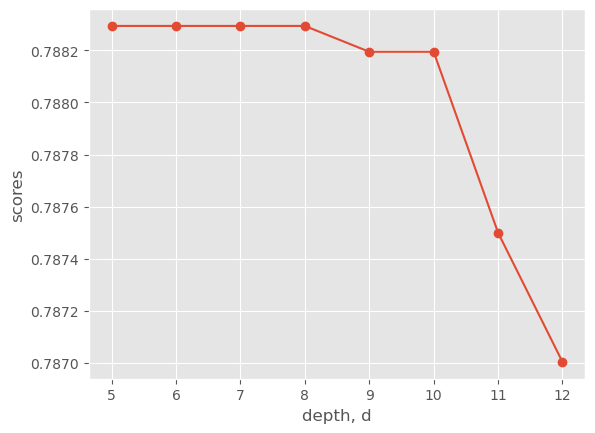

In [218]:
# Run an inertia model to identify the best number of depths for the classifier

depth = range(5,13)
scores = []

for d in depth: 
    rf = RandomForestClassifier(n_estimators=90, max_depth = d, random_state=42)
    rf = rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))
    print("iteration {} done".format(d))

plt.plot(depth, scores, '-o')
plt.xlabel('depth, d')
plt.ylabel('scores')
plt.xticks(depth)
plt.show()

n_estimator 10 is done
n_estimator 20 is done
n_estimator 30 is done
n_estimator 40 is done
n_estimator 50 is done


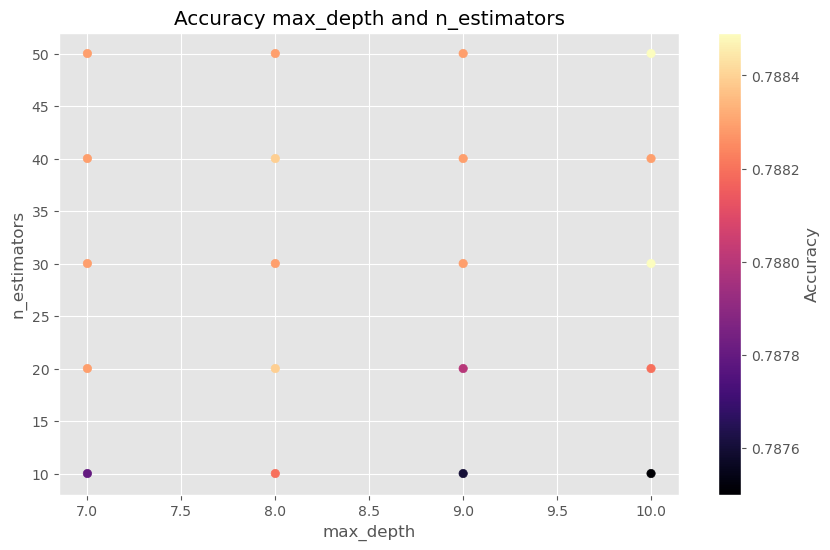

Best Parameters: {'n_estimators': 30, 'max_depth': 10}
Best Score: 0.7884920634920635


In [219]:
# The plot 

n_estimators_range = range(10,60,10)  # Range of n_estimators 
max_depth_range = range(7,11)  # Range of max_depth 

# Initialize variables to store best parameters and score
best_score = 0
best_params = {'n_estimators': None, 'max_depth': None}

# Initialize lists to store scores for each combination
scores = []

# Loop over each combination of n_estimators and max_depth
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        # Create and train the Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        rf.fit(X_train, y_train)
        
        # Calculate the score on the test set
        score = rf.score(X_test, y_test)
        
        # Store the score and parameters
        scores.append((n_estimators, max_depth, score))
        
        # Update the best score and parameters if score beats the best one so far
        if score > best_score:
            best_score = score
            best_params['n_estimators'] = n_estimators
            best_params['max_depth'] = max_depth
        
        #prints the progress, turned off for the sake of visuals
        #print("n_estimators: {}, max_depth: {}, score: {:.4f}".format(n_estimators, max_depth, score))
    print("n_estimator {} is done".format(n_estimators))
    
# Extracts n_estimators, max_depth, and scores for visual
n_estimators_values = [s[0] for s in scores]
max_depth_values = [s[1] for s in scores]
scores_values = [s[2] for s in scores]

# Plot the scores
plt.figure(figsize=(10, 6))
# Set the scatter plot to show max_depth on the x, n_estimators on the y
# set the colors as score_values, and the color gradient to 'magma'
plt.scatter(max_depth_values, n_estimators_values, c=scores_values, cmap='magma', marker='o')
plt.colorbar(label='Accuracy') # created a gradient bar to measure the accuracy (White is best purple worst)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.title('Accuracy max_depth and n_estimators')
plt.grid(True) # Set it as a grid
plt.show()

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

In [220]:
rf = RandomForestClassifier(
        n_estimators=50
        , max_depth = best_params['max_depth']
        , random_state=42
        , criterion='entropy'
        , min_samples_split=4
        , min_samples_leaf=3
    )

rf = rf.fit(X_train, y_train)
# Print the scores 
score = rf.score(X_test, y_test)
print(score)
# Predict the model 
enhance_pred = rf.predict(X_test)
enhance_pred = pd.DataFrame(enhance_pred)
# Rename the column Predict_Enhance
enhance_pred = enhance_pred.rename(columns = {0: 'Predict_Enhance'})

0.7882936507936508


In [221]:
# Print the confusion matrix and classification report
print(confusion_matrix(y_test, enhance_pred))
print("")
print(classification_report(y_test, enhance_pred))

[[7946    0]
 [2134    0]]

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      7946
           1       0.00      0.00      0.00      2134

    accuracy                           0.79     10080
   macro avg       0.39      0.50      0.44     10080
weighted avg       0.62      0.79      0.69     10080



C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [222]:
# Discover the most important features in the Random Forest Classifier
fi = pd.DataFrame(rf.feature_importances_)
columns = pd.DataFrame(list(X.columns))
features = pd.concat([columns, fi], axis=1)
features.columns = ['Feature','Importance']
features.sort_values('Importance', ascending=False)

Feature  Importance
4   Discretionary_Spending_Dollars    0.294329
0                   Income_Dollars    0.239796
1                              Age    0.182120
7                        Predict_4    0.061443
3                  Househoold_Size    0.051763
2              Adults_in_Household    0.045895
10                   Household_Cat    0.036931
5                        Homeowner    0.029974
6                          Married    0.025983
8                          Age_Cat    0.019219
9                       Income_Cat    0.012546

#### Ultimately, this model was not worth exploring. It is possible that there is additional information in these files that would give me a clearer vision of predicting whether a claim would be filed.  

## Running K Means on the same model to see if anything emerges

In [223]:
model = KMeans(n_clusters=3, n_init=10)
model.fit(df_PolicyClaim_Demo)
labels3raw = model.predict(df_PolicyClaim_Demo)
labels3raw = pd.DataFrame(labels3raw)
labels3raw = labels3raw.rename(columns = {0: 'labels3raw'})

iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done
iteration 10 done
iteration 11 done
iteration 12 done
iteration 13 done
iteration 14 done
iteration 15 done
iteration 16 done
iteration 17 done
iteration 18 done
iteration 19 done
iteration 20 done


<function matplotlib.pyplot.show(close=None, block=None)>

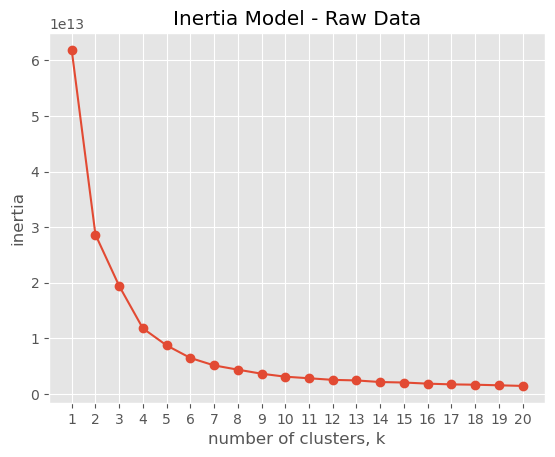

In [224]:
# Create inertia model using "ks=range(1,21)", add print("iteration {} done".format(k)) to keep tabs
ks = range(1,21)
inertias = []

for k in ks: 
    model = KMeans(n_clusters = k, n_init=2)
    model.fit(df_PolicyClaim_Demo)
    inertias.append(model.inertia_)
    print(f"iteration {k} done")
    
plt.plot(ks, inertias, '-o')
plt.title('Inertia Model - Raw Data')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show

In [225]:
results = pd.concat([df_PolicyClaim_Demo, labels3raw], axis=1, join='inner')

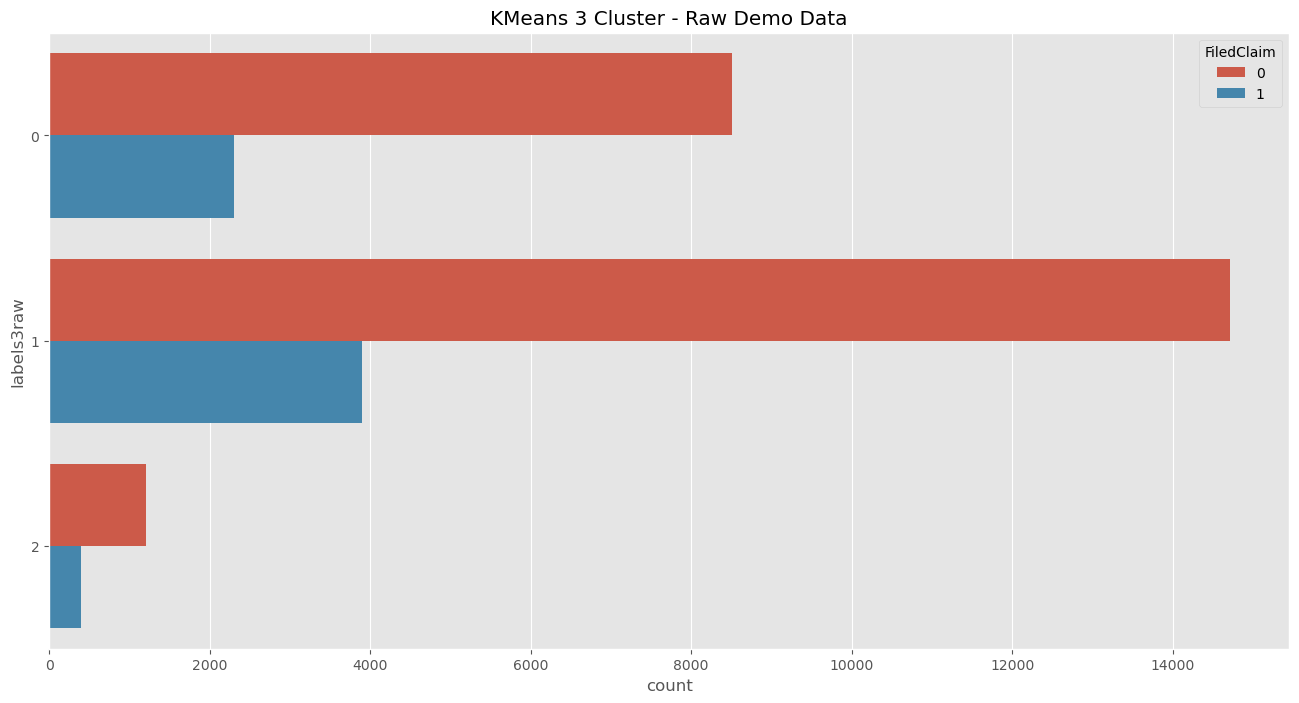

In [226]:
# Create a countplot for results of the raw and scaled data predictions 
plt.figure(figsize = (16,8))
sns.countplot(y="labels3raw",hue='FiledClaim', data = results)
plt.title('KMeans 3 Cluster - Raw Demo Data')
plt.show()

### Try again with 4 clusters instead of 3

In [227]:
model = KMeans(n_clusters=4, n_init=10)
model.fit(df_PolicyClaim_Demo)
labels4raw = model.predict(df_PolicyClaim_Demo)
labels4raw = pd.DataFrame(labels4raw)
labels4raw = labels4raw.rename(columns = {0: 'labels4raw'})

In [228]:
results = pd.concat([results,labels4raw], axis=1, join='inner')

Text(0.5, 1.0, '4 Clusters - Raw Demo Data')

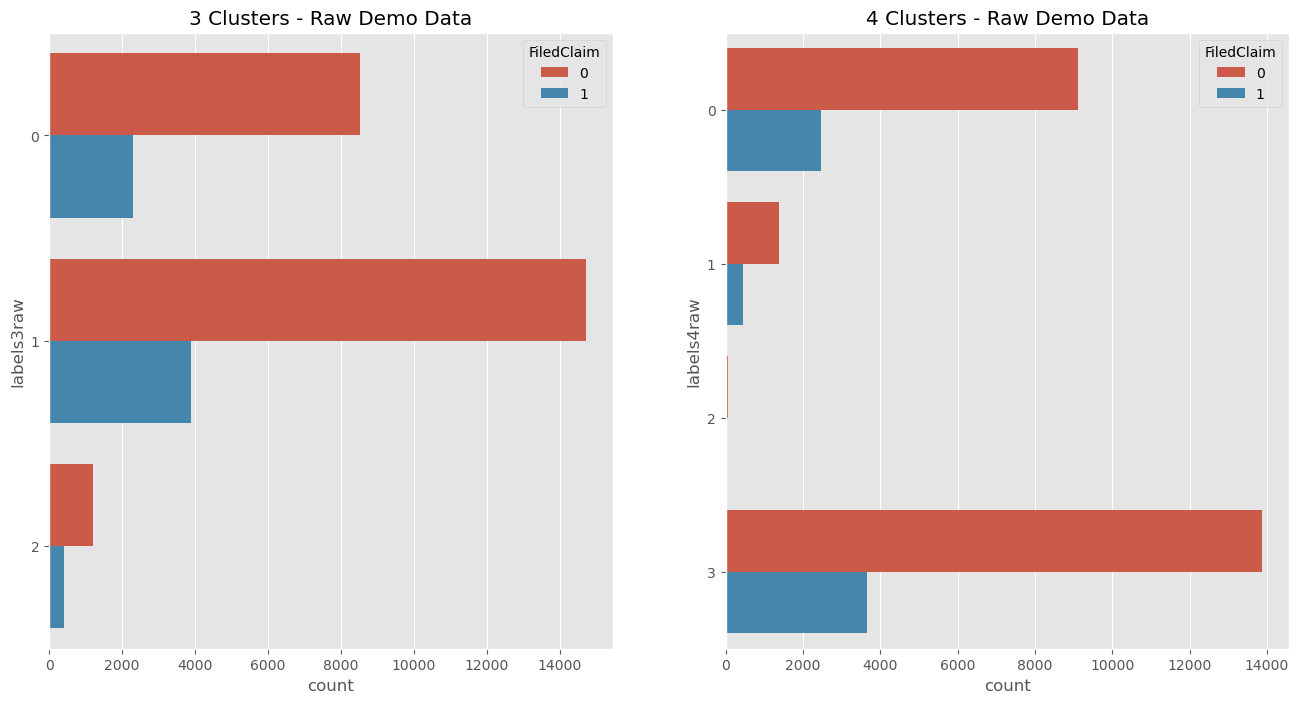

In [229]:
fig, axes = plt.subplots(1,2, figsize = (16,8))
sns.countplot(y="labels3raw",hue='FiledClaim', ax = axes[0], data = results)
axes[0].set_title('3 Clusters - Raw Demo Data')
sns.countplot(y="labels4raw",hue='FiledClaim', ax = axes[1], data = results)
axes[1].set_title('4 Clusters - Raw Demo Data')

In [230]:
# This code splits out the resulting rows for each cluster group into their own DataFrame for a deeper dive into their characteristics
cluster0 = results[results['labels4raw'] == 0]
cluster1 = results[results['labels4raw'] == 1]
cluster2 = results[results['labels4raw'] == 2]
cluster3 = results[results['labels4raw'] == 3]
cluster0 = pd.DataFrame(cluster0)
cluster1 = pd.DataFrame(cluster1)
cluster2 = pd.DataFrame(cluster2)
cluster3 = pd.DataFrame(cluster3)


In [231]:
# This code analyzes some of the attributes that may be influencing the clustering.

num_clusters = 4
attributes = [ 'Discretionary_Spending_Dollars', 'Income_Dollars', 'Age', 'Predict_4', 'Househoold_Size', 'Adults_in_Household', 'Household_Cat', 'Homeowner']
means = {attr: [] for attr in attributes} # dictionary to store mean attributes
count = {attr: [] for attr in attributes} # dictionary to store counts of each attribute

# For loop to define dictionary for means and count of each attribute
for i in range(num_clusters):
    cluster_name = f"cluster{i}"
    cluster_df = eval(cluster_name)
    
    for attr in attributes:
        means[attr].append(cluster_df[attr].mean())
        count[attr].append(cluster_df[attr].count())

# For loop to display the values for quick analysis
for attr in attributes:
    print(f"{attr.upper()} ")
    for i in range(num_clusters):
        if attr != 'dti': 
            print(f"Mean {attr} for cluster{i}: {int(means[attr][i])} ({count[attr][i]} entries)")
        else: 
            print(f"Mean {attr} for cluster{i}: {means[attr][i]} ({count[attr][i]} entries)")
    print("\n")   

DISCRETIONARY_SPENDING_DOLLARS 
Mean Discretionary_Spending_Dollars for cluster0: 8358 (11597 entries)
Mean Discretionary_Spending_Dollars for cluster1: 8879 (1824 entries)
Mean Discretionary_Spending_Dollars for cluster2: 9065 (76 entries)
Mean Discretionary_Spending_Dollars for cluster3: 8133 (17539 entries)


INCOME_DOLLARS 
Mean Income_Dollars for cluster0: 58552 (11597 entries)
Mean Income_Dollars for cluster1: 66650 (1824 entries)
Mean Income_Dollars for cluster2: 86986 (76 entries)
Mean Income_Dollars for cluster3: 54009 (17539 entries)


AGE 
Mean Age for cluster0: 46 (11597 entries)
Mean Age for cluster1: 47 (1824 entries)
Mean Age for cluster2: 48 (76 entries)
Mean Age for cluster3: 46 (17539 entries)


PREDICT_4 
Mean Predict_4 for cluster0: 1 (11597 entries)
Mean Predict_4 for cluster1: 1 (1824 entries)
Mean Predict_4 for cluster2: 1 (76 entries)
Mean Predict_4 for cluster3: 1 (17539 entries)


HOUSEHOOLD_SIZE 
Mean Househoold_Size for cluster0: 2 (11597 entries)
Mean House

### Summary
- The KMeans analysis also did not produce anything meaningful. The only thing that was found was that incomes were different amongst the two clusters. Maybe that is really all there is to go off in the relationship of claims to policy holders in this data

### Question 5: Can I run regression on the ClaimType, VehicleID, The Abilitech Info and Predict the PaidLoss

In [232]:
df_ClaimMasterTrans_CTP = df_ClaimMasterTrans[['PolicyNumber']]
df_TheGeneralInfo = df_TheGeneral[['PolicyNumber','AbilitecContactID','AtFaultDescription','DriverID','VehicleID','ClaimTransPaidLoss','ClaimType','ClaimCount']]

In [233]:
df_ClaimMasterTrans_CTP = pd.merge(df_ClaimMasterTrans_CTP, df_TheGeneralInfo, on = 'PolicyNumber',how='left')

In [234]:
df_ClaimMasterTrans_CTP = pd.merge(df_ClaimMasterTrans_CTP, df_abilitechInfo, left_on = 'AbilitecContactID', right_on='AbilitecContactID', how='left')

In [235]:
df_ClaimMasterTrans_CTP.describe()

DriverID     VehicleID  ClaimTransPaidLoss    ClaimCount  \
count  20930.000000  20930.000000        20930.000000  20930.000000   
mean      20.605686      3.544099         4021.079330      2.962637   
std       38.769363     33.261606         8521.171022      2.099635   
min        0.000000      1.000000            0.000000      1.000000   
25%        1.000000      1.000000            0.000000      1.000000   
50%        1.000000      2.000000          859.905000      2.000000   
75%        3.000000      3.000000         4062.735000      4.000000   
max       99.000000    998.000000       113840.050000     13.000000   

       AP003732_Influenced_to_Purchase_Athletic_Shoe_Store_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4869  \
count                                       20930.000000                                                          
mean                                            8.566460                                                          
std                                             5.466144                                                          
min                                             0.000000                                                          
25%                                             4.000000                                                          
50%                                             8.000000                                                          
75%                                            13.000000                                                          
max                                            20.000000                                                          

       AP003733_Influenced_to_Purchase_Discount_Mass_Merchant_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4870  \
count                                       20930.000000                                                             
mean                                            8.351983                                                             
std                                             5.470801                                                             
min                                             0.000000                                                             
25%                                             4.000000                                                             
50%                                             8.000000                                                             
75%                                            13.000000                                                             
max                                            20.000000                                                             

       AP003734_Influenced_to_Purchase_Department_Store_Footwear_Due_to_Advertising_V2_rank_base_20_rbgm4871  \
count                                       20930.000000                                                       
mean                                           11.268036                                                       
std                                             5.209126                                                       
min                                             1.000000                                                       
25%                                             7.000000                                                       
50%                                            11.000000                                                       
75%                                            15.000000                                                       
max                                            20.000000                                                       

       AP003739_Influenced_to_Purchase_Apparel_Specialty_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4876  \
count                                       20930.000000                                                        
mean                                 

In [236]:
categories = df_ClaimMasterTrans_CTP[['AtFaultDescription']].values
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(categories)
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['AtFaultDescription']))
df_combined = pd.concat([df_ClaimMasterTrans_CTP.drop('AtFaultDescription', axis=1), encoded_df], axis=1)

categories = df_combined[['ClaimType']].values
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(categories)
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['ClaimType']))
df_combined = pd.concat([df_combined.drop('ClaimType', axis=1), encoded_df], axis=1)



C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [237]:
df_combined

PolicyNumber AbilitecContactID  DriverID  VehicleID  \
0      Q080MDE1MTY2  04ZJUS02EXPR09CB        98          1   
1      Q080MDEwOTEx  04ZJUS0146KL4TTS         1          1   
2      Q080MDExOTIz  04ZJUS02K2KC7DMW         1          1   
3      Q080MDIyMDcw  04ZJUS022XH2NVJ5        98          2   
4      Q080MDIyMDcw  04ZJUS022XH2NVJ5         1          2   
...             ...               ...       ...        ...   
20925  VlQzOTQzOTAy  04ZJUS01E9Y3261W         1          1   
20926  VlQzOTc5NTgz  04ZJUS020YQDGQSJ         0          2   
20927  VlQzOTcyODE2  04ZJUS11XYCBBER5        99          1   
20928  VlQzOTg0NzI5  04ZJUS022QSF2Q0W         1          1   
20929  VlQzOTkyMDU0  04ZJUS013XX7Q97C        98          1   

       ClaimTransPaidLoss  ClaimCount  \
0                 5086.61         1.0   
1                    0.00         1.0   
2                21397.74         1.0   
3                    0.00         3.0   
4                    0.00         3.0   
...                   ...         ...   
20925                0.00         1.0   
20926                0.00         1.0   
20927             2876.38         1.0   
20928                0.00         1.0   
20929              596.94         1.0   

       AP003732_Influenced_to_Purchase_Athletic_Shoe_Store_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4869  \
0                                                   10.0                                                          
1                                                    2.0                                                          
2                                                    6.0                                                          
3                                                    8.0                                                          
4                                                    8.0                                                          
...                                                  ...                                                          
20925                                                3.0                                                          
20926                                               10.0                                                          
20927                                                0.0                                                          
20928                                                9.0                                                          
20929                                               14.0                                                          

       AP003733_Influenced_to_Purchase_Discount_Mass_Merchant_Footwear_Due_to_Advertising_V2_rank_base_20_RBGM4870  \
0                                                   16.0                                                             
1                                                    4.0                                                             
2                                                    2.0                                                             
3                                                   15.0                                                             
4                                                   15.0                                                             
...                                                  ...                                                             
20925                                               10.0                                                             
20926                                                6.0                                                             
20927                                                0.0                                                             
20928                                                1.0                                                             
20929                                               17.0                                  

In [238]:
X = df_combined.drop(['PolicyNumber','AbilitecContactID','ClaimTransPaidLoss'], axis = 1)
y = df_combined['ClaimTransPaidLoss']

# Scale the X variable and name it X_reg_scaled
scaler = StandardScaler()
X.columns = X.columns.astype(str)
X_reg_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.12628474036377668

### Summary
- It is possible that this dataset is too large to give any meaningful insight. It likely has too much noise from unneeded data points. I will try running Lasso and Ridge regression to see if it gets more accurate. 

C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.700e+09, tolerance: 1.109e+08
  model = cd_fast.enet_coordinate_descent(


iteration 30 done


C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.760e+09, tolerance: 1.109e+08
  model = cd_fast.enet_coordinate_descent(


iteration 50 done
iteration 100 done


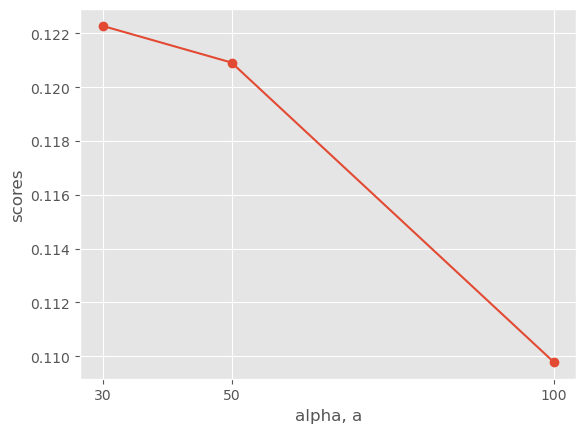

In [239]:
# Run a function to find the best alpha
alphas = [30,50,100] #approximate the alpha value
scores = []

for a in alphas: 
    lasso = Lasso(alpha = a)
    lasso.fit(X_train, y_train)
    scores.append(lasso.score(X_test, y_test))
    print("iteration {} done".format(a))

plt.plot(alphas, scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

In [246]:
lasso = Lasso(alpha = 30)
lasso.fit(X_train, y_train)
lasso.score(X_test, y_test)

C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.700e+09, tolerance: 1.109e+08
  model = cd_fast.enet_coordinate_descent(


0.12227719081417854

In [248]:
# Create a dataframe that shows the name and coefficient of features
names = X.columns
lasso_coef = lasso.fit(X,y).coef_ # save the coefficients to a series

C:\Users\j8k-o\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e+10, tolerance: 1.520e+08
  model = cd_fast.enet_coordinate_descent(


In [249]:
df_lasso = pd.DataFrame([lasso_coef]) #place the coefficients in a dataframe
df_lasso.columns = names
df_lasso = df_lasso.T #transpose the columns
df_lasso = df_lasso.rename(columns = {0:'corr_coeff'}) #rename the 0 column to corr_coeff
df_lasso

corr_coeff
DriverID                                              4.298239
VehicleID                                             0.152485
ClaimCount                                          170.995088
AP003732_Influenced_to_Purchase_Athletic_Shoe_S...   39.492169
AP003733_Influenced_to_Purchase_Discount_Mass_M...   35.451591
...                                                        ...
ClaimType_TRAINBUSCOLL                                0.000000
ClaimType_UNVERIFIED                                 -0.000000
ClaimType_UNVERIFIED W/INJURY                        -0.000000
ClaimType_VANDALISM                                  -0.000000
ClaimType_VEHCOLLISION                                0.000000

[298 rows x 1 columns]

iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 10 done


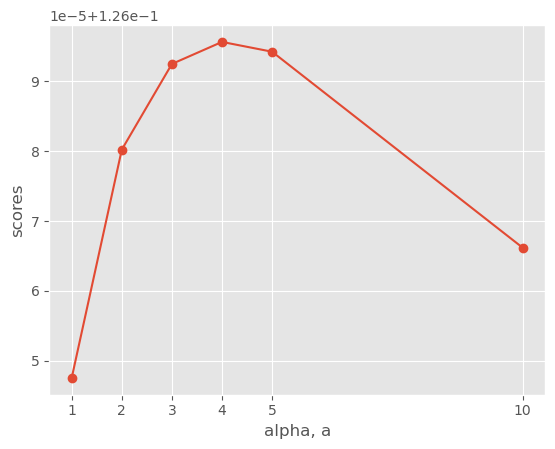

In [250]:
# Using ridge, conduct a regression
alphas = [1,2,3,4,5,10] # use a rough approach to approximate the alpha value. 
scores = []
for a in alphas: 
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    scores.append(ridge.score(X_test, y_test))
    print("iteration {} done".format(a))
    
plt.plot(alphas,scores, '-o')
plt.xlabel('alpha, a')
plt.ylabel('scores')
plt.xticks(alphas)
plt.show()

In [251]:
ridge = Ridge(alpha=4) # set the alpha to 7.25. The normalize command is deprecated. 
ridge.fit(X_train, y_train) # fit the model to the training data
ridge_pred = ridge.predict(X_test) #predict the test values
ridge.score(X_test,y_test)

0.12609562586157963

In [252]:
# Create a dataframe that shows the name of the feature and coefficients
ridge_coef = ridge.fit(X,y).coef_ #save the coefficients of the ridge model into a new ridge_coef variable

df_ridge = pd.DataFrame(ridge_coef).T # create a new dataframe from the coefficients, and then transpose the dataframe
df_ridge.columns = names # Sets the columns to the list of names of features
df_ridge = df_ridge.T # transposes the dataframe again. 
df_ridge = df_ridge.rename(columns = {0:'corr_coeff'})
df_ridge # displays the dataframe
df_ridge = df_ridge['corr_coeff'].sort_values(ascending = False)

df_ridge

ClaimType_ROLLOVER                     5869.972006
ClaimType_PEDCOLLISION                 4657.058675
ClaimType_LEFTCOLLISION                3506.674802
ClaimType_PG_COLLISIONINTERSECTION     3443.779381
ClaimType_PG_FLOOD                     3009.813200
                                          ...     
ClaimType_PD ONLY (2 CARS)            -2824.749278
ClaimType_NEW YORK/NEW JERSEY         -3112.830560
ClaimType_PG_COLLISIONWITHPARKEDCAR   -3324.763047
ClaimType_PG_COLLISIONBACKING         -3343.023936
ClaimType_COV ISSUE 2 OR LESS VEHS    -4021.378077
Name: corr_coeff, Length: 298, dtype: float64

########################################################################################################################

## Final Summary

## Intro
- In this workbook, I brought in datasets, cleaned them, merged them together to form the basis for an exploration into the ways that data could be used to help The General auto insurance improve their business. 

## Section 1: Import Libraries

- In Section 1, I imported all the neccessary libraries used in this work. This was a mostly straight forward task, but I found that I needed to come back and continue to import libraries as I got deeper into the notebook. 

## Section 2: Import Data
- This section was also relatively straight forward, I imported the data into temp dataframes from their original csv format. This gave me a couple of issues, but I was able to solve them by reading the error messages. 
- I returned to this section frequently to completely reset my data, as I accidentally destroyed my dataframes multiple times. 

## Section 3: Clean Data
- In this section, I looked at the structure and contents of the original data and identified where they needed to be cleaned. I filled in null values, removed errors due to typos or machine generated false dates, and dropped the duplicates values that would complicate the merging and exploration phases that occurred after this. 

## Section 4: Merge Data
- In this section, I created six DataFrames to be used in the exploration process. Four of these DataFrames emerged from using pandas .merge functionality. This method was very interesting to work with, as it works just like an SQL join. The possibilities of working with DataFrames in the manner of SQL tables was finally revealed to me in this course. In this section, the key thing to consider was the structure of the joins and emergent tables. The goal is to produce very useful insights into a combination of the tables in the ERD, and I found myself surprised with their usefullness as I was doing the exploration. This section made me think more about the purpose of a good design and understanding the data. It was probably not until a day or two into working on this that I realized that the calculations I was doing in my code were redundant, I just simply needed to pull in one of the DataFrames and use the column that was calculated at the beginning. 

## Section 5: Explore the Data

- This was the heart of the notebook, and the most challenging part. 

- In the first part of this section, I calculated and displayed a series of insights into the data:

    - **Average Quoted Payment on Accepted Policy**: The average quoted payment on an accepted policy is \$1720.02.
    - **Average Cost of Policy**: \$1138.04.
    - **Revenue per Policy**: \$581.98. This is potentially the revenue per policy.
    - **Policy Count**: 36,368 policies in the PolicyContact list.
    - **Potential Source of Float**: Policy Count * Revenue Per Policy = \$21,165,355.85.
        - **About Float**: Float is the money that an insurance company can collect and reinvest in finances. This is where Berkshire Hathaway makes a large amount of money with GEICO. At an annualized return of 9.34% (20 yr. avg of the S&P 500), that is \$1,976,844 in investment revenue on these accounts.
    - **Zero Claims Policies**:  78.88%.
    - **Average Claim Per Policy**:  0.58 claims.
    - **Average Claim Per Contact**:  0.42 claims.
    - **Average Claim Per Household**: 0.38 claims.
    - **Average Paid Out to Contact**:  \$1613.39.
    - **Average Paid Out to Household**: \$1436.60.
    - **Average Claims on Claim Bearing Policies**: 1.41
    - **Average Paid Loss on Claim Bearing Policies**: \$3748.61
    - **Difference Between Non-Claim Bearing Accounts and Claim Bearing Accounts**: \$2610.57
    - **Average Days to Claim**: 136.57
    - **Average Months to Claim**: ~4.55

- These values provide a solid point of reference of the claims and the financial relationship filing a claim has on the potential revenue and reinvestment possibilites of the insurance company. Ideally, you would want to maximize that float value, maximize the Zero Claim Policies, maximize the Cost of Policy, minimize the paid out per policy. You would also want to minimize the average paid losses on a claim bearing account. 

- In the sections following this, I attempted to explore the relationship between the following features with claims: 
    - Claim Type
        - Frequency of Claims by ClaimType
        - Total Cost of Claims by ClaimType
        - Average Cost of Claims by ClaimType
        - The relationship between the three values
    - Fault Type
        - Frequency of Fault Type
        - Total Cost of Fault Type
        - Avg Cost of Fault Type
    - Time 
        - Relationship between Months and Filing Claims
        - Relationship between the Seasons and Filing Claims
        - Relationship between Day of the Week and Filing Claims
    - Location 
        - Relationship between Policy State and Filing Claims
        - Relationship between Loss State and Filing Claims
        - Relationship between Region and Filing Claims 
    - DriverID
        - Frequency of DriverID to Claim 
        - ClaimType by most Frequent DriverID 1
        - Avg Claim Cost by Claimtype of DriverID 1
        - Total Claim Cost by Claimtype of DriverID 1
    - VehicleID
        - Frequency of VehiclesID to Claims
        - Avg Claim Cost by Vehicle ID
        - Total Claim Cost by Vehicle ID
        - ClaimType by Vehicle 1 
        - Avg Claim Cost by Vehicle 1
        - Total Claim Cost by Vehicle 1
        - ClaimType by Vehicle 9 
        - Avg Claim Cost by Vehicle 9
        - Total Claim Cost by Vehicle 9
    - Policies 
        - The most policies that one Contact has is 15 policies.
        - The average number of policies that a Contact has is 1.42 policies.
        - The most policies that one household has is 14 policies.
        - The average number of policies that a household has is 1.26 policies.
        - The most contacts that one household has is 14 contacts.
        - The average number of contacts that one household has is 1.26 contacts.
        - The percentage of policies that have had a paid loss less than the average claim cost is 93.08%. 
            - This means that 6.92\% of our policies are the source of 50\% of our claim cost. Finding these values and identifying how they differ from the other 93.08\% could provide great insight.
            
        - I then explored the violin plot of total paid out and claim count relative to policies. 
        - I then explored in depth the relationship between high cost policies and their relative frequencies, the Vehicle Types, and some of the demographic information related to them. It did not yield many insights. 
        
    - Quotes
        - The percentage of quotes that result in a policy is 60.89%
        - The percentage of quotes that are quoted at 12 months is 64.65%
        - The percentage of quotes that are quoted at 6 months is 35.35%
        - The relationship between Marital Status and Avg Quote Total and Frequency of Quotes

Some interesting insights from this part of the exploration: 

    Collisions: 
   - 13 of the top 15 claim types are directly related to collisions. This would be important to factor into the pricing model. Collision coverage needs to reflect just how common of an occurrence collisions are. Also, factors that decrease the liklihood of collisions would be good to know. 
       - For example, if we could identify the amount of time/mileage a driver spends on the road while insured with us. If we could identify data sources of the location of collisions in the areas around the driver, or we could find ways to reward the insured driver for avoiding (or at least not filing claims) on collisions.
    - The 5 largest average expenses are relatively uncommon. 
    - The 9th most expensive claim on average is collisions in intersections, and it is also the 2nd most common.  Identifying areas with high collision incidents and then finding out how often an insured driver is likely to cross could be a way to minimize this cost. 
    - The LEFTCOLLISION is also something to look out for. This appears to be driver side collision incidents, which likely result in damages to people and vehicles most often. Finding ways to minimize this value would be an interesting process. 
    - Identifying places with high levels of pedestrians, bikes, or rollover potential could also minimize the liklihood of these high cost claims
   
   Seasons:
   -  The highest claim times occur in Winter and Spring. 
   - The lowest claim times are in the Summer and Fall. 
   - It could be advantageous to our business if we can find ways to model prices to reflect the higher probability of a claim being filed between October and May.

    Day of Week: 
   - The workweek has the most claims, but the weekend has the highest cost on average. 
   - I assume this is because the work week likely involves more small time accidents, while weekends involve more serious ones.

    Regional Information: 
    - The regional breakdown shows that the SouthEast is the highest frequency, and highest average claim amount.
    - The Northeast files the 3rd least claims and the least average claim amount.
    - These charts may help inform The General where they can grown and shrink their presence in order to avoid costs.


- The next phase of the exploration was the predictive analysis. In this section, I attempted to use linear and logisitic regression to predict mostly two things: 
    1. Given the demographics of the quotee, and the quoted price, could the model predict whether the policy would be accepted by the quotee. 
        - I first ran a simple logistic regression model. All it did was guess yes every time and it was right 60\% of the time because that is the fraction of policies that are accepted.This was an interesting experience, as I do not know what causes this behavior in the model.
       
        - I then ran an unoptimized Decision Tree
            | Metric            | Unoptimized Decision Tree  |
            | :---------------- | :------------------------- |
            | **Accuracy**      |0.8119823788546255          |
            | **0 - Precision** | .75                        | 
            | **0 - Recall**    | .77                        |
            | **0 - f1-score**  | .76                        | 
            | **1 - Precision** | .85                        | 
            | **1 - Recall**    | .84                        | 
            | **1 - f1-score**  | .84                        |
            
        - This was more accurate and likely to produce a useful model. The inclusion of the 'TotalQuotedPrice' increased the accuracy of the model nearly 14%. 
        
        - - I then ran an optimized Decision Tree
            | Metric            | Optimized Decision Tree    |
            | :---------------- | :------------------------- |
            | **Accuracy**      | 0.812863436123348          |
            | **0 - Precision** | .76                        | 
            | **0 - Recall**    | .77                        |
            | **0 - f1-score**  | .76                        | 
            | **1 - Precision** | .85                        | 
            | **1 - Recall**    | .84                        | 
            | **1 - f1-score**  | .84                        |
        
        - The optimization did not do much. It increased the accuracy a little bit. 
        
        - I next ran an optimized Random Forest Classifier. 
            | Metric            | Optimized Random Forest    |
            | :---------------- | :------------------------- |
            | **Accuracy**      | 0.8498091042584435         |
            | **0 - Precision** | .85                        | 
            | **0 - Recall**    | .75                        |
            | **0 - f1-score**  | .80                        | 
            | **1 - Precision** | .85                        | 
            | **1 - Recall**    | .91                        | 
            | **1 - f1-score**  | .85                        |
    
       
       - The Quoted Price, the Discretionary Spending and Income Dollars and Age make up nearly the entirity of the model when making a prediction whether someone is going to accept a policy of the prediction of whether or not someone will choose get a policy. Unfortunately, this is not a deep insight. Money drives demand. But it can give us a price modeller to test to potenially maximize the price we can charge for the policy given someone's discretionary income. 
- The Random Forest model was the most accurate, and it gave greater weight to the discretionary income and age factors than the decision trees. 


    2. Given a policy holders demographics, could the model provide an estimation of their PaidLoss on their policy. 
        - I tried Multiple Regression using the OLS method. This resulted in an R^2 value of .002. 
        - I then tried using multiple regression in SciKitLearn, but it also resulted in a failure.
        - Multiple Regression to predict a value for ClaimTransPaidLoss using demographic information was a failure. I did not realize that R^2 values could get that low. But there is seemingly no relationship that I can find between the Age of someone and the overall cost of the paid loss. 
        
    3. Given their demographics, what is the probability that a policy holder will file a claim. 
        - Basic Logistic Regression: Guessed all No's for 79\% accuraccy. But it is not very useful. 
        - Decision Tree 1: 
            - I then ran an unoptimized Decision Tree
            | Metric            | Unoptimized Decision Tree  |
            | :---------------- | :------------------------- |
            | **Accuracy**      |0.6941468253968254          |
            | **0 - Precision** | .79                        | 
            | **0 - Recall**    | .83                        |
            | **0 - f1-score**  | .81                        | 
            | **1 - Precision** | .23                        | 
            | **1 - Recall**    | .19                        | 
            | **1 - f1-score**  | .21                        |
            
           - Unfortunately, the positive value prediction was not very good. I would not depend upon ~20\% accuracy. 
            
       - Decision Tree 2: 
           | Metric            | Optimized Decision Tree  |
            | :---------------- | :------------------------- |
            | **Accuracy**      | 0.7142857142857143         |
            | **0 - Precision** | .79                        | 
            | **0 - Recall**    | .86                        |
            | **0 - f1-score**  | .83                        | 
            | **1 - Precision** | .24                        | 
            | **1 - Recall**    | .16                        | 
            | **1 - f1-score**  | .19                        |
           
           - Optimizing the Decision Tree resulted in the data being less accurate in positive cases. So unfortunately, there was not an improvement in the model despite the "Accuracy" increasing. 
           
       - Random Forest Unoptimized
            - The accuracy of this model increased to 78\% but it was entirely due to the RF model choosing to guess close to 100\% negative. This made the model useless for prediction. 
            - Similar to the previous problem, the Discretionary Spending and Income values made up the bulk of the models prediction weight. 
            - I then ran this model with an optimized parameter for n_estimators and max_depth and it guessed even more negative. Ultimately, I decided that the model I built was likely not going to bear any fruit and I decided to use K-Means to see if it could uncover any underlying relationships.
            
       - K-Means Model - 3 & 4 Clusters
           - The K-Means models did not bear any noticeable insights. It showed a difference of income, and that was all. 
      
       Summary: 
           - Ultimately, the ability to guess whether a policy holder may file a claim is likely due to more of the factors that were laid out above in the first stage of the exploration. The demographics information did not produce meaningful insights. 
    4. Can a regression on the categorical demographics, vehicleID and the abilitech data provide an insight into the potential PaidLoss of a policy? 
    - Lastly, I made an attempt to do linear regression again by including categorical data that was converted with a OneHotEncoder, a tool I had never heard of before, and some quick column conversions into integers. 
    
    - One Hot Encoding & linear regression
        - This resulted in a model with a score of 0.12628474036377668, which was not good. But I did feel somewhat happy with the results. This model included an encoded column with 50 values, alongside the abilitec dataset. This likely resulted in a lot of noise, that given enough time and in depth study, could be shaped into a useful model for predicting the total PaidLosses per policy holder. 

    - Lasso
        - I made one last ditch effort to use Lasso to try and handle this noise, but it did increase the model's score very much. 
    - Ridge
        - The ridge model also did not improve the score. 
        
    - The last thing I did was create a DataFrame to view the most heavy positive and negative factors in the model. Unsurpisingly, ClaimType's of ROLLOVERs and Collisions with Pedestrians had the most effective weight on the model. I suspect that many of the subtle relationships of the purchasing behavior in the Abilitech data was lost in this approach.   
    
 
- Final thoughts: 
     - Though the exploratory analysis was extensive, there is still so much information that needs to be explored in order to gain deep insights into the ways that The General can increase its float and lessen its exposure to insurance losses. 

    - The predictive modeling was difficult. I struggled to identify questions that could be answered using the methods learned in the course, and I was very frustrated with most of my results. 
    - From what I have heard about predictive modeling, that is sometimes the way this process goes. Some of the key insights into this work can be found below. If it is not there, it is because my attempts to summarize did not occur before the deadline of this project coming due. I intend to keep exploring the relationship between these datasets going forward, as I think my novice mind is not capable of leveraging these great tools to do great things... yet. 